# Preparation

## Load packages

In [58]:
library(Seurat)
library(dplyr)
library(RColorBrewer)
library(ggplot2)
library(scales)
library(ggsci)
library(ggrepel)
# library(tidyr)
library(ComplexHeatmap)
library(circlize)
library(ggpubr) 
# library(egg)
# library(multcomp)
library(tidyr)
library(tidyverse)
# library(broom)
# library(fdrtool)
library(cowplot)
library(ggpubr)
library(ggforce)
library(pals)
library(pheatmap)
library(ggthemes)
library(patchwork)

## information

In [ ]:
refgenes <- read.delim('./hg38-3.0.0.genes.bed', header = F, row.names = 4, stringsAsFactors = F)
head(refgenes)

V1 V2     V3     V5          V6             V7            
ENSG00000243485 1   29554  31109 MIR1302-2HG lincRNA        havana        
ENSG00000237613 1   34554  36081 FAM138A     lincRNA        havana        
ENSG00000186092 1   65419  71585 OR4F5       protein_coding ensembl_havana
ENSG00000238009 1   89295 133723 AL627309.1  lincRNA        ensembl_havana
ENSG00000239945 1   89551  91105 AL627309.3  lincRNA        havana        
ENSG00000239906 1  139790 140339 AL627309.2  antisense      havana

In [4]:
## 创建细胞大类、细胞亚类、细胞subtype对应列表
meta <- readRDS(paste0(dir1,"metadata.rds"))
meta$tissue_group <- paste0(meta$tissue, "_",meta$group)

celltype_ref <- dplyr::select(meta, c(primary_cluster, major_cluster, subtype))
celltype_ref$index <- paste0(celltype_ref$primary_cluster, celltype_ref$major_cluster, celltype_ref$subtype)
celltype_ref <- distinct(celltype_ref, index, .keep_all = TRUE)
celltype_ref

primary_cluster
GSM3516662@@_120703436614579                                Epithelial     
GSM3516662@@_120772934388134                                Epithelial     
GSM3516662@@_120786758522667                                CD8T           
GSM3516662@@_120864470887134                                Mast           
GSM3516662@@_121742672193460                                Macrophage     
GSM3516662@@_121955419384155                                CD4T           
GSM3516662@@_121955419907819                                CD4T           
GSM3516662@@_122310443784563                                Macrophage     
GSM3516662@@_125042427357987                                Endothelial    
GSM3516662@@_125745325337827                                DC             
GSM3516662@@_126706311347611                                Macrophage     
GSM3516662@@_130126460599148                                CD4T           
GSM3516662@@_130144733153196                                Epithelial     
GSM3516662@@_130675130390941                                Fibroblast     
GSM3516662@@_130693127662500                                Melanocyte     
GSM3516662@@_131175257062756                                Epithelial     
GSM3516662@@_131234280912822                                Epithelial     
GSM3516662@@_131242066143011                                DC             
GSM3516662@@_133982106315486                                Epithelial     
GSM3516662@@_134522347318515                                Epithelial     
GSM3516662@@_134938019388763                                Macrophage     
GSM3516662@@_134938031508275                                Macrophage     
GSM3516662@@_135081913702309                                Macrophage     
GSM3516662@@_155842577328035                                Pericyte       
GSM3516662@@_165327865802036                                Macrophage     
GSM3516662@@_166402815376100                                Endothelial    
GSM3516662@@_166402847271278                                CD4T           
GSM3516662@@_166416894085981                                Epithelial     
GSM3516662@@_169174262234486                                Epithelial     
GSM3516662@@_170327461219045                                Hepatocyte     
⋮                                                           ⋮              
GSM3516665@@_161462663178988                                Epithelial     
GSM3516665@@_164769519524788                                Endothelial    
GSM3516665@@_195547421403484                                Endothelial    
GSM3516665@@_199865991874861                                Epithelial     
GSM3516665@@_200967504676766                                Fibroblast     
GSM3516665@@_201111654218163                                Endothelial    
GSM3516665@@_226970341367075                                Epithelial     
GSM3516665@@_230800359577957                                Endothelial    
GSM3516665@@_236650092717931                                Fibroblast     
GSM3516667@@_164698906376556                                Epithelial     
GSM3516667@@_169156994821022                                Endocrine      
GSM3516672@@_121319763860765                                CD4T           
GSM4116579@@_18P_CCACTACAGAAACCAT                           CD8T           
GSM4116579@@_18P_CCCTCCTCAATGGAGC                           Hepatocyte     
GSM4116579@@_18P_TCTCTAAGTTAAGAAC                           Epithelial     
GSM4116580@@_18T_AACCATGGTCTCGTTC                           Epithelial     
GSM4116580@@_18T_AACCGCGAGTTCGCGC                           Epithelial     
GSM4116580@@_18T_ACTGAGTCAATACGCT                           Epithelial     
GSM4116580@@_18T_AGAGTGGGTACCGGCT                           Epithelial     
GSM4116580@@_18T_GTAACGTGTCGCATCG                           Epithelial     
GSM4116582@@_23P_AGAGCTTAGCGCTCCA                           Hepatocyte     
GSM4116582@@_23P_CCGTACTCACGAAGC

In [5]:
sample_info <- read.csv(file = paste0(dir2,"meta_2.csv"))
sample_info$state <- sample_info$SampleID
sample_info <- separate(sample_info, col = state, into = c("tmp","state"), sep = "-")
sample_info$tmp <- NULL
sample_info$state[sample_info$state %in% c("PT_1","PT_2")] <- "PT"
sample_info$tissue_state <- paste(sample_info$Tissue, sample_info$state, sep = "_")
sample_info$group_combine <- ifelse(test = sample_info$tissue_state %in% c("Liver_NN","Liver_PN"), yes = "Liver_NN", 
                                    no = ifelse(test = sample_info$tissue_state == "Liver_PT", yes = "Liver_PT", 
                                            no = ifelse(sample_info$state == "HM", yes = "Tissue_HM", 
                                                    no = ifelse(sample_info$state == "PT", yes = "Tissue_PT", no = "Tissue_NN"))))
mid <- match(sample_info$SampleID, table = meta$sampleID)
sample_info$patient <- meta$patient[mid]
sample_info

Type            Cancer.type Tissue    Project        SampleID   state
1   Eye             Normal      Eye       Science_Normal Eye01-NN   NN   
2   Eye             Normal      Eye       Science_Normal Eye02-NN   NN   
3   Eye             Normal      Eye       Science_Normal Eye03-NN   NN   
4   UVM             UVM         Eye       GSE139829      UVM01-HM   HM   
5   UVM             UVM         Eye       GSE139829      UVM02-HM   HM   
6   UVM             UVM         Eye       GSE139829      UVM03-HM   HM   
7   UVM             UVM         Eye       GSE139829      UVM04-PT   PT   
8   UVM             UVM         Eye       GSE139829      UVM05-PT   PT   
9   UVM             UVM         Eye       GSE139829      UVM06-PT   PT   
10  UVM             UVM         Eye       GSE139829      UVM07-PT   PT   
11  UVM             UVM         Eye       GSE139829      UVM08-PT   PT   
12  UVM             UVM         Eye       GSE139829      UVM09-PT   PT   
13  UVM             UVM         Eye       GSE158803      UVM04-HM   HM   
14  UVM             UVM         Eye       GSE158803      UVM05-HM   HM   
15  NET             SINET       Intestine GSE140312      SINET01-PT PT   
16  NET             SINET       Intestine GSE140312      SINET01-HM HM   
17  CRC             CRC         Intestine GSE178318      CRC01-PT   PT   
18  CRC             CRC         Intestine GSE178318      CRC01-HM   HM   
19  CRC             CRC         Intestine GSE178318      CRC02-PT   PT   
20  CRC             CRC         Intestine GSE178318      CRC02-HM   HM   
21  CRC             CRC         Intestine GSE178318      CRC03-PT   PT   
22  CRC             CRC         Intestine GSE178318      CRC03-HM   HM   
23  ICC             ICC         Liver     GSE138709      ICC01-PN   PN   
24  ICC             ICC         Liver     GSE138709      ICC01-PT   PT   
25  ICC             ICC         Liver     GSE138709      ICC02-PN   PN   
26  ICC             ICC         Liver     GSE138709      ICC02-PT   PT   
27  ICC             ICC         Liver     GSE138709      ICC03-PT_1 PT   
28  ICC             ICC         Liver     GSE138709      ICC03-PT_2 PT   
29  HCC             HCC         Liver     GSE149614      HCC01-PT   PT   
30  HCC             HCC         Liver     GSE149614      HCC02-PT   PT   
⋮   ⋮               ⋮           ⋮         ⋮              ⋮          ⋮    
71  PNET            PNET        Pancreas  GSE162708      PNET01-HM  HM   
72  PDAC            PDAC        Pancreas  GSE197177      PDAC01-HM  HM   
73  PDAC            PDAC        Pancreas  GSE197177      PDAC01-PT  PT   
74  PDAC            PDAC        Pancreas  GSE197177      PDAC02-HM  HM   
75  PDAC            PDAC        Pancreas  GSE197177      PDAC02-PN  PN   
76  PDAC            PDAC        Pancreas  GSE197177      PDAC02-PT  PT   
77  PDAC            PDAC        Pancreas  GSE197177      PDAC03-HM  HM   
78  PDAC            PDAC        Pancreas  GSE197177      PDAC03-PT  PT   
79  GC              GC          Stomach   GSE163558      GC01-PT    PT   
80  GC              GC          Stomach   GSE163558      GC02-PT    PT   
81  GC              GC          Stomach   GSE163558      GC01-HM    HM   
82  Large Intestine Normal      Intestine Science_Normal LI01-NN    NN   
83  Large Intestine Normal      Intestine Science_Normal LI02-NN    NN   
84  Liver           Normal      Liver     Science_Normal Liver01-NN NN   
85  Liver           Normal      Liver     Science_Normal Liver02-NN NN   
86  Lung            Normal      Lung      Science_Normal Lung01-NN  NN   
87  Lung            Normal      Lung      Science_Normal Lung02-NN  NN   
88  Lung            Normal      Lung      Science_Normal Lung03-NN  NN   
89  Mammary         Normal      Mammary   Science_Normal Mam01-NN   NN   
90  GC              GC          Stomach   GSE163558      GC02-HM    HM   
91  STAD            GC          Stomach   OMIX001073     GC03-PT    PT   
92  STAD            GC          Stomach   OMIX001073     GC04-PT    PT   
93  STAD

In [6]:
cluster.df <- read.csv(paste0(dir2,"CP_cluster.csv"))
head(cluster.df)

X sampleID   cluster
1 1 HCC10-PT   CP1    
2 2 HCC08-PT   CP1    
3 3 PDAC01-HM  CP1    
4 4 UVM02-HM   CP1    
5 5 PDAC06-HM  CP1    
6 6 ICC03-PT_2 CP1

In [7]:
celltype_order <- c("CD8T",	"CD8Tem","CD8Trm","CD8Tex","CD4T","CD4Tn",	"CD4Tm","Th1",	"Th17",	"Treg",	"NK","MAIT",
                    "B","Plasma","Macrophage",	"Monocyte","cDC1","cDC2","pDC",	"Neutrophil","Mast",
                    "Endothelial","LSEC","Fibroblast","apCAF","iCAF","myCAF",
                    "Epithelial","Hepatocyte","Acinar",	"Endocrine","Pericyte","Melanocyte","Photoreceptor")

celltype_imm <- c("CD4T","CD4Tm","CD4Tn","CD8T","CD8Tem","CD8Tex","CD8Trm","Th1","Th17","Treg","NK","MAIT",
                  "B","Plasma","pDC","cDC1","cDC2","Macrophage","Monocyte","Mast","Neutrophil")
celltype_nimm <- c("apCAF","iCAF","myCAF","Fibroblast","LSEC","Endothelial","Epithelial",
                   "Melanocyte","Pericyte","Photoreceptor","Acinar","Endocrine","Hepatocyte")

In [8]:
g_eye <- c("Eye01-NN", "Eye02-NN", "Eye03-NN", "UVM04-PT", "UVM05-PT", "UVM06-PT",
    "UVM07-PT", "UVM08-PT", "UVM09-PT", "UVM01-HM", "UVM02-HM", "UVM03-HM", "UVM04-HM",
    "UVM05-HM")
g_lung <- c("Lung01-NN", "Lung02-NN", "Lung03-NN", "LUAD04-PT", "LUAD05-PT", "LUAD06-PT",
    "LUAD07-PT", "LUAD08-PT", "LUAD09-PT", "LUAD01-HM", "LUAD02-HM", "LUAD03-HM")
g_intestine <- c("LI01-NN", "LI02-NN", "SI01-NN", "SI02-NN", "SINET01-PT", "CRC01-PT",
    "CRC02-PT", "CRC03-PT", "SINET01-HM", "CRC01-HM", "CRC02-HM", "CRC03-HM")
g_mammary <- c("Mam01-NN", "TNBC03-PT", "TNBC04-PT", "TNBC05-PT", "TNBC06-PT", "TNBC07-PT",
    "TNBC08-PT", "TNBC09-PT", "TNBC01-HM", "TNBC02-HM")
g_liver <- c("Liver01-NN", "Liver02-NN", "ICC01-PN", "ICC02-PN", "HCCq03-PN", "HCC05-PN",
    "HCC06-PN", "HCC07-PN", "HCC08-PN", "HCC09-PN", "HCC10-PN", "ICC01-PT", "ICC02-PT",
    "ICC03-PT_1", "ICC03-PT_2", "HCC01-PT", "HCC02-PT", "HCC03-PT", "HCC04-PT", "HCC05-PT",
    "HCC06-PT", "HCC07-PT", "HCC08-PT", "HCC09-PT", "HCC10-PT")
g_pancreas <- c("Pan01-NN", "Pan02-NN", "PDAC02-PN", "PNET01-PT_1", "PNET01-PT_2",
    "PDAC01-PT", "PDAC02-PT", "PDAC03-PT", "PDAC01-HM", "PDAC02-HM", "PDAC03-HM",
    "PDAC04-HM", "PDAC05-HM", "PDAC06-HM", "PDAC07-HM", "PDAC08-HM", "PNET01-HM")
g_stomach <- c("GC01-PT", "GC02-PT", "GC03-PT", "GC04-PT", "GC05-PT", "GC06-PT",
    "GC07-PT_1", "GC07-PT_2", "GC01-HM", "GC02-HM")

In [11]:
## ALL 
g_eye.PT <- c("UVM04-PT", "UVM05-PT", "UVM06-PT","UVM07-PT", "UVM08-PT", "UVM09-PT")
g_eye.HM <- c("UVM01-HM", "UVM02-HM", "UVM03-HM", "UVM04-HM","UVM05-HM")

g_lung.PT <- c("LUAD04-PT", "LUAD05-PT", "LUAD06-PT", "LUAD07-PT", "LUAD08-PT", "LUAD09-PT")
g_lung.HM <- c("LUAD01-HM", "LUAD02-HM", "LUAD03-HM")

g_intestine.PT <- c("SINET01-PT", "CRC01-PT","CRC02-PT", "CRC03-PT")
g_intestine.HM <- c("SINET01-HM", "CRC01-HM", "CRC02-HM", "CRC03-HM")

g_mammary.PT <- c("TNBC03-PT", "TNBC04-PT", "TNBC05-PT", "TNBC06-PT", "TNBC07-PT","TNBC08-PT", "TNBC09-PT")
g_mammary.HM <- c("TNBC01-HM", "TNBC02-HM")
                  
g_liver.PN <- c("ICC01-PN", "ICC02-PN", "HCCq03-PN", "HCC05-PN","HCC06-PN", "HCC07-PN", "HCC08-PN", "HCC09-PN", "HCC10-PN")
g_liver.PT <- c("ICC01-PT", "ICC02-PT","ICC03-PT_1", "ICC03-PT_2", 
                "HCC01-PT", "HCC02-PT", "HCC03-PT", "HCC04-PT", "HCC05-PT","HCC06-PT", "HCC07-PT", "HCC08-PT", "HCC09-PT", "HCC10-PT")
                  
g_pancreas.PT <- c("PNET01-PT_1", "PNET01-PT_2", "PDAC01-PT", "PDAC02-PT", "PDAC03-PT")
g_pancreas.HM <- c("PDAC01-HM", "PDAC02-HM", "PDAC03-HM","PDAC04-HM", "PDAC05-HM", "PDAC06-HM", "PDAC07-HM", "PDAC08-HM", "PNET01-HM")
                  
g_stomach.PT <- c("GC01-PT", "GC02-PT", "GC03-PT", "GC04-PT", "GC05-PT", "GC06-PT","GC07-PT_1", "GC07-PT_2")
g_stomach.HM <- c("GC01-HM", "GC02-HM")

g_eye.NN <- c("Eye01-NN", "Eye02-NN", "Eye03-NN")
g_lung.NN <- c("Lung01-NN", "Lung02-NN", "Lung03-NN")
g_intestine.NN <- c("LI01-NN", "LI02-NN", "SI01-NN", "SI02-NN")
g_mammary.NN <- c("Mam01-NN")
g_liver.NN <- c("Liver01-NN", "Liver02-NN")
g_liver.PN <- c("ICC01-PN", "ICC02-PN", "HCC03-PN", "HCC05-PN","HCC06-PN", "HCC07-PN", "HCC08-PN", "HCC09-PN", "HCC10-PN")
g_pancreas.NN <- c("Pan01-NN", "Pan02-NN", "PDAC02-PN")

In [10]:
## only paired
g_intestine.PT <- c("SINET01-PT", "CRC01-PT","CRC02-PT", "CRC03-PT")
g_intestine.HM <- c("SINET01-HM", "CRC01-HM", "CRC02-HM", "CRC03-HM")
                  
g_pancreas.PT <- c("PNET01-PT_1", "PNET01-PT_2", "PDAC01-PT", "PDAC02-PT", "PDAC03-PT")
g_pancreas.HM <- c("PDAC01-HM", "PDAC02-HM", "PDAC03-HM","PNET01-HM")
                  
g_stomach.PT <- c("GC01-PT", "GC02-PT")
g_stomach.HM <- c("GC01-HM", "GC02-HM")

## color

In [12]:
group_color <- c("Eye"="#1a476f", "Intestine"="#90353b","Lung"="#dc8f9e","Mammary"="#f7d3c2","Pancreas"="#e0994c","Stomach"="#a11e61","Liver"="#b4999a")

color_primary_celltype <- c("Acinar"="#4e79a7","B"="#a0cbe8","CD4T"="#f28e2b","CD8T"="#ffbe7d","DC"="#59a14f",
                    "Endocrine"="#8cd17d","Endothelial"="#b6992d","Epithelial"="#f1ce63","Fibroblast"="#499894","Hepatocyte"="#86bcb6",
                   "Macrophage"="#e15759","Mast"="#ff9d9a","Melanocyte"="#79706e","Monocyte"="#bab0ac","Neutrophil"="#d37295","NK"="#fabfd2",
                    "Pericyte"="#b07aa1","Photoreceptor"="#d4a6c8", "Plasma"="#9d7660")

color_tissue <- c("Eye"="#1a476f", "Intestine"="#90353b","Lung"="#dc8f9e","Mammary"="#f7d3c2","Pancreas"="#e0994c","Stomach"="#a11e61","Liver"="#b4999a")
color_state <- c("NN"="#1f77b4","PN"="#00afbb","PT"="#e7b800","HM"="#fc4e07")
color_group_combine <- c("Liver_NN"="#00afbb","Liver_PT"="#907a7b","Tissue_NN"="#1f77b4","Tissue_PT"="#e7b800","Tissue_HM"="#fc4e07")

color_dc_celltype <- c("cDC2"="#8FB1C4","cDC1"="#8DD3C7","pDC"="#EB8E8B")
# color_dc_celltype <- c("cDC2_CD1C"="#8FB1C4","cDC1_CLEC9A"="#8DD3C7","pDC_LILRA4"="#EB8E8B")

color_cluster <- c("CP1"="#77AAAD","CP2"="#537779","CP3"="#c2cfd0","CP4"="#9B8281","CP5"="#6E7783","CP6"="#9aa0a8")

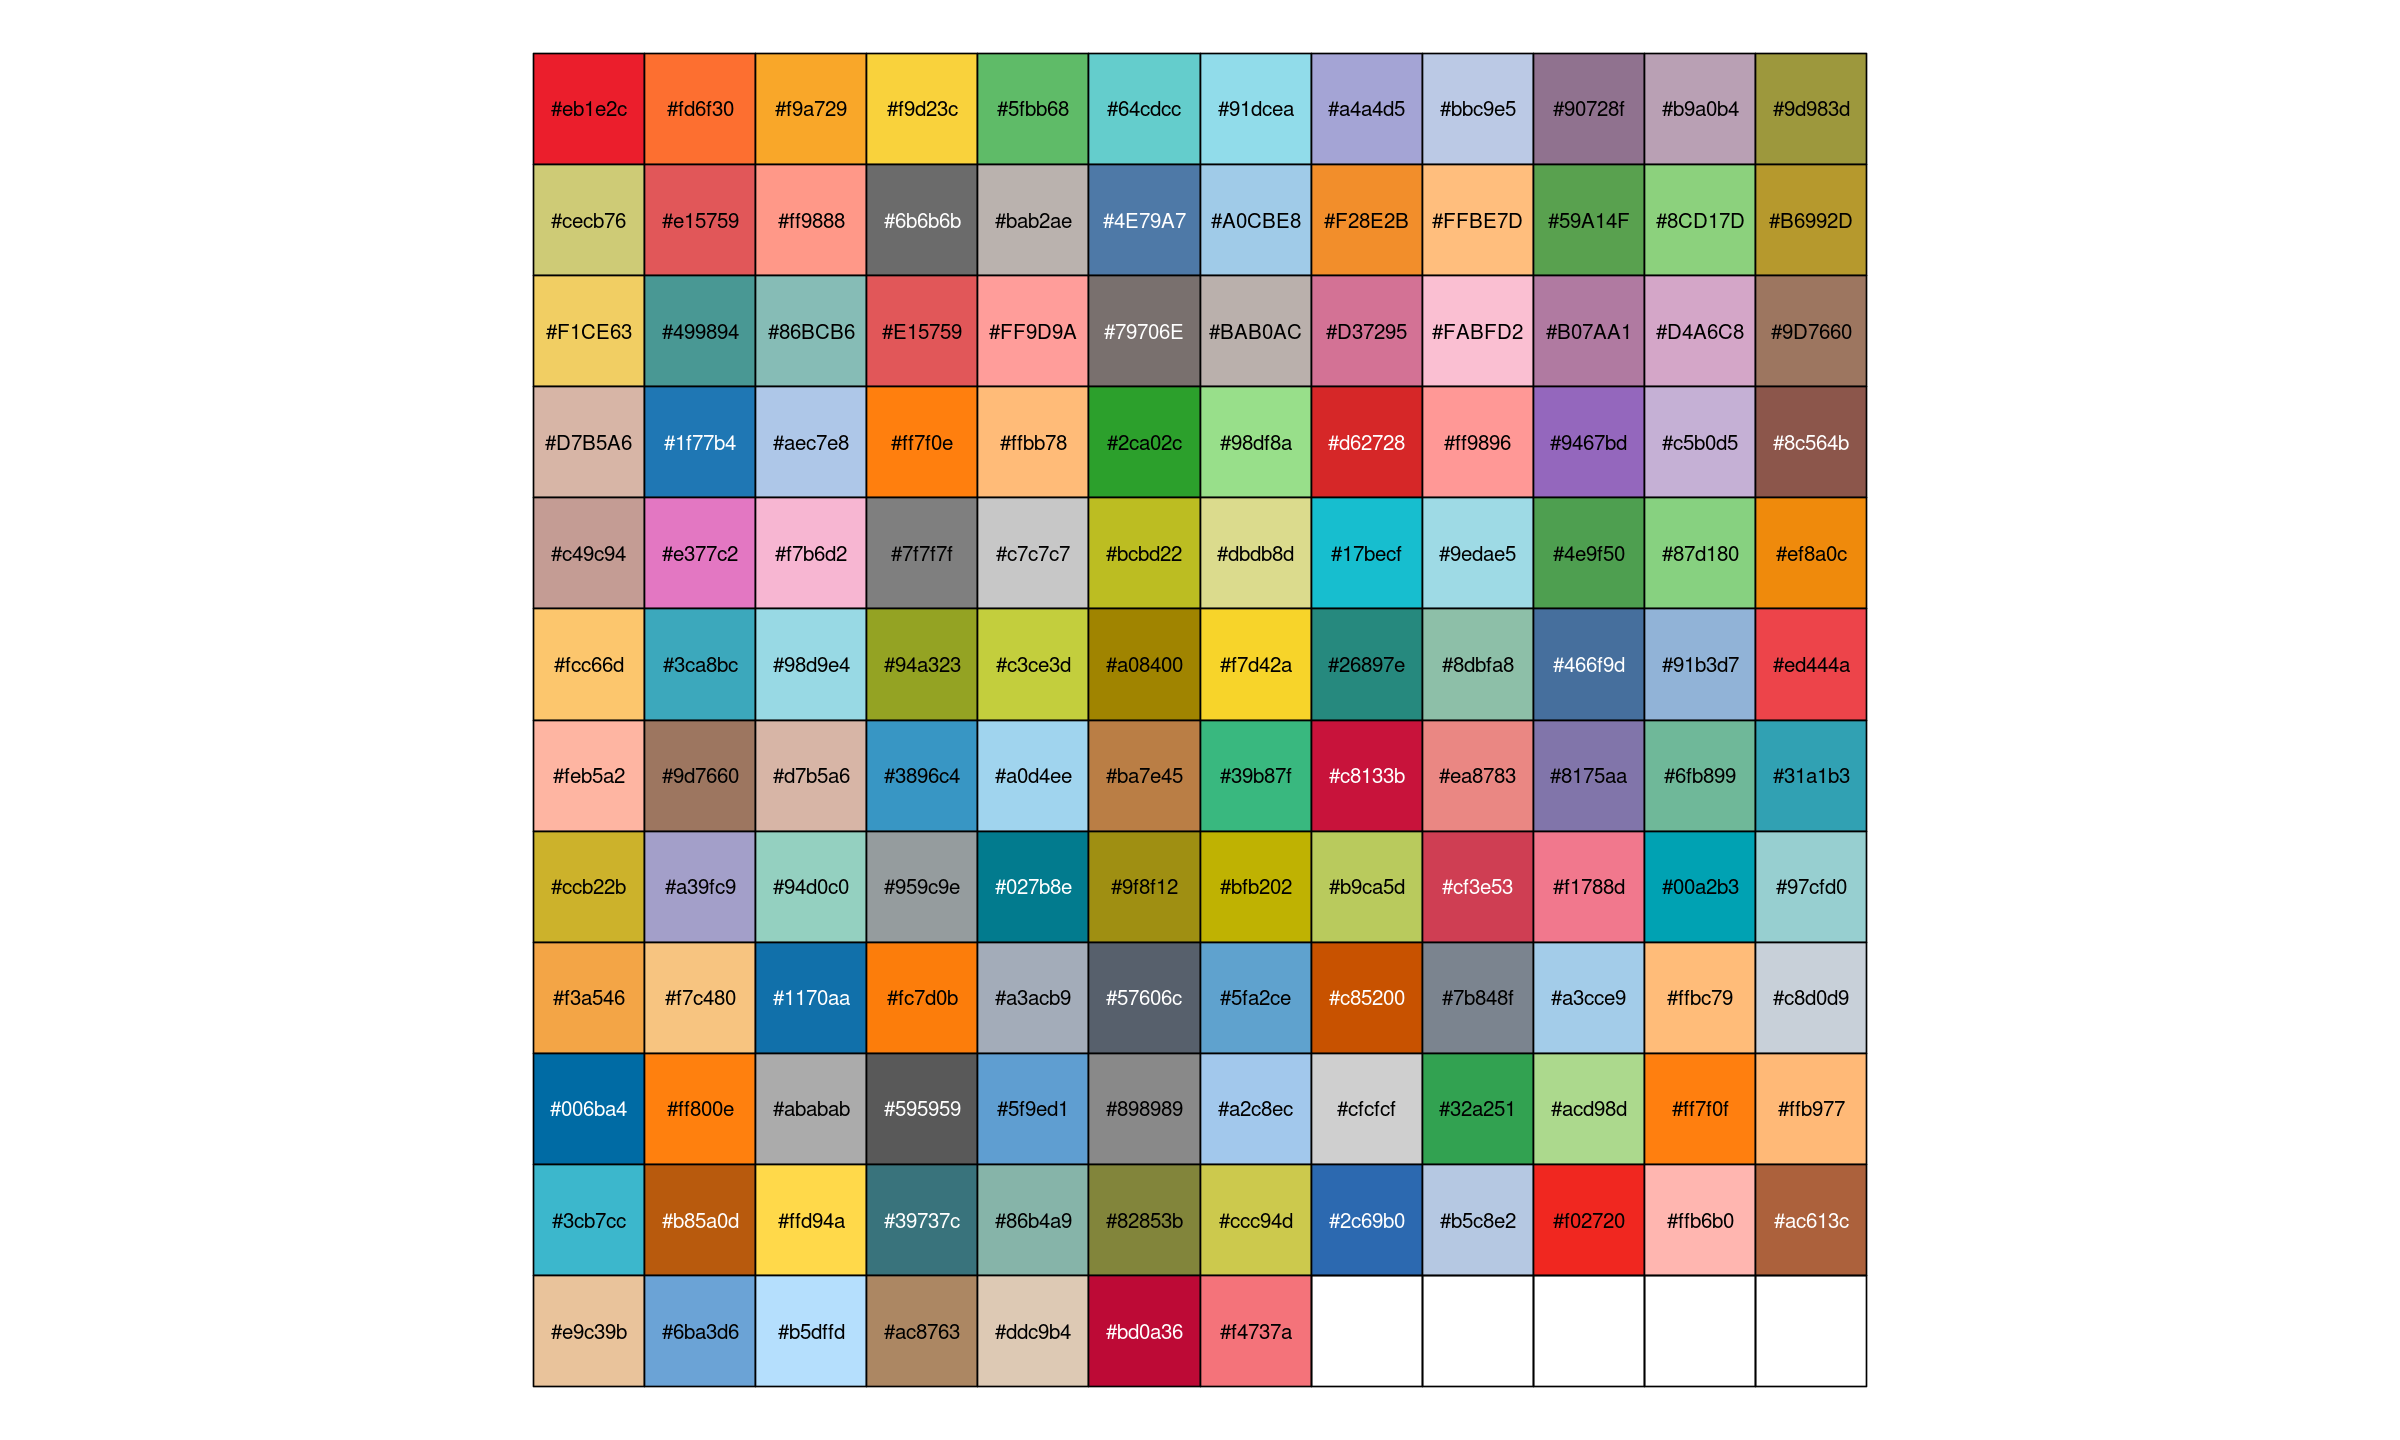

In [13]:
options(repr.plot.width=20, repr.plot.height=12)
mycols <- unique(c(tableau_color_pal("Jewel Bright")(9),
                   tableau_color_pal("Winter")(8),
                   tableau_color_pal('Tableau 20')(20), 
                   tableau_color_pal('Classic 20')(20),
                   tableau_color_pal("Green-Orange-Teal")(12),
                   tableau_color_pal("Red-Blue-Brown")(12),
                   tableau_color_pal("Nuriel Stone")(9),
                   tableau_color_pal("Summer")(8),
                   tableau_color_pal("Color Blind")(10),
                   tableau_color_pal("Classic Color Blind")(10),
                   tableau_color_pal("Classic Green-Orange 12")(12),
                   tableau_color_pal("Classic Blue-Red 12")(12)
))
show_col(mycols)

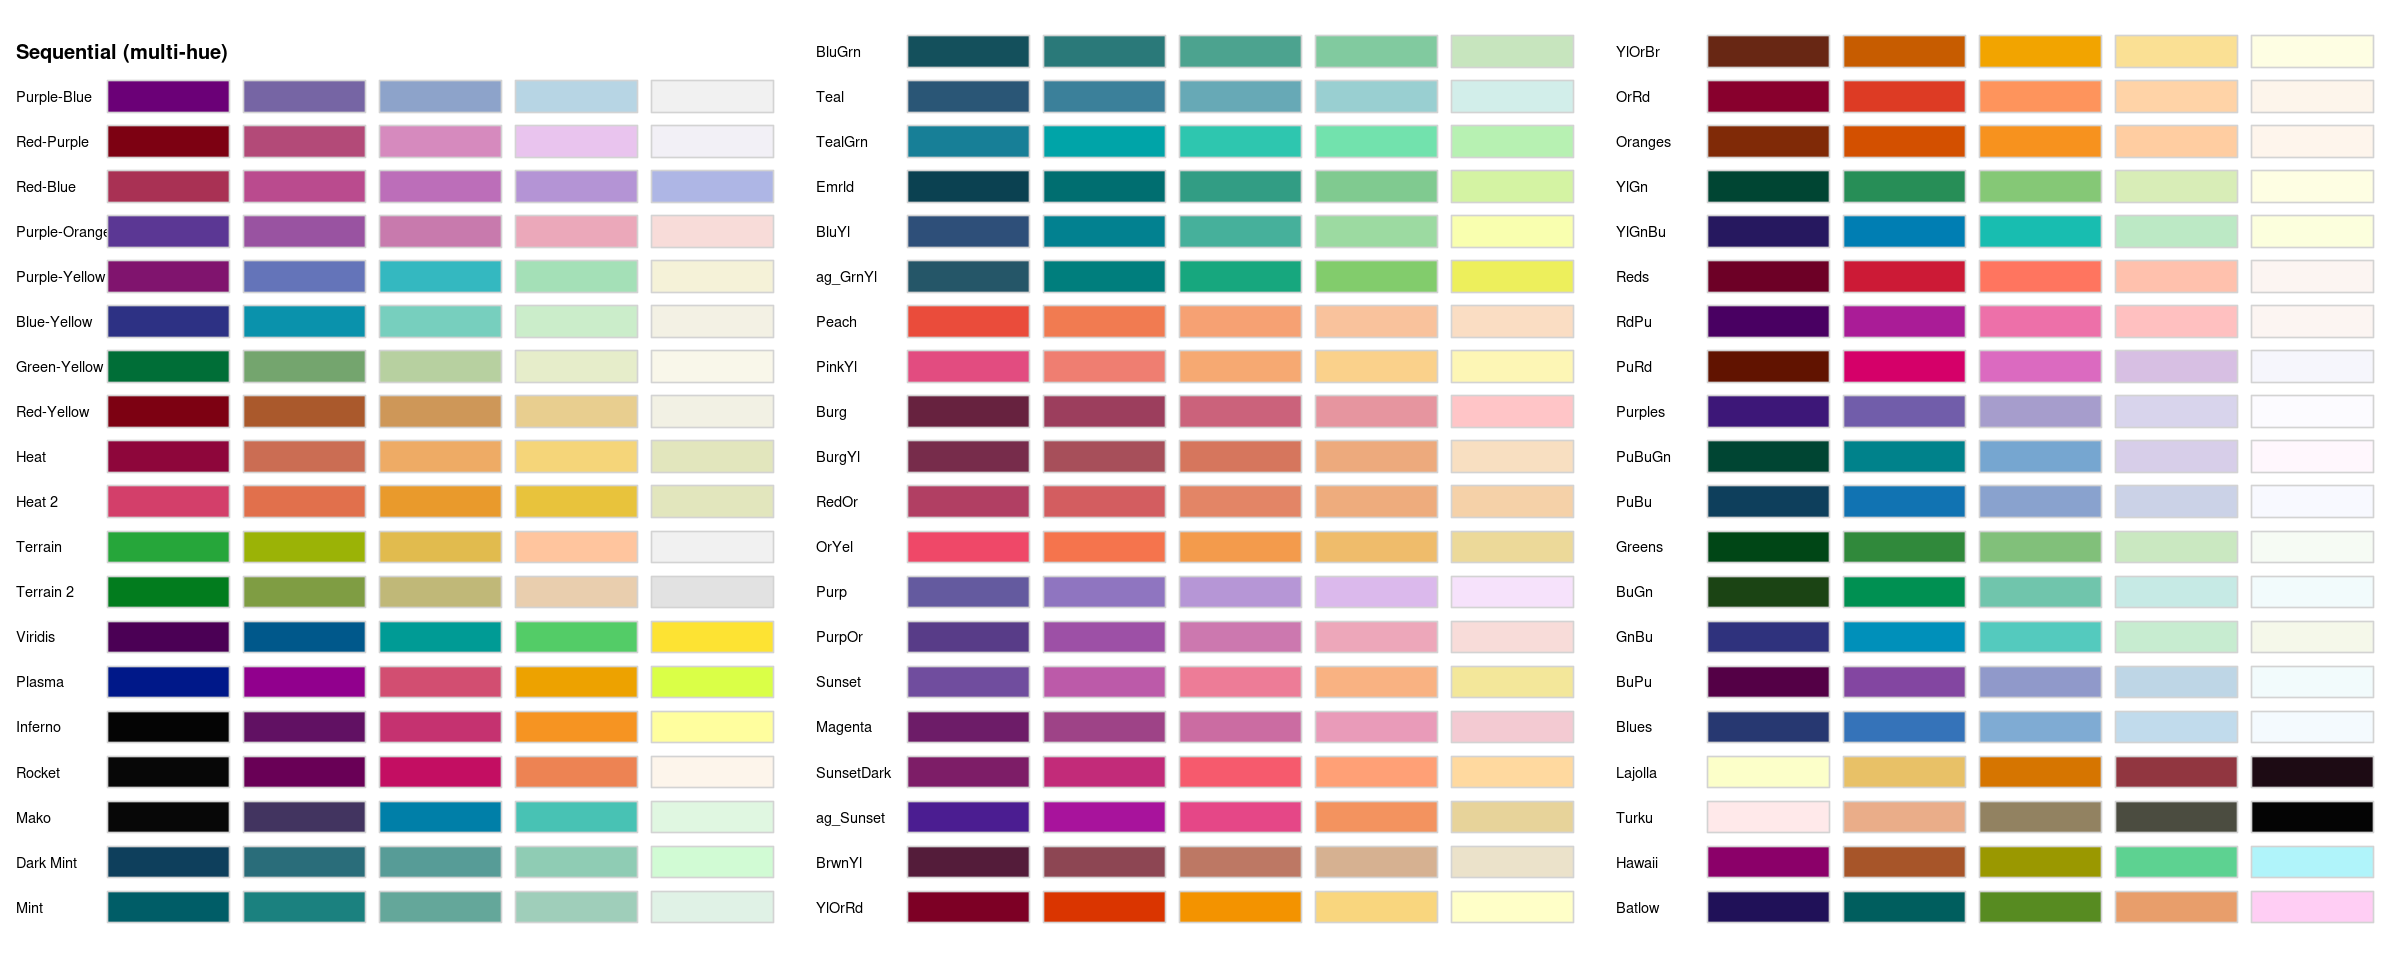

In [14]:
library(colorspace)
options(repr.plot.width=20, repr.plot.height=8)
hcl_palettes(type = "Sequential(multi-hue)", plot = TRUE)

In [ ]:
hcl_palettes(type = "Sequential(multi-hue)", plot = TRUE)

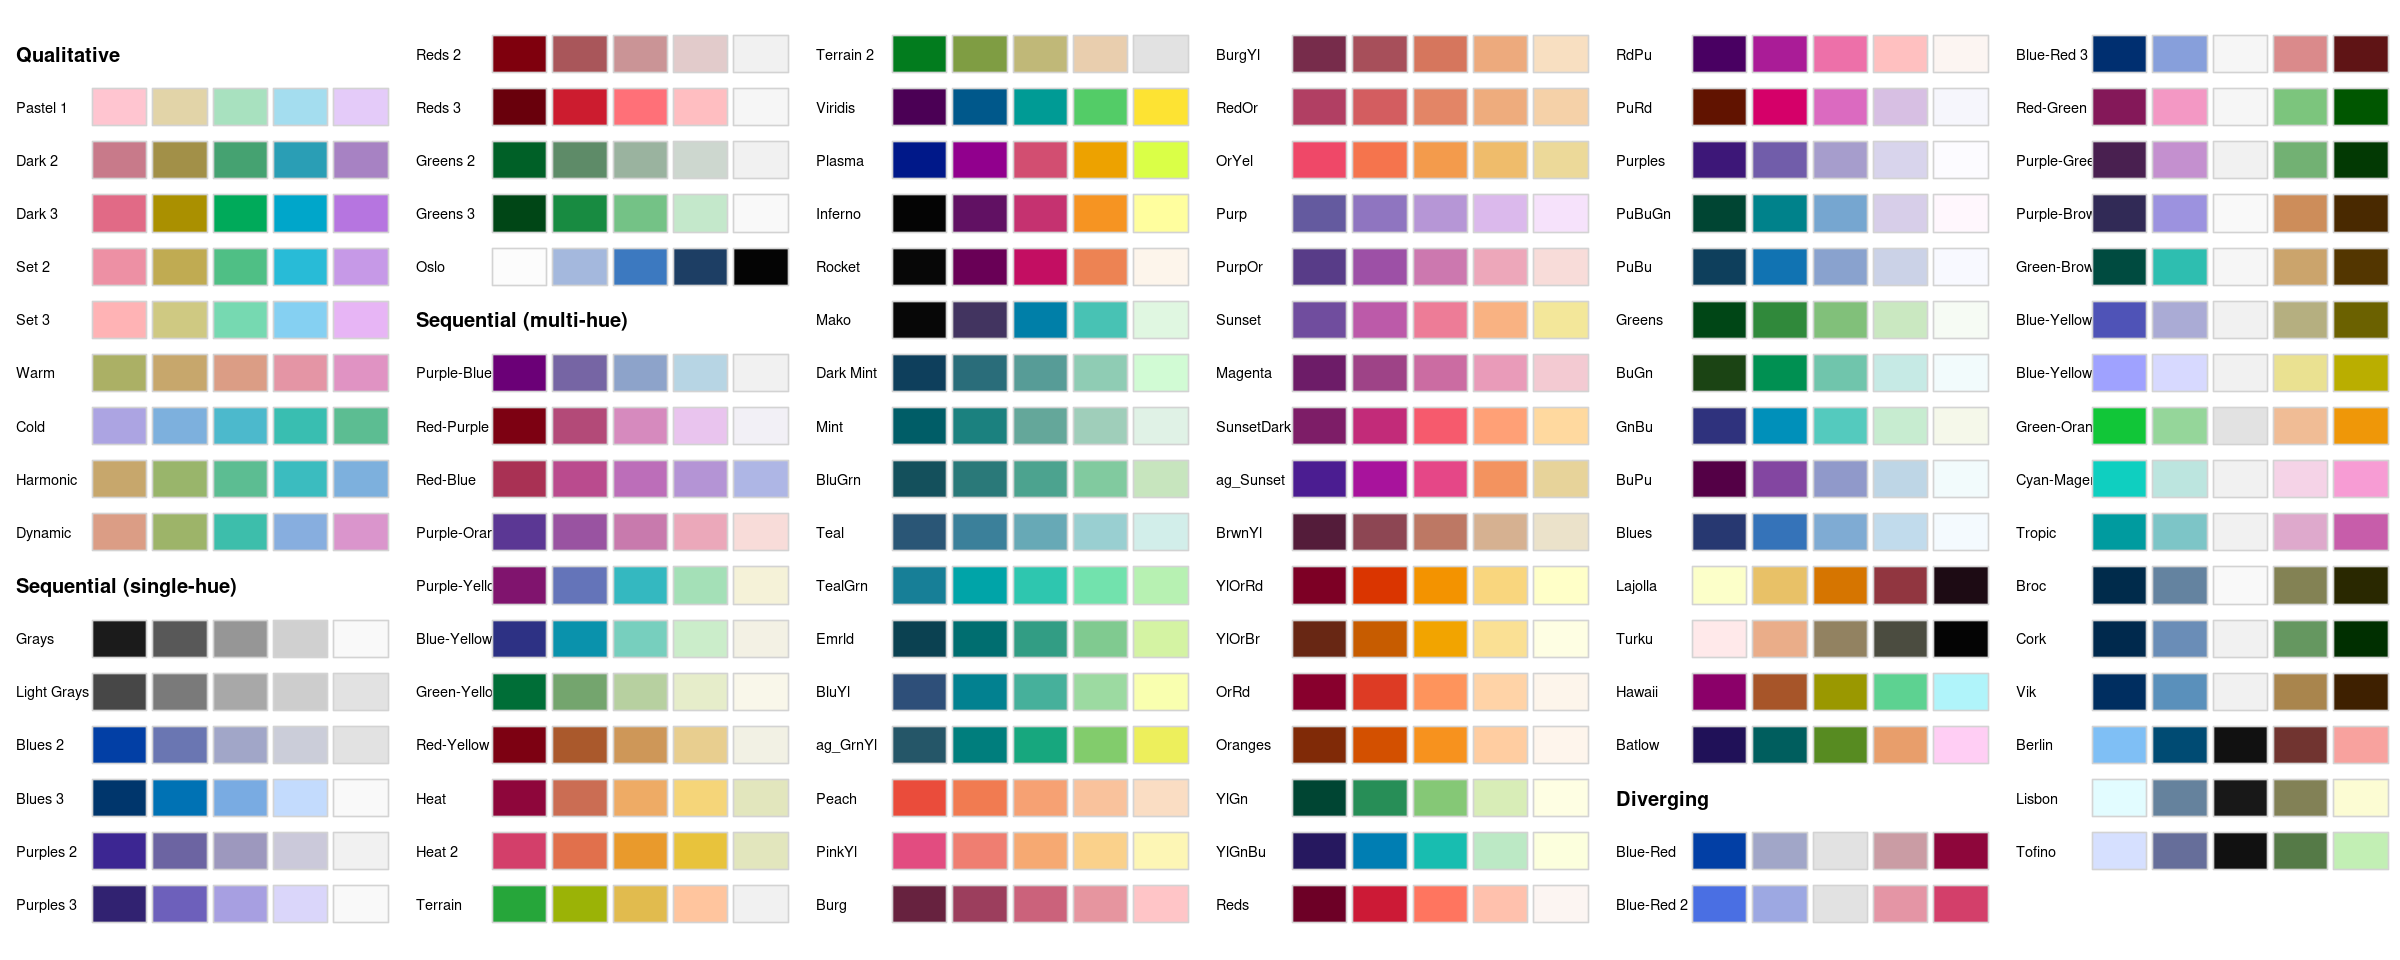

In [13]:
options(repr.plot.width=20, repr.plot.height=8)
hcl_palettes(plot = TRUE)

## Load obj

In [18]:
seuobj <- readRDS("/mnt/public2/pancancer/metastasis/analysis/metastasis.final.rds")
seuobj

An object of class Seurat 
64751 features across 460337 samples within 3 assays 
Active assay: RNA (33538 features, 0 variable features)
 2 other assays present: SCT, integrated
 2 dimensional reductions calculated: pca, umap

In [17]:
# meta <- readRDS("/mnt/public2/pancancer/metastasis/analysis/metadata.rds") # 前面已经load了

In [15]:
meta$tissue_group <- paste0(meta$tissue, "_",meta$group)
unique(meta$tissue_group)

[1] "Lung_PT"      "Liver_PN"     "Liver_PT"     "Eye_HM"       "Eye_PT"      
 [6] "Intestine_HM" "Intestine_PT" "Pancreas_HM"  "Pancreas_PT"  "Stomach_PT"  
[11] "Stomach_HM"   "Mammary_HM"   "Mammary_PT"   "Lung_HM"      "Pancreas_PN" 
[16] "Eye_NN"       "Intestine_NN" "Lung_NN"      "Mammary_NN"   "Pancreas_NN" 
[21] "Liver_NN"

In [16]:
table(meta$sampleID)


   CRC01-HM    CRC01-PT    CRC02-HM    CRC02-PT    CRC03-HM    CRC03-PT 
      12189       14983        2327        9156        7649        4745 
   Eye01-NN    Eye02-NN    Eye03-NN     GC01-HM     GC01-PT     GC02-HM 
       5308        1817        2276        1261        2349       10007 
    GC02-PT     GC03-PT     GC04-PT     GC05-PT     GC06-PT   GC07-PT_1 
       3035        3281        5271        3943        5814        7443 
  GC07-PT_2    HCC01-PT    HCC02-PT    HCC03-PN    HCC03-PT    HCC04-PT 
       2218        3121        4101        2548        4794        3500 
   HCC05-PN    HCC05-PT    HCC06-PN    HCC06-PT    HCC07-PN    HCC07-PT 
       3893        3307        3938        4096        3345         485 
   HCC08-PN    HCC08-PT    HCC09-PN    HCC09-PT    HCC10-PN    HCC10-PT 
       4211        4544        1826        2805        2672        2616 
   ICC01-PN    ICC01-PT    ICC02-PN    ICC02-PT  ICC03-PT_1  ICC03-PT_2 
       9934        4917        4160        2971   

### major type

In [14]:
p <- DimPlot(object = obj, pt.size = 0.2, label = TRUE, label.size = 3, reduction = "umap")

umap <- obj@reductions$umap@cell.embeddings %>%
  as.data.frame() %>%
  cbind(cell_type = obj@meta.data$major_cluster)
umap$cell_type <- as.character(umap$cell_type)
umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



UMAP_1    UMAP_2     
GSM3516662@@_120703436614579                            -4.198203   0.5764038
GSM3516662@@_120726924712805                            -5.305143   0.4895166
GSM3516662@@_120772934388134                             2.866539  -7.9036397
GSM3516662@@_120786758522667                            -8.180273  -2.4508680
GSM3516662@@_120864470887134                             1.927395   3.3812133
GSM3516662@@_121276833327460                             2.690780  -8.1745013
GSM3516662@@_121742672193460                             6.217315   9.1493836
GSM3516662@@_121955419343149                            -7.679572  -2.5822910
GSM3516662@@_121955419384155                            -6.807934   1.2847980
GSM3516662@@_121955419907819                            -8.495267  -4.0068792
GSM3516662@@_121965727148323                             2.754066  -8.0611591
GSM3516662@@_121965772979430                             2.723624  -8.3756675
GSM3516662@@_122282749126891                             2.455257  -8.6445178
GSM3516662@@_122282764036316                             5.893076   9.2674676
GSM3516662@@_122308412173555                             2.960900  -8.2006206
GSM3516662@@_122310443784563                             5.784698   7.1089283
GSM3516662@@_122428792650461                             3.040539  -7.6010298
GSM3516662@@_122428805802731                             5.963685  10.5321465
GSM3516662@@_122436455460197                             6.848662   9.1331168
GSM3516662@@_122436474296109                            -7.525386  -2.3629042
GSM3516662@@_125042427357987                             2.147127 -13.6532430
GSM3516662@@_125239700383668                            -5.436095   0.9654626
GSM3516662@@_125239726824366                            -8.917736   1.2981410
GSM3516662@@_125745325337827                             3.441462  10.3911134
GSM3516662@@_125745344761253                            -8.985609  -1.8898524
GSM3516662@@_126218817916332                             3.078254  -7.8303217
GSM3516662@@_126681615911668                             2.690224  -8.1965684
GSM3516662@@_126706311347611                             7.140885   8.1083690
GSM3516662@@_126765621786461                             3.351629  -8.2921857
GSM3516662@@_126765667673822                             3.096421  -7.6886887
⋮                                                       ⋮         ⋮          
Liver_10X_TSP6@@_TGCGACGGTCCGGACT_TSP6_Liver_NA_10X_1_2  2.604578   8.7511922
Liver_10X_TSP6@@_TGCGATAAGCAACTCT_TSP6_Liver_NA_10X_1_2  3.461607   9.7187281
Liver_10X_TSP6@@_TGCTCGTGTTCATCGA_TSP6_Liver_NA_10X_1_2  5.712754  10.6357814
Liver_10X_TSP6@@_TGCTTGCAGCCACAAG_TSP6_Liver_NA_10X_1_2  3.350750   8.1267348
Liver_10X_TSP6@@_TGGGAGAGTAGCACGA_TSP6_Liver_NA_10X_1_2  2.613416   9.8052178
Liver_10X_TSP6@@_TGGGATTCAGTAGTTC_TSP6_Liver_NA_10X_1_2  5.644803  10.3252450
Liver_10X_TSP6@@_TGGGCTGGTAGCTCGC_TSP6_Liver_NA_10X_1_2  7.296705  10.0302382
Liver_10X_TSP6@@_TGGTAGTAGTGGTTAA_TSP6_Liver_NA_10X_1_2  3.053123   9.7406321
Liver_10X_TSP6@@_TGTAAGCAGCCGAACA_TSP6_Liver_NA_10X_1_2  4.134873  10.3241092
Liver_10X_TSP6@@_TGTCCCAGTTGTTTGG_TSP6_Liver_NA_10X_1_2  2.801066   9.6978866
Liver_10X_TSP6@@_TGTGATGGTGGGTCAA_TSP6_Liver_NA_10X_1_2  2.970065   9.8658181
Liver_10X_TSP6@@_TGTTCATTCATCGCTC_TSP6_Liver_NA_10X_1_2 10.114432   0.3589552
Liver_10X_TSP6@@_TTACGTTGTATTCCGA_TSP6_Liver_NA_10X_1_2  3.475716   9.5296803
Liver_10X_TSP6@@_TTAGGCAAGTATGACA_TSP6_Liver_NA_10X_1_2  5.420799  10.4880315
Liver_10X_TSP6@@_TTAGGCATCTGGCCTT_TSP6_Liver_NA_10X_1_2  2.427232   8.9994660
Liver_10X_TSP6@@_TTATTGCAGTAAACTG_TSP6_Liver_NA_10X_1_2  5.782977  10.3640853
Liver_10X_TSP6@@_TTCAATCGTTCTTCAT_TSP6_Liver_NA_10X_1_2  2.781699   9.8887168
Liver_10X_TSP6@@_TTCACCGGTCCATACA_TSP6_Liver_NA_10X_1_2  3.898490   9.0131303
Liver_10X_TSP6@@_TTCATTGAGCCAGACA_TSP6_Liver_NA_10X_1_2  3.713464  11.4278394
Liver_10X_TSP6@@_TTCCGGTTCTATCGCC_TSP6_Liver_NA_10X_1_2  8.334215   9.9703980


In [15]:
mycols <- unique(c(tableau_color_pal("Jewel Bright")(9),
                   tableau_color_pal("Winter")(8),
                   tableau_color_pal('Tableau 20')(20), 
                   tableau_color_pal('Classic 20')(20),
                   tableau_color_pal("Green-Orange-Teal")(12),
                   tableau_color_pal("Red-Blue-Brown")(12),
                   tableau_color_pal("Nuriel Stone")(9),
                   tableau_color_pal("Summer")(8),
                   tableau_color_pal("Color Blind")(10),
                   tableau_color_pal("Classic Color Blind")(10),
                   tableau_color_pal("Classic Green-Orange 12")(12),
                   tableau_color_pal("Classic Blue-Red 12")(12)
))
color_celltype <- mycols

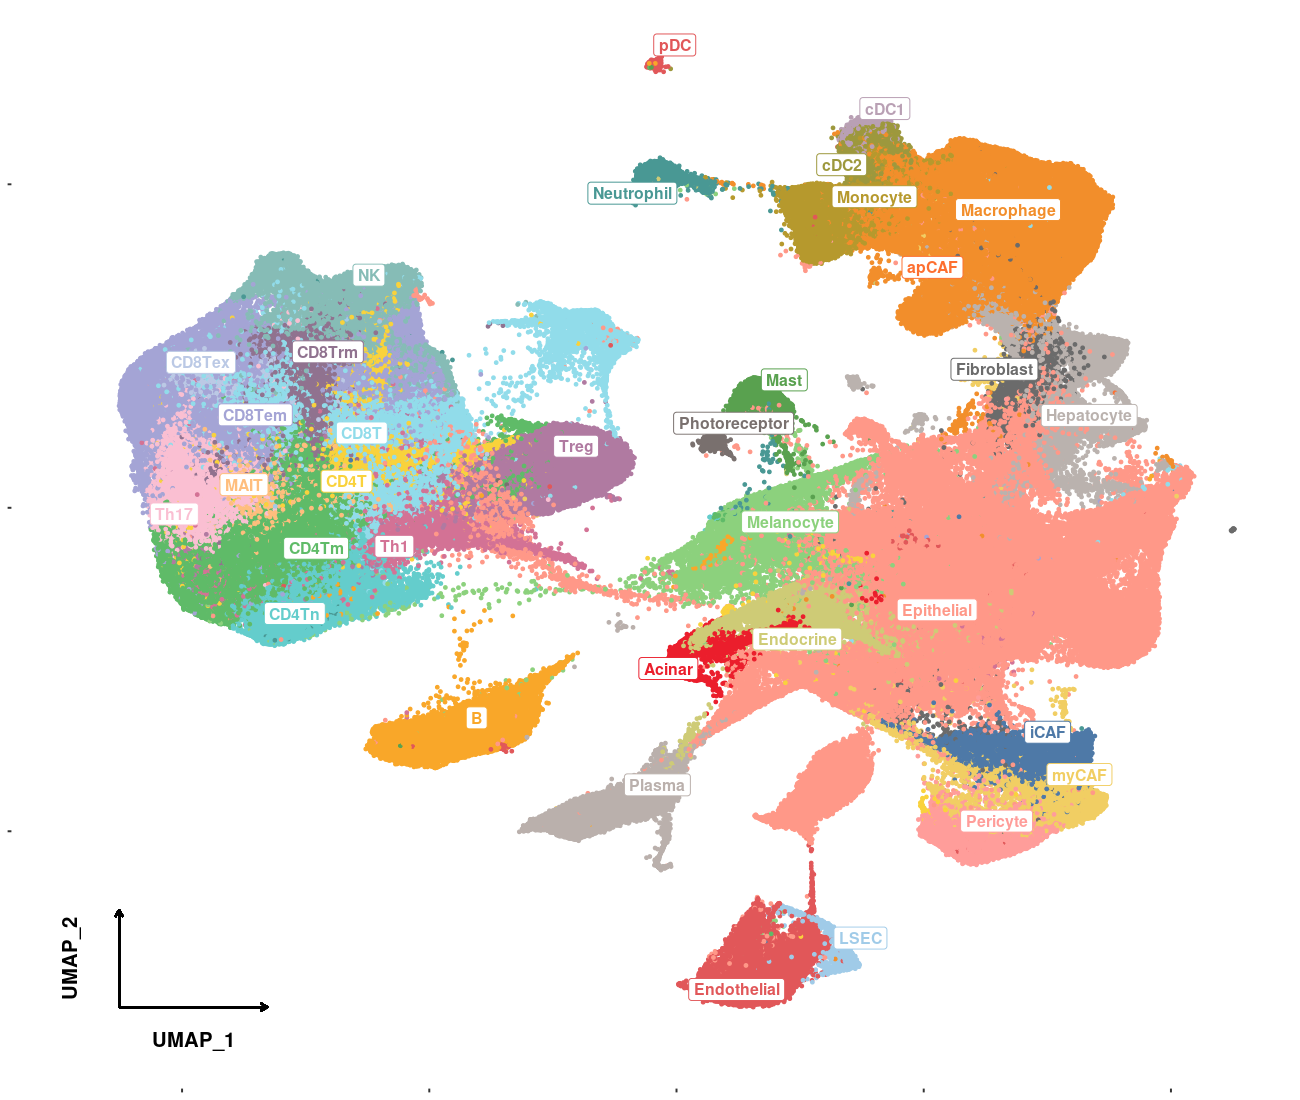

In [37]:
options(repr.plot.width = 13, repr.plot.height =11, repr.plot.res = 100)
p <- ggplot(data = umap, aes(x = UMAP_1, y = UMAP_2, color = cell_type)) +
  geom_point(size = 0.5, alpha = 1) +
  scale_color_manual(values = color_celltype) +
  theme(panel.grid.major = element_blank(), # remove background color……
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        panel.background = element_rect(fill = "white"),
        plot.background = element_rect(fill = "white")) +
  theme(legend.title = element_blank(),
        legend.key = element_rect(fill = "white"), # remove legend background color
        legend.text = element_text(size = 20),
        legend.key.size = unit(1,"cm")) + 
  guides(color = guide_legend(override.aes = list(size = 5))) + # adjust size of plot in legend box
  geom_segment(aes(x = min(umap$UMAP_1), y = min(umap$UMAP_2),
                   xend = min(umap$UMAP_1) + 3, yend = min(umap$UMAP_2)),
               colour = "black", size = 0.5, arrow = arrow(length = unit(0.2,"cm"))) +
  geom_segment(aes(x = min(umap$UMAP_1), y = min(umap$UMAP_2),
                   xend = min(umap$UMAP_1), yend = min(umap$UMAP_2) + 3),
               colour = "black", size = 0.5, arrow = arrow(length = unit(0.2,"cm"))) +  
  annotate("text", x = min(umap$UMAP_1) + 1.5, y = min(umap$UMAP_2) - 1, label = "UMAP_1",
           color = "black", size = 5, fontface = "bold") +
  annotate("text", x = min(umap$UMAP_1) - 1, y = min(umap$UMAP_2) + 1.5, label = "UMAP_2",
           color = "black", size = 5, fontface = "bold", angle = 90)

cell_type_med <- umap %>% group_by(cell_type)
cell_type_med <- dplyr::summarise(.data = cell_type_med, UMAP_1 = median(UMAP_1), UMAP_2 = median(UMAP_2)) 
p2 <- p + geom_label_repel(aes(label = cell_type), fontface = "bold", data = cell_type_med,
                           point.padding = unit(0.5, "lines")) +
  theme(legend.position = "none")
p2

### subtype

In [1126]:
p <- DimPlot(object = obj, pt.size = 0.2, label = TRUE, label.size = 3, reduction = "umap")

umap <- obj@reductions$umap@cell.embeddings %>%
  as.data.frame() %>%
  cbind(cell_type = obj@meta.data$subtype)
umap$cell_type <- as.character(umap$cell_type)
umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



UMAP_1    UMAP_2     
GSM3516662@@_120703436614579                            -4.198203   0.5764038
GSM3516662@@_120726924712805                            -5.305143   0.4895166
GSM3516662@@_120772934388134                             2.866539  -7.9036397
GSM3516662@@_120786758522667                            -8.180273  -2.4508680
GSM3516662@@_120864470887134                             1.927395   3.3812133
GSM3516662@@_121276833327460                             2.690780  -8.1745013
GSM3516662@@_121742672193460                             6.217315   9.1493836
GSM3516662@@_121955419343149                            -7.679572  -2.5822910
GSM3516662@@_121955419384155                            -6.807934   1.2847980
GSM3516662@@_121955419907819                            -8.495267  -4.0068792
GSM3516662@@_121965727148323                             2.754066  -8.0611591
GSM3516662@@_121965772979430                             2.723624  -8.3756675
GSM3516662@@_122282749126891                             2.455257  -8.6445178
GSM3516662@@_122282764036316                             5.893076   9.2674676
GSM3516662@@_122308412173555                             2.960900  -8.2006206
GSM3516662@@_122310443784563                             5.784698   7.1089283
GSM3516662@@_122428792650461                             3.040539  -7.6010298
GSM3516662@@_122428805802731                             5.963685  10.5321465
GSM3516662@@_122436455460197                             6.848662   9.1331168
GSM3516662@@_122436474296109                            -7.525386  -2.3629042
GSM3516662@@_125042427357987                             2.147127 -13.6532430
GSM3516662@@_125239700383668                            -5.436095   0.9654626
GSM3516662@@_125239726824366                            -8.917736   1.2981410
GSM3516662@@_125745325337827                             3.441462  10.3911134
GSM3516662@@_125745344761253                            -8.985609  -1.8898524
GSM3516662@@_126218817916332                             3.078254  -7.8303217
GSM3516662@@_126681615911668                             2.690224  -8.1965684
GSM3516662@@_126706311347611                             7.140885   8.1083690
GSM3516662@@_126765621786461                             3.351629  -8.2921857
GSM3516662@@_126765667673822                             3.096421  -7.6886887
⋮                                                       ⋮         ⋮          
Liver_10X_TSP6@@_TGCGACGGTCCGGACT_TSP6_Liver_NA_10X_1_2  2.604578   8.7511922
Liver_10X_TSP6@@_TGCGATAAGCAACTCT_TSP6_Liver_NA_10X_1_2  3.461607   9.7187281
Liver_10X_TSP6@@_TGCTCGTGTTCATCGA_TSP6_Liver_NA_10X_1_2  5.712754  10.6357814
Liver_10X_TSP6@@_TGCTTGCAGCCACAAG_TSP6_Liver_NA_10X_1_2  3.350750   8.1267348
Liver_10X_TSP6@@_TGGGAGAGTAGCACGA_TSP6_Liver_NA_10X_1_2  2.613416   9.8052178
Liver_10X_TSP6@@_TGGGATTCAGTAGTTC_TSP6_Liver_NA_10X_1_2  5.644803  10.3252450
Liver_10X_TSP6@@_TGGGCTGGTAGCTCGC_TSP6_Liver_NA_10X_1_2  7.296705  10.0302382
Liver_10X_TSP6@@_TGGTAGTAGTGGTTAA_TSP6_Liver_NA_10X_1_2  3.053123   9.7406321
Liver_10X_TSP6@@_TGTAAGCAGCCGAACA_TSP6_Liver_NA_10X_1_2  4.134873  10.3241092
Liver_10X_TSP6@@_TGTCCCAGTTGTTTGG_TSP6_Liver_NA_10X_1_2  2.801066   9.6978866
Liver_10X_TSP6@@_TGTGATGGTGGGTCAA_TSP6_Liver_NA_10X_1_2  2.970065   9.8658181
Liver_10X_TSP6@@_TGTTCATTCATCGCTC_TSP6_Liver_NA_10X_1_2 10.114432   0.3589552
Liver_10X_TSP6@@_TTACGTTGTATTCCGA_TSP6_Liver_NA_10X_1_2  3.475716   9.5296803
Liver_10X_TSP6@@_TTAGGCAAGTATGACA_TSP6_Liver_NA_10X_1_2  5.420799  10.4880315
Liver_10X_TSP6@@_TTAGGCATCTGGCCTT_TSP6_Liver_NA_10X_1_2  2.427232   8.9994660
Liver_10X_TSP6@@_TTATTGCAGTAAACTG_TSP6_Liver_NA_10X_1_2  5.782977  10.3640853
Liver_10X_TSP6@@_TTCAATCGTTCTTCAT_TSP6_Liver_NA_10X_1_2  2.781699   9.8887168
Liver_10X_TSP6@@_TTCACCGGTCCATACA_TSP6_Liver_NA_10X_1_2  3.898490   9.0131303
Liver_10X_TSP6@@_TTCATTGAGCCAGACA_TSP6_Liver_NA_10X_1_2  3.713464  11.4278394
Liver_10X_TSP6@@_TTCCGGTTCTATCGCC_TSP6_Liver_NA_10X_1_2  8.334215   9.9703980


In [1127]:
length(unique(umap$cell_type))

[1] 121

In [1129]:
library(ggthemes)

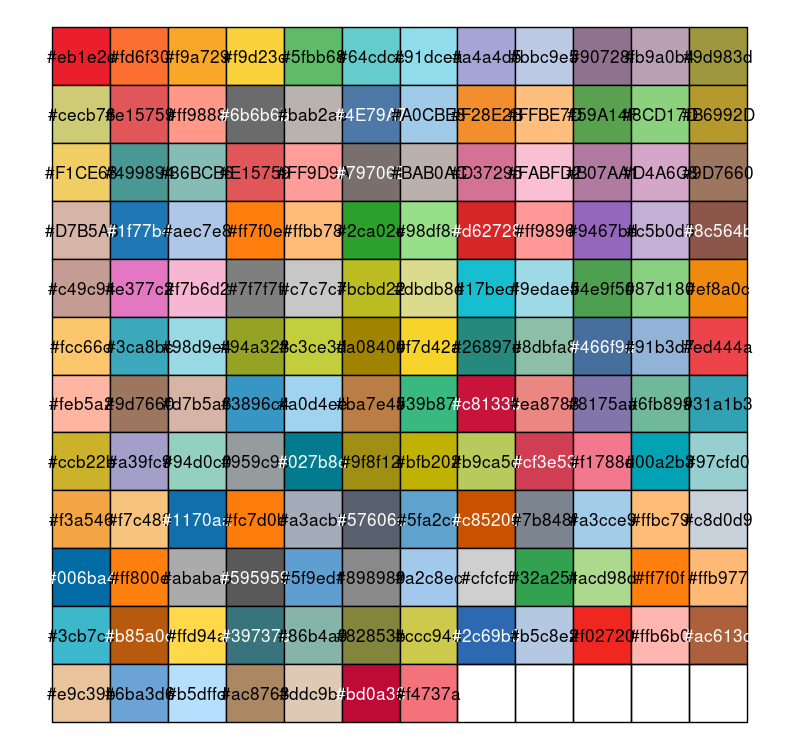

In [1130]:
mycols <- unique(c(tableau_color_pal("Jewel Bright")(9),
                   tableau_color_pal("Winter")(8),
                   tableau_color_pal('Tableau 20')(20), 
                   tableau_color_pal('Classic 20')(20),
                   tableau_color_pal("Green-Orange-Teal")(12),
                   tableau_color_pal("Red-Blue-Brown")(12),
                   tableau_color_pal("Nuriel Stone")(9),
                   tableau_color_pal("Summer")(8),
                   tableau_color_pal("Color Blind")(10),
                   tableau_color_pal("Classic Color Blind")(10),
                   tableau_color_pal("Classic Green-Orange 12")(12),
                   tableau_color_pal("Classic Blue-Red 12")(12)
))
show_col(mycols)

In [1131]:
color_celltype <- mycols

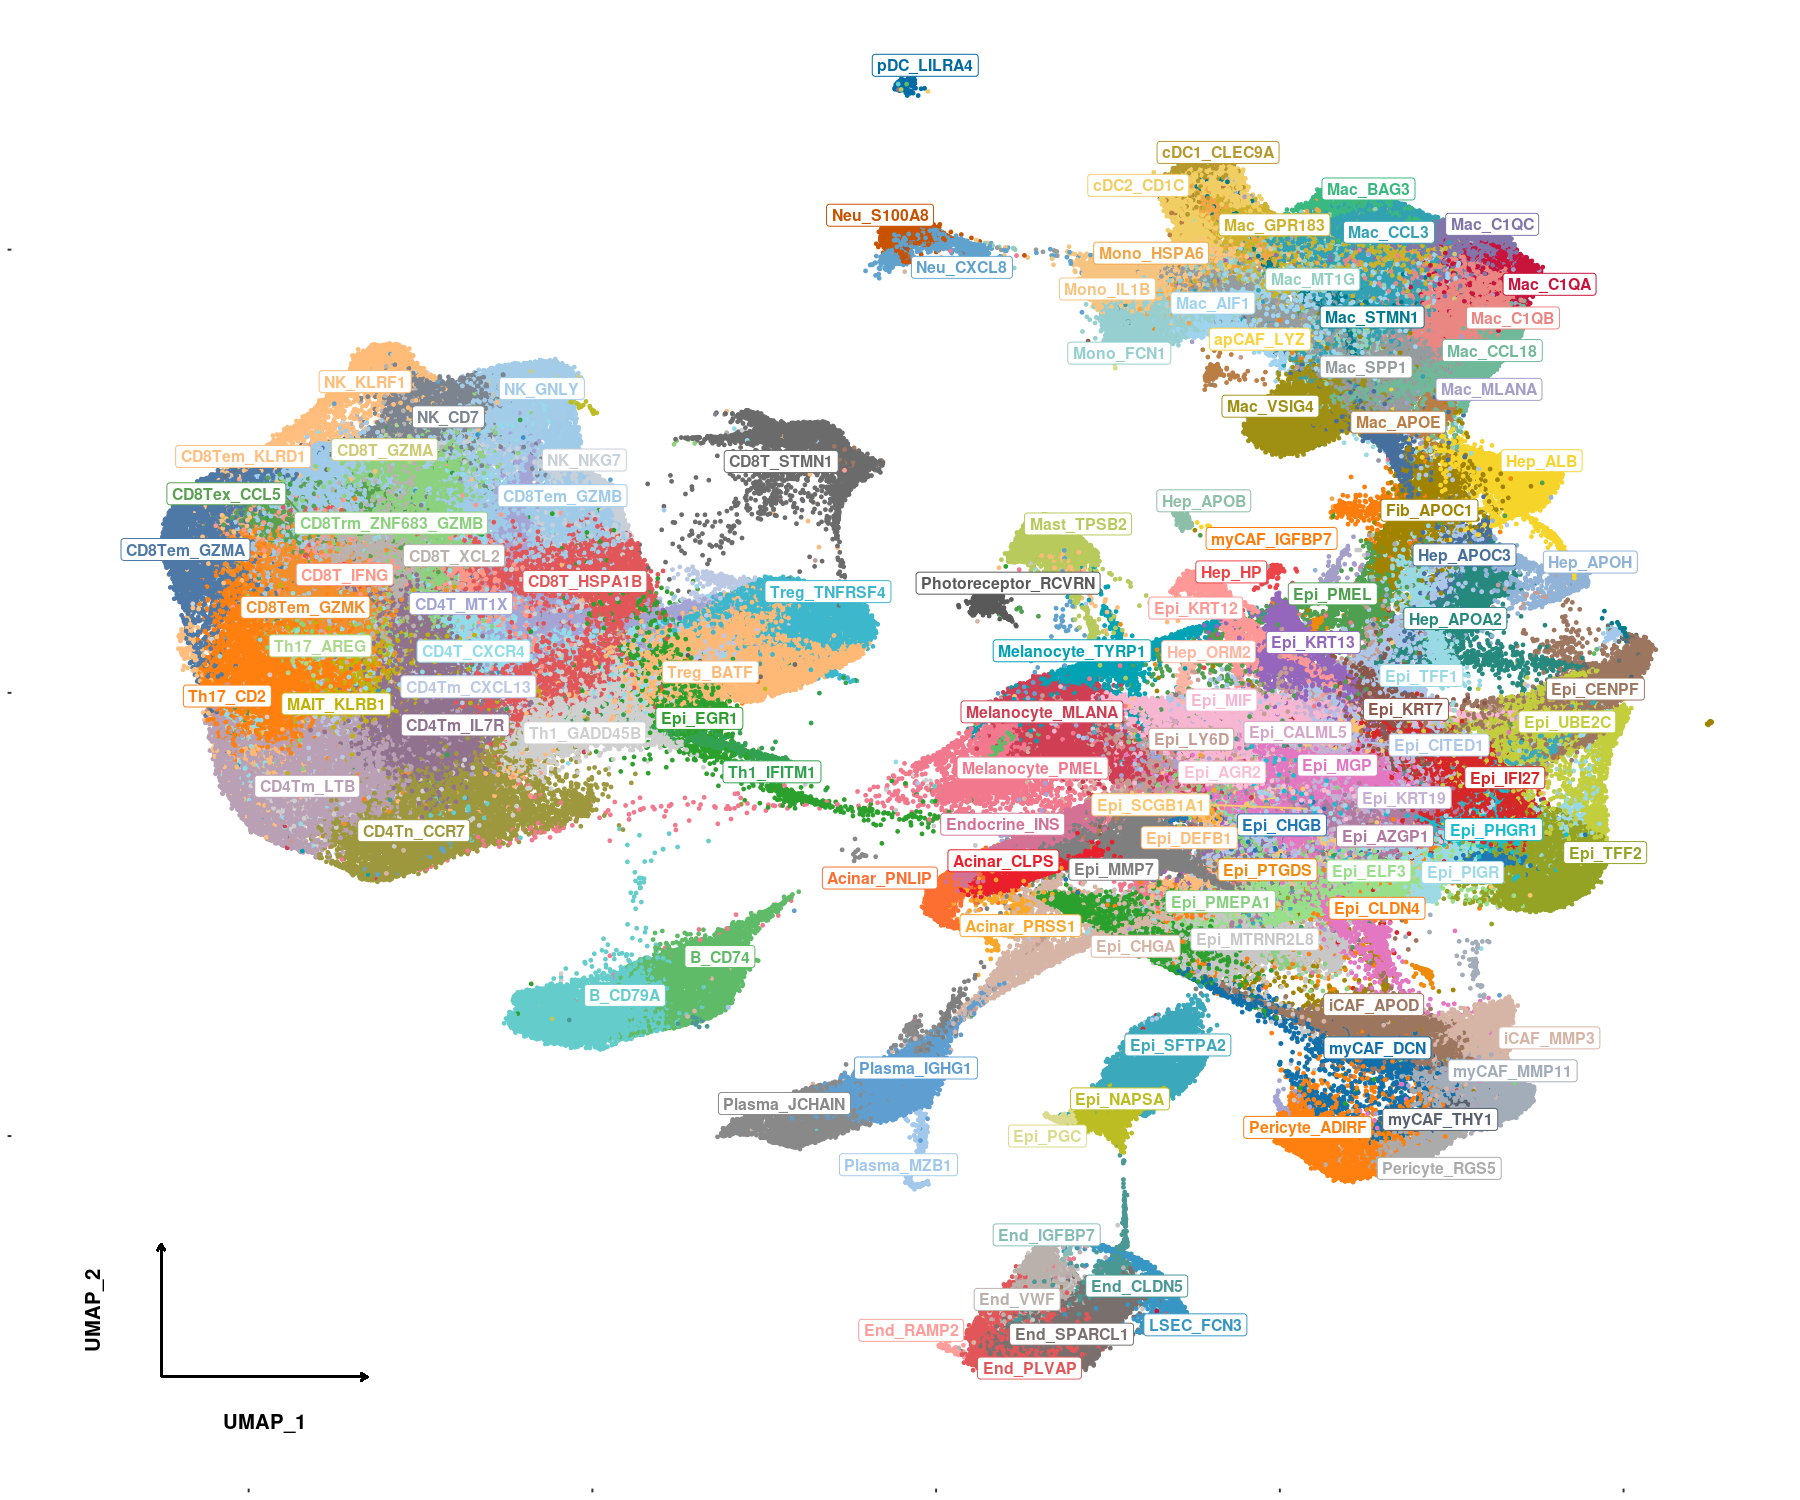

In [1133]:
options(repr.plot.width = 18, repr.plot.height =15, repr.plot.res = 100)
p <- ggplot(data = umap, aes(x = UMAP_1, y = UMAP_2, color = cell_type)) +
  geom_point(size = 0.5, alpha = 1) +
  scale_color_manual(values = color_celltype) +
  theme(panel.grid.major = element_blank(), # remove background color……
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        axis.title = element_blank(),
        axis.text = element_blank(),
        panel.background = element_rect(fill = "white"),
        plot.background = element_rect(fill = "white")) +
  theme(legend.title = element_blank(),
        legend.key = element_rect(fill = "white"), # remove legend background color
        legend.text = element_text(size = 20),
        legend.key.size = unit(1,"cm")) + 
  guides(color = guide_legend(override.aes = list(size = 5))) + # adjust size of plot in legend box
  geom_segment(aes(x = min(umap$UMAP_1), y = min(umap$UMAP_2),
                   xend = min(umap$UMAP_1) + 3, yend = min(umap$UMAP_2)),
               colour = "black", size = 0.5, arrow = arrow(length = unit(0.2,"cm"))) +
  geom_segment(aes(x = min(umap$UMAP_1), y = min(umap$UMAP_2),
                   xend = min(umap$UMAP_1), yend = min(umap$UMAP_2) + 3),
               colour = "black", size = 0.5, arrow = arrow(length = unit(0.2,"cm"))) +  
  annotate("text", x = min(umap$UMAP_1) + 1.5, y = min(umap$UMAP_2) - 1, label = "UMAP_1",
           color = "black", size = 5, fontface = "bold") +
  annotate("text", x = min(umap$UMAP_1) - 1, y = min(umap$UMAP_2) + 1.5, label = "UMAP_2",
           color = "black", size = 5, fontface = "bold", angle = 90)

cell_type_med <- umap %>% group_by(cell_type)
cell_type_med <- dplyr::summarise(.data = cell_type_med, UMAP_1 = median(UMAP_1), UMAP_2 = median(UMAP_2)) 
p2 <- p + geom_label_repel(aes(label = cell_type), fontface = "bold", data = cell_type_med,
                           point.padding = unit(0.5, "lines")) +
  theme(legend.position = "none")
p2

# Spatial validation

In [15]:
dir_spatial <- "/public/workspace202011/pancancer/Zhangcl/liver_metastasis/spatial"
# dir_spatial <- "/mnt/public1/zhangcl/project_liver_metastasis/spatial"

## Load data

In [16]:
library(Seurat)
library(SeuratData)
library(ggplot2)
library(cowplot)
library(dplyr)
library(Matrix)

Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning me

In [ ]:
## 循环生成obj.ST

### Split PDAC & create obj

In [ ]:
## 以下为无三文件但是有spatial_enrichment.csv的读入法：

In [72]:
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("PDAC"),]
need.list

Category   Type Project   Sample       SampleID                      
34 胰腺导管癌 PDAC GSE272362 IU_PDA_HM2_2 GSM8399453_S13_Sample4_F1_Blk 
35 胰腺导管癌 PDAC GSE272362 IU_PDA_HM2   GSM8399454_S13_Sample5_F1_Blu 
36 胰腺导管癌 PDAC GSE272362 IU_PDA_HM3   GSM8399455_S14_Sample6_A1     
37 胰腺导管癌 PDAC GSE272362 IU_PDA_HM4   GSM8399457_S17_Sample8_A1     
38 胰腺导管癌 PDAC GSE272362 IU_PDA_HM5   GSM8399459_S18_Sample10_A1    
39 胰腺导管癌 PDAC GSE272362 IU_PDA_HM6   GSM8399460_S18_Sample11_A1    
40 胰腺导管癌 PDAC GSE272362 IU_PDA_HM8   GSM8399464_S20_Sample15_A1    
41 胰腺导管癌 PDAC GSE272362 IU_PDA_HM9   GSM8399468_S20_Sample19_D2    
42 胰腺导管癌 PDAC GSE272362 IU_PDA_HM10  GSM8399469_S21_Sample20_A1    
43 胰腺导管癌 PDAC GSE272362 IU_PDA_HM11  GSM8399473_S21_Sample24_E3    
44 胰腺导管癌 PDAC GSE272362 IU_PDA_HM12  GSM8399476_S21_Sample27_A1    
45 胰腺导管癌 PDAC GSE272362 IU_PDA_HM13  GSM8399479_S22_Sample30_C2_Blu
   SampleID2        
34 S13-16408_F1(Blk)
35 S13-16408_F1(Blu)
36 S14-8805_A1      
37 S17-19380_A1     
38 S18-24418_A1     
39 S18-27094_A1     
40 S20-11446_A1     
41 S20-19254_D2     
42 S21-15512 _A1    
43 S21-23955_E3     
44 S21-26075_A1     
45 S22-1570_C2 Blu

In [30]:
obj.PDAC <- readRDS(paste0(dir_spatial,"/data/GSE272362/PDAC_Updated.rds"))
obj.PDAC

An object of class Seurat 
38839 features across 91496 samples within 8 assays 
Active assay: rctd_fullfinal (15 features, 0 variable features)
 7 other assays present: Spatial, SCT, integrated, rctd_full, rctd_multi1, rctd_full_all, fges
 8 dimensional reductions calculated: pca, umap, tsne, umap.ischia14, umap.ischia10, umap.ischia12, umap.ischia16, umap.ischia18
 30 images present: IU_PDA_HM9, IU_PDA_HM10, IU_PDA_HM11, IU_PDA_HM12, IU_PDA_HM13, IU_PDA_HM2, IU_PDA_HM3, IU_PDA_HM4, IU_PDA_HM5, IU_PDA_HM6, IU_PDA_HM8, IU_PDA_LNM10, IU_PDA_LNM12, IU_PDA_LNM6, IU_PDA_LNM7, IU_PDA_LNM8, IU_PDA_HM2_2, IU_PDA_NP10, IU_PDA_NP11, IU_PDA_NP2, IU_PDA_T1, IU_PDA_T9, IU_PDA_T10, IU_PDA_T11, IU_PDA_T12, IU_PDA_T2, IU_PDA_T3, IU_PDA_T4, IU_PDA_T6, IU_PDA_T8

In [73]:
for(i in need.list$SampleID2){
    
    index <- which(need.list$SampleID2==i)
    project <- need.list$Project[index]
    sample <- need.list$SampleID[index]
    sample_name <- need.list$Sample[index]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    obj.ST <- subset(obj.PDAC, Sample_ID2 == i)
    obj.ST
    obj.ST@images <- obj.ST@images[names(obj.ST@images)==sample_name]
    names(obj.ST@images) <- "slice1"
    saveRDS(obj.ST, file = paste0(dir,"/ST_object.rds"))
}

In [ ]:
# 已完成

### create obj for BRCA,CRC

In [ ]:
## 以下为10x三文件+spatial文件夹读入法

In [50]:
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("CRC","BRCA"),]
# need.list <- datalist[datalist$Type %in% c("BRCA"),]
need.list

Category   Type Project           Sample                   
1  结直肠癌   CRC  GSE225857         GSM7058760               
2  结直肠癌   CRC  GSE225857         GSM7058761               
3  结直肠癌   CRC  HTAN_WUSTL_CRC    HT225C1-Th1Fc1U1Z1B1     
4  结直肠癌   CRC  HTAN_WUSTL_CRC    HT225C1-Th1Fc1U2Z1B1     
5  结直肠癌   CRC  HTAN_WUSTL_CRC    HT225C1-Th1Fc1U3Z1B1     
6  结直肠癌   CRC  HTAN_WUSTL_CRC    HT225C1-Th1Fc1U4Z1B1     
7  结直肠癌   CRC  HTAN_WUSTL_CRC    HT225C1-Th1Fc1U5Z1B1     
8  结直肠癌   CRC  HTAN_WUSTL_CRC    HT413C1-Th1K2A4U14Bp1    
9  结直肠癌   CRC  HTAN_WUSTL_CRC    HT413C1-Th1K2A4U1Bp1     
10 结直肠癌   CRC  HTAN_WUSTL_CRC    HT413C1-Th1K2A4U2Bp1     
11 结直肠癌   CRC  HTAN_WUSTL_CRC    HT413C1-Th1K1A4Us1_3Bp1_1
12 结直肠癌   CRC  HTAN_WUSTL_CRC    HT413C1-Th1K2A1Us1_2Bp1_1
13 结直肠癌   CRC  HTAN_WUSTL_CRC    HT413C1-Th1K3A1Us1_1Bp1_1
14 结直肠癌   CRC  HTAN_WUSTL_CRC    HT112C1-U1_ST_Bn1        
15 结直肠癌   CRC  HTAN_WUSTL_CRC    HT112C1-U2_ST_Bn1        
16 结直肠癌   CRC  HTAN_WUSTL_CRC    HT448C1-Th1K1Fp1U13Bp1   
17 结直肠癌   CRC  HTAN_WUSTL_CRC    HT448C1-Th1K1Fp1U1Bp1    
18 结直肠癌   CRC  HTAN_WUSTL_CRC    HT253C1-Th1K1Fc2U1Z1Bs1  
19 结直肠癌   CRC  HTAN_WUSTL_CRC    HT260C1-Th1K1Fc2U1Z1Bs1  
20 结直肠癌   CRC  HTAN_WUSTL_CRC    HT472C1-Th1K1Fp1U1Bp1    
21 结直肠癌   CRC  HTAN_WUSTL_CRC    S16-38794-E3U1Bp1        
22 结直肠癌   CRC  HTAN_WUSTL_CRC    S15-32775-A1U1Bp1        
23 结直肠癌   CRC  HTAN_WUSTL_CRC    S15-1909-C2U1Bp1         
24 结直肠癌   CRC  HTAN_WUSTL_CRC    HT165C1-Th1K3Fc2U1Z1Bs1  
25 结直肠癌   CRC  HTAN_WUSTL_CRC    HT213C1-Th1K4Fc2U1Z1Bs1  
26 结直肠癌   CRC  HTAN_WUSTL_CRC    HT230C1-Th1Fc1U1Z1B1     
27 结直肠癌   CRC  HTAN_WUSTL_CRC    HT250C1-Th1K1Fc2U1Z1Bs1  
28 结直肠癌   CRC  HTAN_WUSTL_CRC    HT525C1-Th1K1Fp1U1Bp1    
29 三阴乳腺癌 BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U2Z1Bs1  
30 三阴乳腺癌 BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U12Z1Bs1 
31 三阴乳腺癌 BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U22Z1Bs1 
32 三阴乳腺癌 BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U32Z1Bs1 
33 三阴乳腺癌 BRCA HTAN_WUSTL_Breast HT268B1-Th1K3Fc2U1Z1Bs1  
   SampleID                  SampleID2        
1  GSM7058760                                 
2  GSM7058761                                 
3  HT225C1-Th1Fc1U1Z1B1      HT225C1-Th1U1    
4  HT225C1-Th1Fc1U2Z1B1      HT225C1-Th1U2    
5  HT225C1-Th1Fc1U3Z1B1      HT225C1-Th1U3    
6  HT225C1-Th1Fc1U4Z1B1      HT225C1-Th1U4    
7  HT225C1-Th1Fc1U5Z1B1      HT225C1-Th1U5    
8  HT413C1-Th1K2A4U14Bp1     HT413C1-Th1K2U14 
9  HT413C1-Th1K2A4U1Bp1      HT413C1-Th1K2U1  
10 HT413C1-Th1K2A4U2Bp1      HT413C1-Th1K2U2  
11 HT413C1-Th1K1A4Us1_3Bp1_1 HT413C1-Th1K1A4U1
12 HT413C1-Th1K2A1Us1_2Bp1_1 HT413C1-Th1K2A1U1
13 HT413C1-Th1K3A1Us1_1Bp1_1 HT413C1-Th1K3A1U1
14 HT112C1-U1_ST_Bn1         HT112C1-Th1U1    
15 HT112C1-U2_ST_Bn1         HT112C1-Th1U2    
16 HT448C1-Th1K1Fp1U13Bp1    HT448C1-Th1K1U13 
17 HT448C1-Th1K1Fp1U1Bp1     HT448C1-Th1K1U1  
18 HT253C1-Th1K1Fc2U1Z1Bs1   HT253C1-Th1K1U1  
19 HT260C1-Th1K1Fc2U1Z1Bs1   HT260C1-Th1K1U1  
20 HT472C1-Th1K1Fp1U1Bp1     HT472C1-Th1K1U1  
21 S16-38794-E3U1Bp1         S16-38794-E3U1   
22 S15-32775-A1U1Bp1         S15-32775-A1U1   
23 S15-1909-C2U1Bp1          S15-1909-C2U1    
24 HT165C1-Th1K3Fc2U1Z1Bs1   HT165C1-Th1K3U1  
25 HT213C1-Th1K4Fc2U1Z1Bs1   HT213C1-Th1K4U1  
26 HT230C1-Th1Fc1U1Z1B1      HT230C1-Th1U1    
27 HT250C1-Th1K1Fc2U1Z1Bs1   HT250C1-Th1K1U1  
28 HT525C1-Th1K1Fp1U1Bp1     HT525C1-Th1K1U1  
29 HT268B1-Th1H3Fc2U2Z1Bs1   HT268B1-Th1K3U2  
30 HT268B1-Th1H3Fc2U12Z1Bs1  HT268B1-Th1K3U12 
31 HT268B1-Th1H3Fc2U22Z1Bs1  HT268B1-Th1K3U22 
32 HT268B1-Th1H3Fc2U32Z1Bs1  HT268B1-Th1K3U32 
33 HT268B1-Th1K3Fc2U1Z1Bs1   HT268B1-Th1K3U1

In [ ]:
# for(i in 1:nrow(need.list)){
#     project <- need.list$Project[i]
#     sample <- need.list$Sample[i]
#     dir <- paste0(dir_spatial,"/data/",project,"/",sample)
#     if(dir.exists(dir)){
#         obj.ST <- Read10X(dir)
#         obj.ST
#         image <- Read10X_Image(image.dir = paste0(dir,"/spatial"), filter.matrix = TRUE)
#         image
#         obj.ST <- CreateSeuratObject(counts = obj.ST, assay = "Spatial")
#         image <- image[Cells(x = obj.ST)]
#         DefaultAssay(obj.ST = image) <- "Spatial"
#         obj.ST[["slice1"]] <- image
#         # 进行标准化
#         obj.ST <- SCTransform(obj.ST, assay = "Spatial", verbose = FALSE)
#         saveRDS(obj.ST, file = paste0(dir,"/ST_object.rds"))        
#     }
# # }

In [32]:
i <- 1
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
project
sample
dir
dir.exists(dir)

[1] "HTAN_WUSTL_Breast"

[1] "HT268B1-Th1H3Fc2U2Z1Bs1"

[1] "/public/workspace202011/pancancer/Zhangcl/liver_metastasis/spatial/data/HTAN_WUSTL_Breast/HT268B1-Th1H3Fc2U2Z1Bs1"

[1] TRUE

In [34]:
obj <- readRDS(paste0(dir,"/SeuratObj.rds"))
obj

An object of class Seurat 
57422 features across 4352 samples within 2 assays 
Active assay: SCT (20821 features, 3000 variable features)
 1 other assay present: Spatial
 2 dimensional reductions calculated: pca, umap
 1 image present: slice1

In [47]:
obj@meta.data

orig.ident    nCount_Spatial nFeature_Spatial percent_mt
AAACAAGTATCTCCCA-1 SeuratProject   8138         3384             0.7372819 
AAACACCAATAACTGC-1 SeuratProject 100726         9190             4.9282211 
AAACAGAGCGACTCCT-1 SeuratProject   7595         2992             2.0671494 
AAACAGCTTTCAGAAG-1 SeuratProject  27725         6149             1.8250676 
AAACAGGGTCTATATT-1 SeuratProject  22878         5371             2.0412623 
AAACAGTGTTCCTGGG-1 SeuratProject  12447         4102             2.7958544 
AAACATGGTGAGAGGA-1 SeuratProject  42525         7413             1.5520282 
AAACATTTCCCGGATT-1 SeuratProject  12119         4157             0.8251506 
AAACCACTACACAGAT-1 SeuratProject   5830         2530             1.2521441 
AAACCCGAACGAAATC-1 SeuratProject  17288         4805             2.9037483 
AAACCGGAAATGTTAA-1 SeuratProject   3791         2000             0.7913479 
AAACCGGGTAGGTACC-1 SeuratProject  16279         4618             1.9780085 
AAACCGTTCGTCCAGG-1 SeuratProject  10725         3677             1.8275058 
AAACCTAAGCAGCCGG-1 SeuratProject   7846         3229             0.6245220 
AAACCTCATGAAGTTG-1 SeuratProject  17880         5094             0.8277405 
AAACGAAGAACATACC-1 SeuratProject   5750         2619             1.0782609 
AAACGAAGATGGAGTA-1 SeuratProject  92217         7977             9.0818396 
AAACGACAGTCTTGCC-1 SeuratProject   1413          849             1.2031139 
AAACGAGACGGTTGAT-1 SeuratProject  13006         4025             2.8371521 
AAACGCCCGAGATCGG-1 SeuratProject   2260         1310             2.0796460 
AAACGGGCGTACGGGT-1 SeuratProject   7117         2706             1.3769847 
AAACGGTTGCGAACTG-1 SeuratProject  11877         4536             0.6988297 
AAACGTGTTCGCCCTA-1 SeuratProject  27517         6281             3.8230912 
AAACTAACGTGGCGAC-1 SeuratProject   8192         3061             1.8310547 
AAACTCGGTTCGCAAT-1 SeuratProject  10692         4185             0.6921062 
AAACTCGTGATATAAG-1 SeuratProject  15005         4893             1.5061646 
AAACTGCTGGCTCCAA-1 SeuratProject  15019         4326             4.2879020 
AAACTTAATTGCACGC-1 SeuratProject  22505         5560             0.8842479 
AAACTTGCAAACGTAT-1 SeuratProject  22235         5555             1.6910277 
AAAGAATGACCTTAGA-1 SeuratProject  29882         6209             1.2549361 
⋮                  ⋮             ⋮              ⋮                ⋮         
TTGGTGCGGTGTTGAA-1 SeuratProject  2783          1542             1.0779734 
TTGGTTGCGGTGCGCG-1 SeuratProject  6544          2628             2.0629584 
TTGTAACTTCATAGCG-1 SeuratProject  8163          3311             2.0825677 
TTGTAAGGACCTAAGT-1 SeuratProject  8455          3244             1.3601419 
TTGTAAGGCCAGTTGG-1 SeuratProject 15132          4652             1.8569918 
TTGTAATCCGTACTCG-1 SeuratProject 15212          4160             0.8019984 
TTGTACACCTCGAACA-1 SeuratProject 39097          6777             2.3096401 
TTGTATCACACAGAAT-1 SeuratProject 18287          5084             1.7608137 
TTGTCACCGCGGTATC-1 SeuratProject 16066          4502             1.6245487 
TTGTCGTTCAGTTACC-1 SeuratProject  4514          2086             1.7058042 
TTGTGAACCTAATCCG-1 SeuratProject  7654          3378             0.4572772 
TTGTGAGGCATGACGC-1 SeuratProject 18732          4923             1.8898142 
TTGTGCAGCCACGTCA-1 SeuratProject 12733          4622             0.7225320 
TTGTGCGGAAGCGGAT-1 SeuratProject 60118          7408             5.9133704 
TTGTGGAGACAGCCGG-1 SeuratProject 32101          6815             2.3706427 
TTGTGGCCCTGACAGT-1 SeuratProject   176           140             7.3863636 
TTGTGGTAGGAGGGAT-1 SeuratProject  5254          2078             1.6749144 
TTGTGGTGGTACTAAG-1 SeuratProject  5962          2548             0.9896008 
TTGTGTATGCCACCAA-1 SeuratProject  3339          1723             0.4791854 
TTGTGTTTCCCGAAAG-1 SeuratProject  1755          1136             0.5128205 
TTGTTAGCAAATTCGA-1 SeuratProject 14265          4486             0.

In [35]:
saveRDS(obj, file = paste0(dir,"/ST_object.rds")) 

In [20]:
        obj.ST <- Read10X(dir)
        obj.ST

   [[ suppressing 32 column names ‘AAACAACGAATAGTTC-1’, ‘AAACAAGTATCTCCCA-1’, ‘AAACAATCTACTAGCA-1’ ... ]]

   [[ suppressing 32 column names ‘AAACAACGAATAGTTC-1’, ‘AAACAAGTATCTCCCA-1’, ‘AAACAATCTACTAGCA-1’ ... ]]

   [[ suppressing 32 column names ‘AAACAACGAATAGTTC-1’, ‘AAACAAGTATCTCCCA-1’, ‘AAACAATCTACTAGCA-1’ ... ]]



36601 x 4992 sparse Matrix of class "dgCMatrix"
                                                                                            
MIR1302-2HG   .  .  .   .  .   .   .  .   .  .  .  . .   .  .  .   .  .   .  .  .  . .  .  .
FAM138A       .  .  .   .  .   .   .  .   .  .  .  . .   .  .  .   .  .   .  .  .  . .  .  .
OR4F5         .  .  .   .  .   .   .  .   .  .  .  . .   .  .  .   .  .   .  .  .  . .  .  .
AL627309.1    .  .  .   .  .   .   .  .   .  .  .  . .   .  .  .   .  .   .  .  .  . .  .  .
AL627309.3    .  .  .   .  .   .   .  .   .  .  .  . .   .  .  .   .  .   .  .  .  . .  .  .
AL627309.2    .  .  .   .  .   .   .  .   .  .  .  . .   .  .  .   .  .   .  .  .  . .  .  .
AL627309.5    .  .  .   .  .   .   .  .   .  .  .  . .   .  .  .   .  .   .  .  .  . .  .  .
AL627309.4    .  .  .   .  .   .   .  .   .  .  .  . .   .  .  .   .  .   .  .  .  . .  .  .
AP006222.2    .  .  .   .  .   .   .  .   .  .  .  . .   .  .  .   .  .   .  .  .  . .  .  .
AL732372.1    .  .  . 

In [ ]:
saveRDS(obj.ST, file = paste0(dir,"/ST_object.rds")) 

In [ ]:
# 处理中

In [17]:
obj.ST <- readRDS(file = paste0(dir_spatial,"/data/HTAN_WUSTL_Breast/HT268B1-Th1H3Fc2U2Z1Bs1/ST_object.rds"))

Warning message in gzfile(file, "rb"):
“cannot open compressed file '/public/workspace202011/pancancer/Zhangcl/liver_metastasis/spatial/data/HTAN_WUSTL_Breast/HT268B1-Th1H3Fc2U2Z1Bs1/ST_object.rds', probable reason 'No such file or directory'”


ERROR: Error in gzfile(file, "rb"): cannot open the connection


In [ ]:
colnames(obj.ST@meta.data)

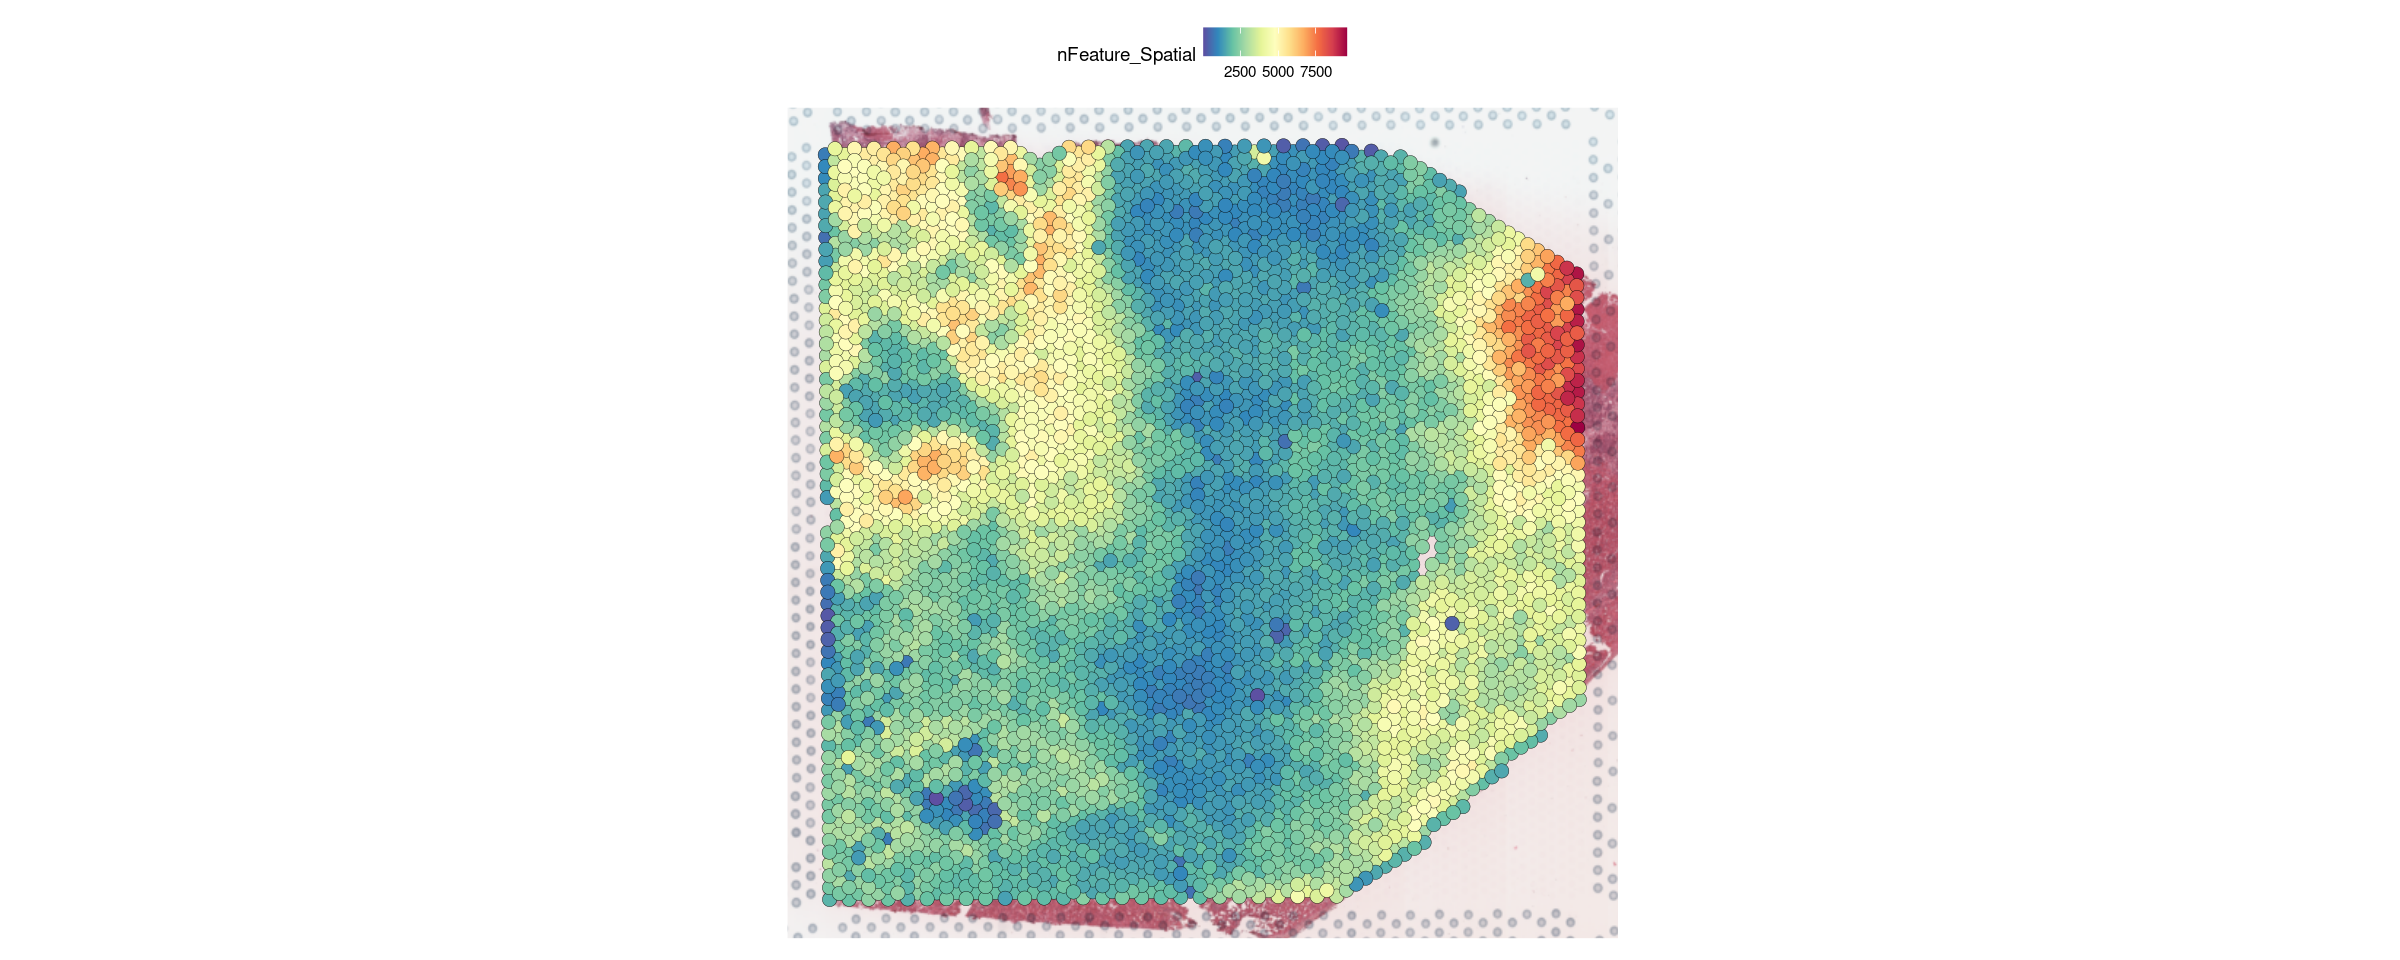

In [17]:
SpatialFeaturePlot(obj.ST, features = "nFeature_Spatial") # 在5300会报和FeaturePlot一样的错，5200不会

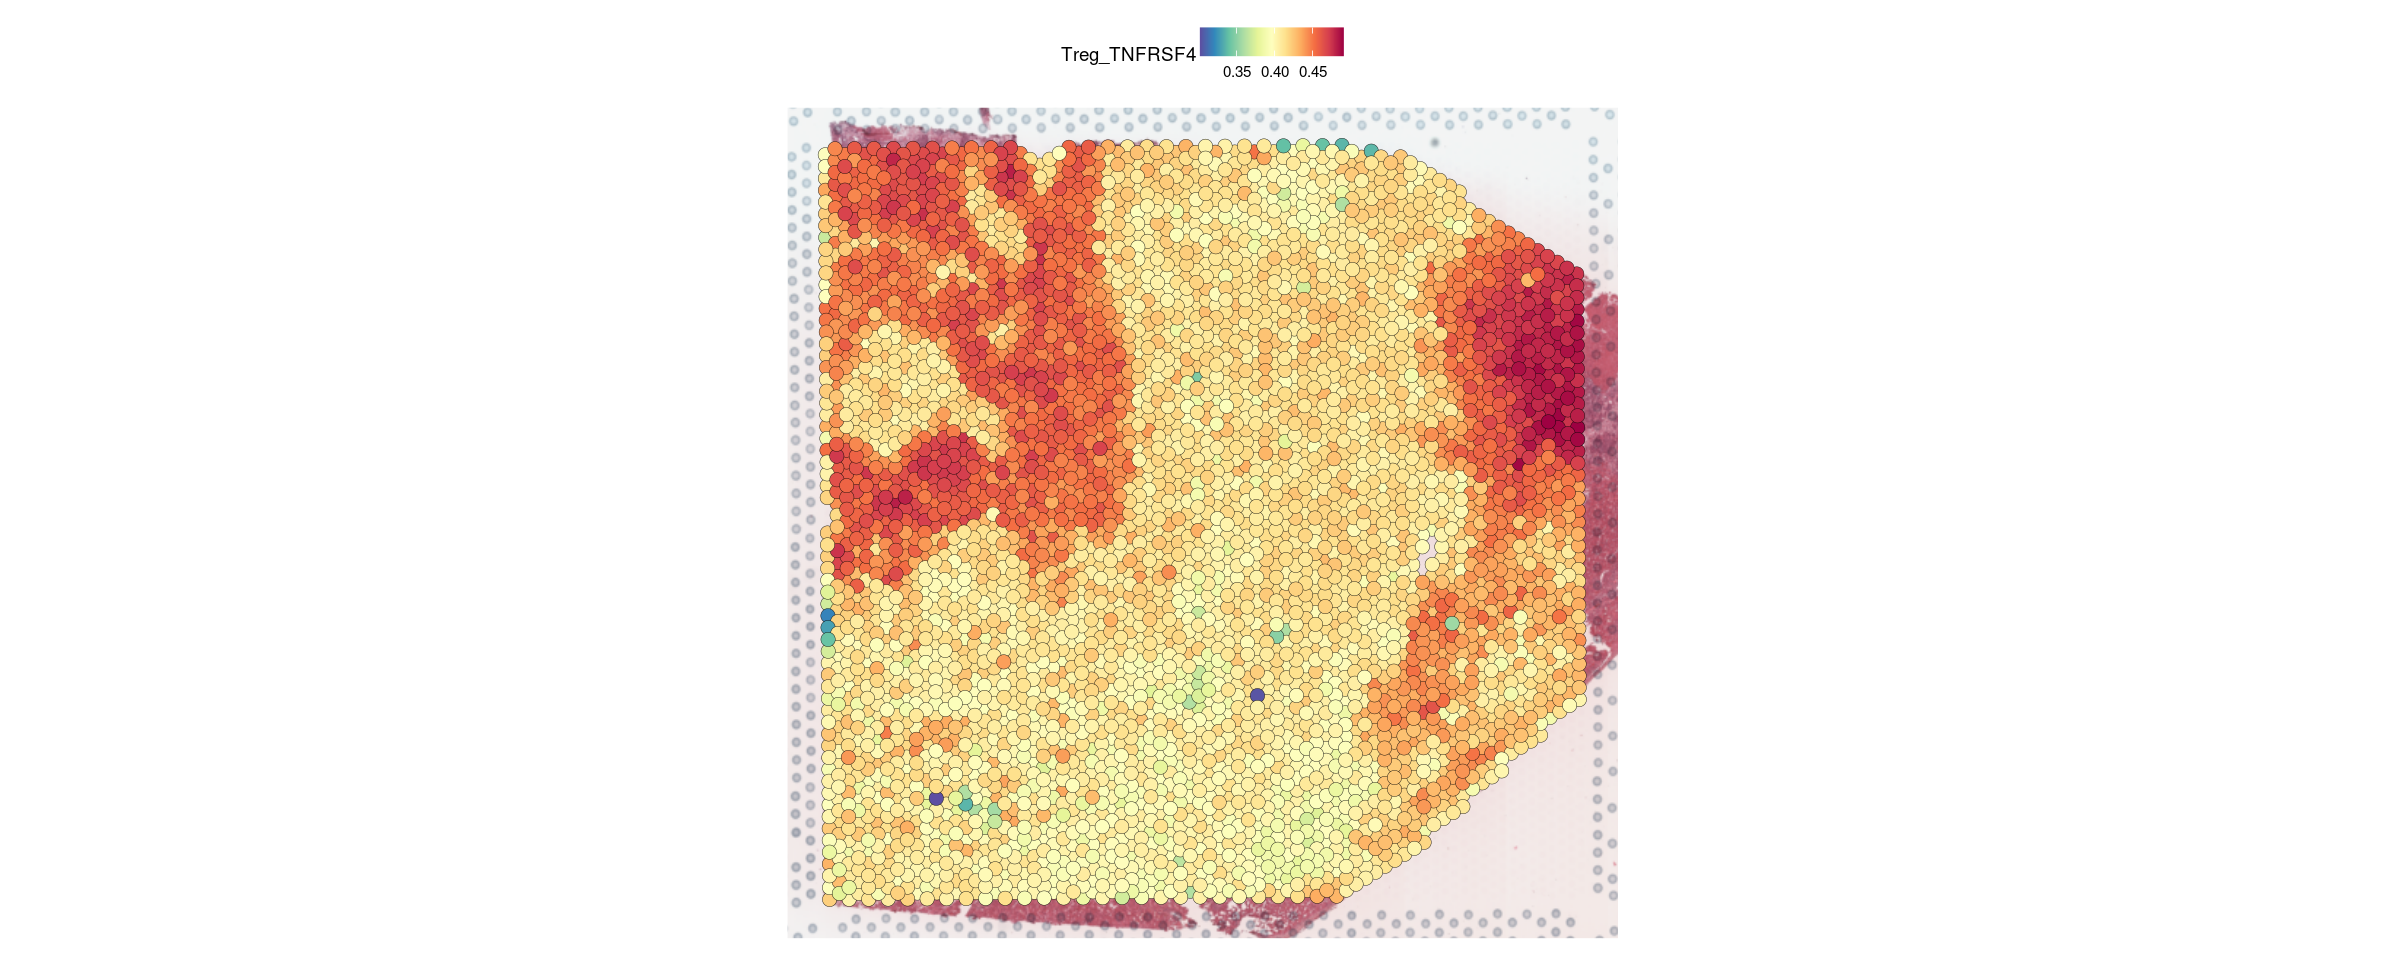

In [18]:
SpatialFeaturePlot(obj.ST, features = "Treg_TNFRSF4",l) # 会报和FeaturePlot一样的错

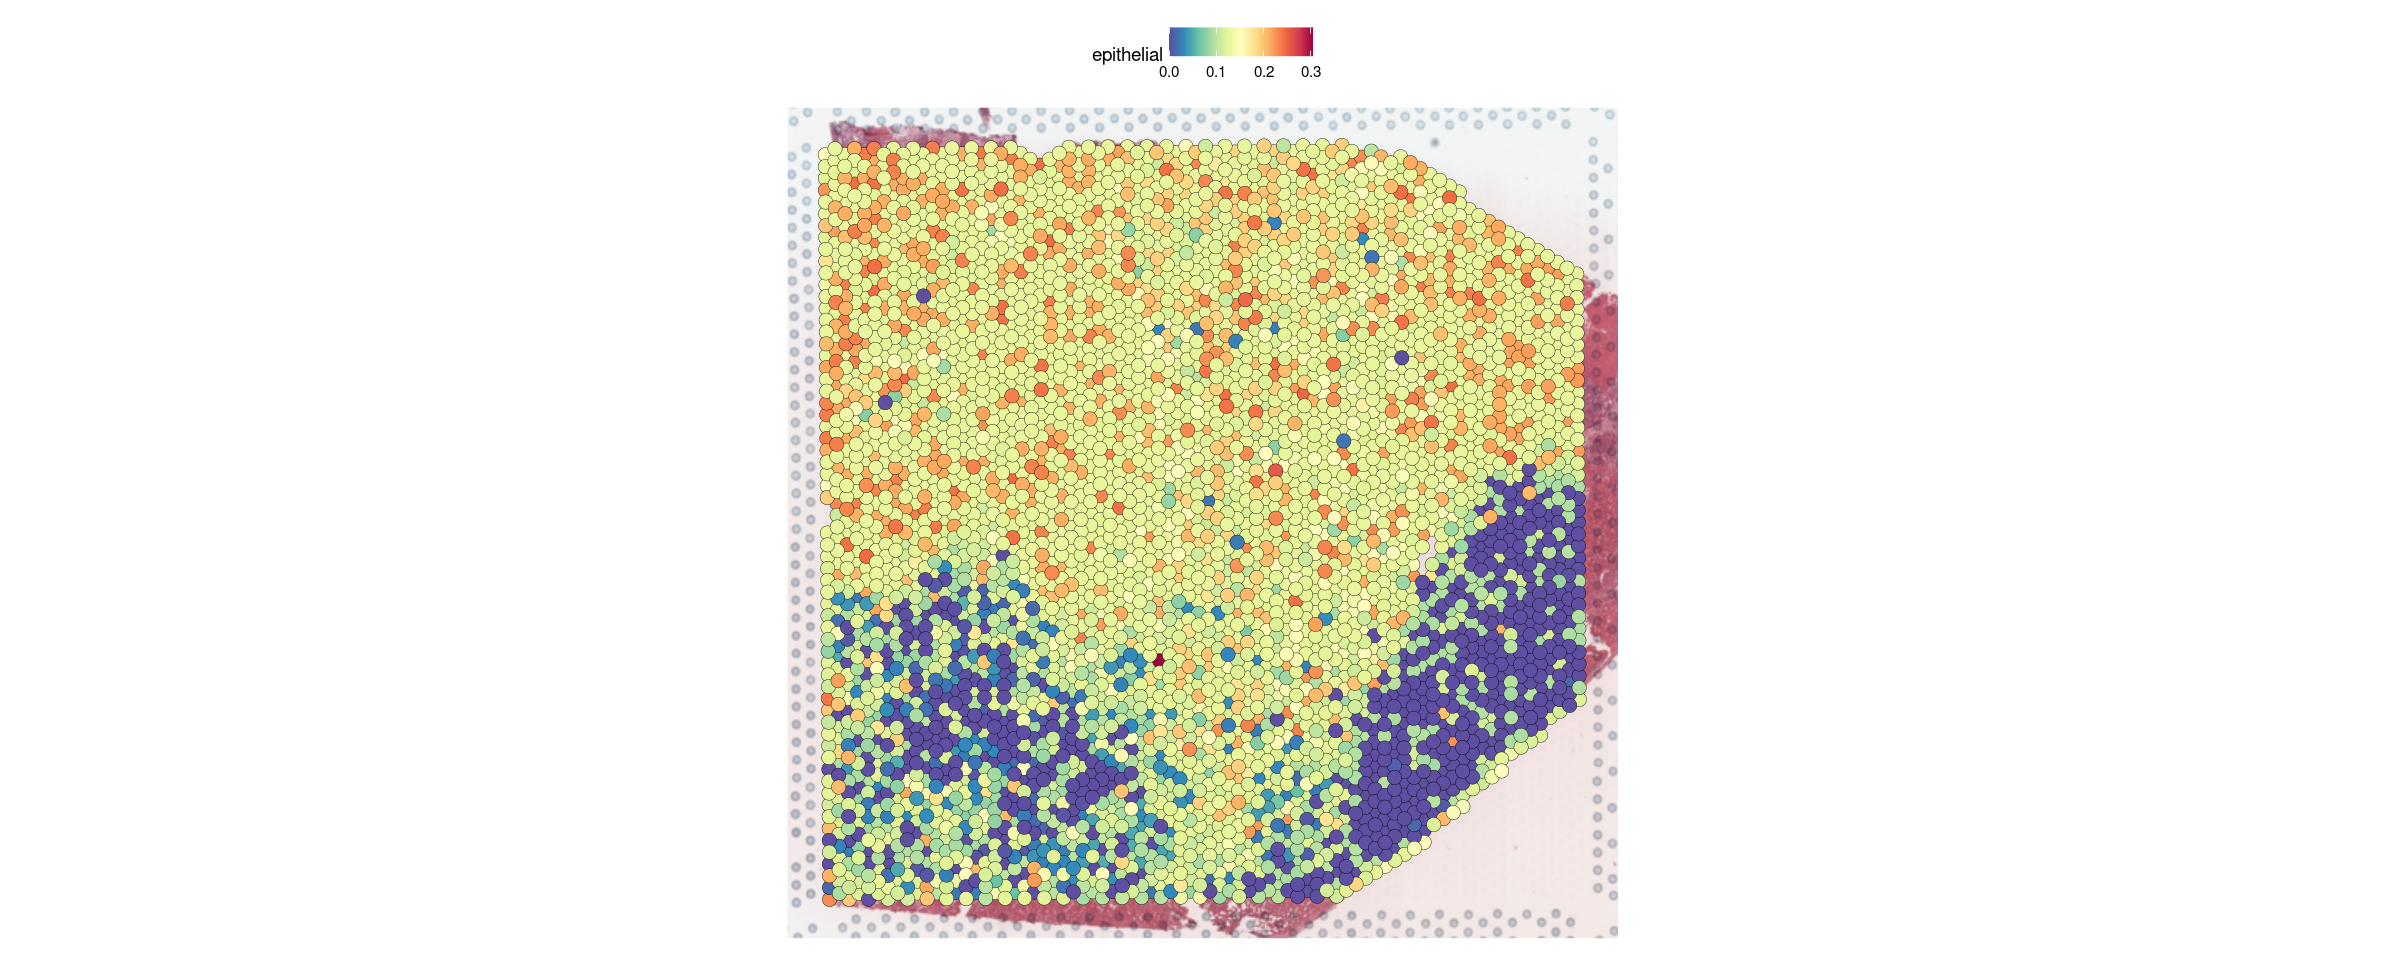

In [31]:
SpatialFeaturePlot(obj.ST, features = "epithelial") # 会报和FeaturePlot一样的错

## Identify non-immune cell

In [ ]:
## 首先是要分tissue定义epithelial cell， 然后再找到Endothelial，LSEC等类型

In [33]:
library(Seurat)
library(dplyr)

In [35]:
seuobj <- readRDS(paste0(dir2,"metastasis.final.rds"))
seuobj

An object of class Seurat 
64751 features across 460337 samples within 3 assays 
Active assay: RNA (33538 features, 0 variable features)
 2 other assays present: SCT, integrated
 2 dimensional reductions calculated: pca, umap

In [40]:
rm(seuobj)

### find epithelial

In [ ]:
# obj <- subset(seuobj, group == "HM" & major_cluster == "Epithelial")
# Idents(obj) <- "tissue"
# DefaultAssay(obj) <- "RNA"
# top.markers <- FindAllMarkers(obj, min.pct=0.1, logfc.threshold=0.1,
#                               return.thresh=0.1, only.pos=FALSE) ## return.thresh=0.01, test.use="wilcox"
# top.markers$pct.diff <- top.markers$pct.1 - top.markers$pct.2
# top.markers$name <- obj@misc$geneName[top.markers$gene]
# saveRDS(top.markers, file=paste0(dir2,"DEG/Epithelial_HM_DEG.rds")

In [ ]:
# pid:273591, compbio3, 2025/1/16/10:53

### find other celltype

In [ ]:
# 要在major_cluster层面找到Endothelial,LSEC,myCAF,pericyte等其他non_immune celltype

In [ ]:
obj <- subset(seuobj, major_cluster %in% c("apCAF","iCAF","myCAF","Fibroblast","LSEC","Endothelial",
                   "Melanocyte","Pericyte","Photoreceptor","Acinar","Endocrine","Hepatocyte"))
Idents(obj) <- "major_cluster"
DefaultAssay(obj) <- "RNA"
top.markers <- FindAllMarkers(obj, min.pct=0.1, logfc.threshold=0.1,
                              return.thresh=0.1, only.pos=FALSE) ## return.thresh=0.01, test.use="wilcox"
top.markers$pct.diff <- top.markers$pct.1 - top.markers$pct.2
top.markers$name <- obj@misc$geneName[top.markers$gene]
saveRDS(top.markers, file=paste0(dir2,"DEG/Non_immune_cell_except_Epithelial_DEG.rds")

In [ ]:
# pid:276944, compbio3, 2015/1/16/10:54

## Score celltype(UCell)

In [60]:
library(UCell)

In [ ]:
## 获得我关注的细胞类型的DEG集，然后用AUCell对obj.ST打分

以下是批量生成：

In [ ]:
## 应该这样，每个癌症有不同的关注点：
## Pancreas相关的要看Macrophage(3个亚群),epithelial,endothelial,myCAF,pericyte.
## Intestine相关的要看Treg（2个亚群），CD8Tex，Th1_GADD45B,CD4T_CXCR4
## Mammary相关的要看NK_GNLY，NK_NKG7，NK_KLRF1,NK_CD7,cDC1,Endothelial

### Pancreas

In [411]:
# 为pancreas跑：
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("PDAC"),]
need.list

Category   Type Project   Sample                         SampleID    
34 胰腺导管癌 PDAC GSE272362 GSM8399453_S13_Sample4_F1_Blk  IU_PDA_HM2_2
35 胰腺导管癌 PDAC GSE272362 GSM8399454_S13_Sample5_F1_Blu  IU_PDA_HM2  
36 胰腺导管癌 PDAC GSE272362 GSM8399455_S14_Sample6_A1      IU_PDA_HM3  
37 胰腺导管癌 PDAC GSE272362 GSM8399457_S17_Sample8_A1      IU_PDA_HM4  
38 胰腺导管癌 PDAC GSE272362 GSM8399459_S18_Sample10_A1     IU_PDA_HM5  
39 胰腺导管癌 PDAC GSE272362 GSM8399460_S18_Sample11_A1     IU_PDA_HM6  
40 胰腺导管癌 PDAC GSE272362 GSM8399464_S20_Sample15_A1     IU_PDA_HM8  
41 胰腺导管癌 PDAC GSE272362 GSM8399468_S20_Sample19_D2     IU_PDA_HM9  
42 胰腺导管癌 PDAC GSE272362 GSM8399469_S21_Sample20_A1     IU_PDA_HM10 
43 胰腺导管癌 PDAC GSE272362 GSM8399473_S21_Sample24_E3     IU_PDA_HM11 
44 胰腺导管癌 PDAC GSE272362 GSM8399476_S21_Sample27_A1     IU_PDA_HM12 
45 胰腺导管癌 PDAC GSE272362 GSM8399479_S22_Sample30_C2_Blu IU_PDA_HM13 
   SampleID2         Cluster
34 S13-16408_F1(Blk) CP1    
35 S13-16408_F1(Blu) CP1    
36 S14-8805_A1       CP1    
37 S17-19380_A1      CP2    
38 S18-24418_A1      CP2    
39 S18-27094_A1      CP1    
40 S20-11446_A1      CP1    
41 S20-19254_D2      CP2    
42 S21-15512 _A1     CP1    
43 S21-23955_E3      CP2    
44 S21-26075_A1      CP1    
45 S22-1570_C2 Blu   CP2

In [412]:
## Pancreas在CP1\2中，所以感兴趣的细胞类型是
celltype.need <- c("Mac_SPP1","Mac_STMN1","Mac_AIF1","Mac_C1QB","Mac_CCL18","Mac_VSIG4",
                   "Mac_CCL3","Mac_GPR183","Mac_MT1G","Mono_IL1B",
                   "Epithelial","Endothelial","Pericyte","myCAF")

In [426]:
marker.list <- list()
log2FC = 0.5
num = 500
for (i in celltype.need){
    if(i %in% c("Mac_SPP1","Mac_STMN1","Mac_AIF1","Mac_C1QB","Mac_CCL18","Mac_VSIG4",
               "Mac_CCL3","Mac_GPR183","Mac_MT1G","Mono_IL1B")){
        all_dmarker <- readRDS(paste0(dir2,"DEG/macro_mono_DEG.rds"))
        df <- filter(all_dmarker, cluster == i & avg_log2FC > log2FC & p_val_adj < 0.0001) %>% slice_max(avg_log2FC,n=num)
        marker.list[i] <- list(df$gene)
    }else if(i %in% c("Epithelial")){
        all_dmarker <- readRDS(paste0(dir2,"DEG/Epithelial_HM_DEG.rds"))
        df <- filter(all_dmarker, cluster == "Pancreas" & avg_log2FC > log2FC & p_val_adj < 0.0001) %>% slice_max(avg_log2FC,n=num)
        marker.list[i] <- list(union(df$name,c("EPCAM","KRT18","CD24","KRT19","PAX8","SCGB2A2","KRT5","KRT15")))
    }else if(i %in% c("Endothelial","Pericyte","myCAF")){
        all_dmarker <- readRDS(paste0(dir2,"DEG/Non_immune_cell_except_Epithelial_DEG.rds")) 
        df <- filter(all_dmarker, cluster == i & avg_log2FC > log2FC & p_val_adj < 0.0001) %>% slice_max(avg_log2FC,n=num)
        if(i == "Endothelial"){
            marker.list[i] <- list(union(df$name, c("CLDN5","PECAM1","VWF","FLT1","RAMP2")))
        }else if(i == "Pericyte"){
            marker.list[i] <- list(union(df$name, c("NOTCH3","CD146","RGS5")))
        }else if(i == "myCAF"){
            marker.list[i] <- list(union(df$name, c("RGS5","ACTA2","TAGLN")))
        }
    }
}
str(marker.list)

List of 14
 $ Mac_SPP1   : chr [1:89] "SPP1" "MMP12" "CCL20" "MMP9" ...
 $ Mac_STMN1  : chr [1:289] "STMN1" "HIST1H4C" "TUBB" "HMGB2" ...
 $ Mac_AIF1   : chr [1:96] "CLPS" "PRSS1" "PRSS2" "REG1A" ...
 $ Mac_C1QB   : chr [1:91] "APOA2" "RNASE1" "LGMN" "APOE" ...
 $ Mac_CCL18  : chr [1:120] "CCL18" "SFTPC" "FABP4" "GCHFR" ...
 $ Mac_VSIG4  : chr [1:263] "FBP1" "MCEMP1" "INHBA" "CHIT1" ...
 $ Mac_CCL3   : chr [1:148] "CCL4L2" "CCL4" "CCL3L1" "CCL3" ...
 $ Mac_GPR183 : chr [1:82] "CLEC10A" "CXCL10" "CD1E" "HLA-DRB5" ...
 $ Mac_MT1G   : chr [1:44] "MT1G" "MT1X" "MT1H" "MT2A" ...
 $ Mono_IL1B  : chr [1:242] "EREG" "TIMP1" "THBS1" "FCN1" ...
 $ Epithelial : chr [1:505] "REG1A" "TFF1" "PRSS1" "TFF2" ...
 $ Endothelial: chr [1:500] "PLVAP" "CLDN5" "PECAM1" "VWF" ...
 $ Pericyte   : chr [1:399] "RGS5" "ACTA2" "TAGLN" "NDUFA4L2" ...
 $ myCAF      : chr [1:414] "COL1A1" "COL1A2" "COL3A1" "MMP11" ...


In [ ]:
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        obj.ST <- AddModuleScore_UCell(obj.ST, features = marker.list, assay = "SCT",name = NULL, ncores = 4)
#         write.csv(obj.ST@meta.data, file = paste0(dir,"/celltype_score_Ucell.csv"))
        write.csv(obj.ST@meta.data, file = paste0(dir,"/celltype_score_Ucell_top500_0.5FC.csv"))
    }
}

#### single celltype - colored

In [391]:
library(imager)

In [427]:
## Pancreas在CP1\2中，所以感兴趣的细胞类型是
celltype.need <- c("Mac_SPP1","Mac_STMN1","Mac_AIF1","Mac_C1QB","Mac_CCL18","Mac_VSIG4",
                   "Mac_CCL3","Mac_GPR183","Mac_MT1G","Mono_IL1B",
                   "Epithelial","Endothelial","Pericyte","myCAF")

In [428]:
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        ## 获得打分数据
#         obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell.csv"),row.names=1) %>%
        obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell_top500_0.5FC.csv"),row.names=1) %>%
                                dplyr::select(c(celltype.need))
        metadata_ds <- data.frame(obj.ST@meta.data)
        colnames(metadata_ds) <- colnames(obj.ST@meta.data)
        ## 提取metadata以便打分分数与空间坐标合并
        metadata_ds <- metadata_ds %>% tibble::rownames_to_column("barcodeID") %>%
                    dplyr::mutate(rsum = base::rowSums(.[, celltype.need,drop = FALSE])) %>% 
                    dplyr::filter(rsum != 0) %>%
                    dplyr::select("barcodeID") %>% dplyr::left_join(metadata_ds %>%
                    tibble::rownames_to_column("barcodeID"), by = "barcodeID") %>%
                    tibble::column_to_rownames("barcodeID")
        slice <- names(obj.ST@images)[1]
        cell_types_all <- intersect(colnames(metadata_ds),celltype.need)
        # 提取空间坐标
        spatial_coord <- data.frame(obj.ST@images[[slice]]@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% 
        dplyr::mutate(imagerow_scaled = imagerow * obj.ST@images[[slice]]@scale.factors$lowres, 
                      imagecol_scaled = imagecol * obj.ST@images[[slice]]@scale.factors$lowres) %>% 
        dplyr::inner_join(metadata_ds %>% tibble::rownames_to_column("barcodeID"), by = "barcodeID")
        ## 读取切片
        img <- png::readPNG(paste0(dir,"/spatial/tissue_lowres_image.png"))
        ## 调整切片的饱和度
        if (length(dim(img)) == 3) { 
          gray_values <- 0.299 * img[,,1] + 0.587 * img[,,2] + 0.114 * img[,,3]
          saturation_factor <- 0.2  # 设置饱和度降低的比例（0 表示完全灰度化，1 表示原图）,比如设置为 50% 的饱和度
          desaturated_img <- img
          desaturated_img[,,1] <- img[,,1] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,2] <- img[,,2] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,3] <- img[,,3] * saturation_factor + gray_values * (1 - saturation_factor)
        } else {
          stop("图片不是 RGB 格式，无法调整饱和度！")
        }
        img_grob <- grid::rasterGrob(desaturated_img, interpolate = FALSE, width = grid::unit(1,"npc"), height = grid::unit(1, "npc"))
        ## 获取最高表达的细胞
        col_means <- colMeans(spatial_coord[,c(cell_types_all)])
        # 识别最大细胞
        spatial_coord$max <- apply(X = spatial_coord[,c(cell_types_all)], MARGIN = 1, FUN = function(x){
                                            max_col <- names(x)[which.max(x)]
                                            return(max_col)})    
#         # 识别最大细胞是否大于其平均值
#         obj.ST@meta.data$celltype <- apply(X = obj.ST@meta.data[4:(3+length(celltype.need))], MARGIN = 1, FUN = function(x){
#                                                 max_col <- names(x)[which.max(x)]
#                                                 if(x[which.max(x)] > col_means[max_col]){
#                                                     return(max_col)}else{return("others")}
#                                             })
        
        ## 开始画图
        plot.list <- lapply(X = celltype.need, FUN = function(x){
            cell <- x
            Max = max(spatial_coord[,cell],na.rm = TRUE)
            spatial_coord[,cell] = spatial_coord[,cell]/Max
            scatterpie_plt <- ggplot2::ggplot() + 
                        ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                                      size = get(cell), color = get(cell))) + 
                        scale_color_gradientn(colours = colorspace::sequential_hcl(n = 8, palette = "Inferno"))+
                        ggplot2::scale_y_reverse() + 
                        ggplot2::ylim(nrow(img),0) +
                        ggplot2::xlim(0, ncol(img)) + 
                        cowplot::theme_half_open(11, rel_small = 1) + 
                        ggplot2::theme_void() + 
                        ggplot2::coord_fixed(ratio = 1, xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") +
                        ggplot2::scale_size_continuous(range=c(0,1))+
                        labs(size = cell)      
                        })
        pdf(paste0(dir2,"Figure/spatial/",project,"_",sample,"_all_celltype_in_Pancreas_dot.pdf"),width = 30,height = 30)
        print(cowplot::plot_grid(plotlist = plot.list, align = "h", ncol = 4))
        dev.off()
        
    }
}

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

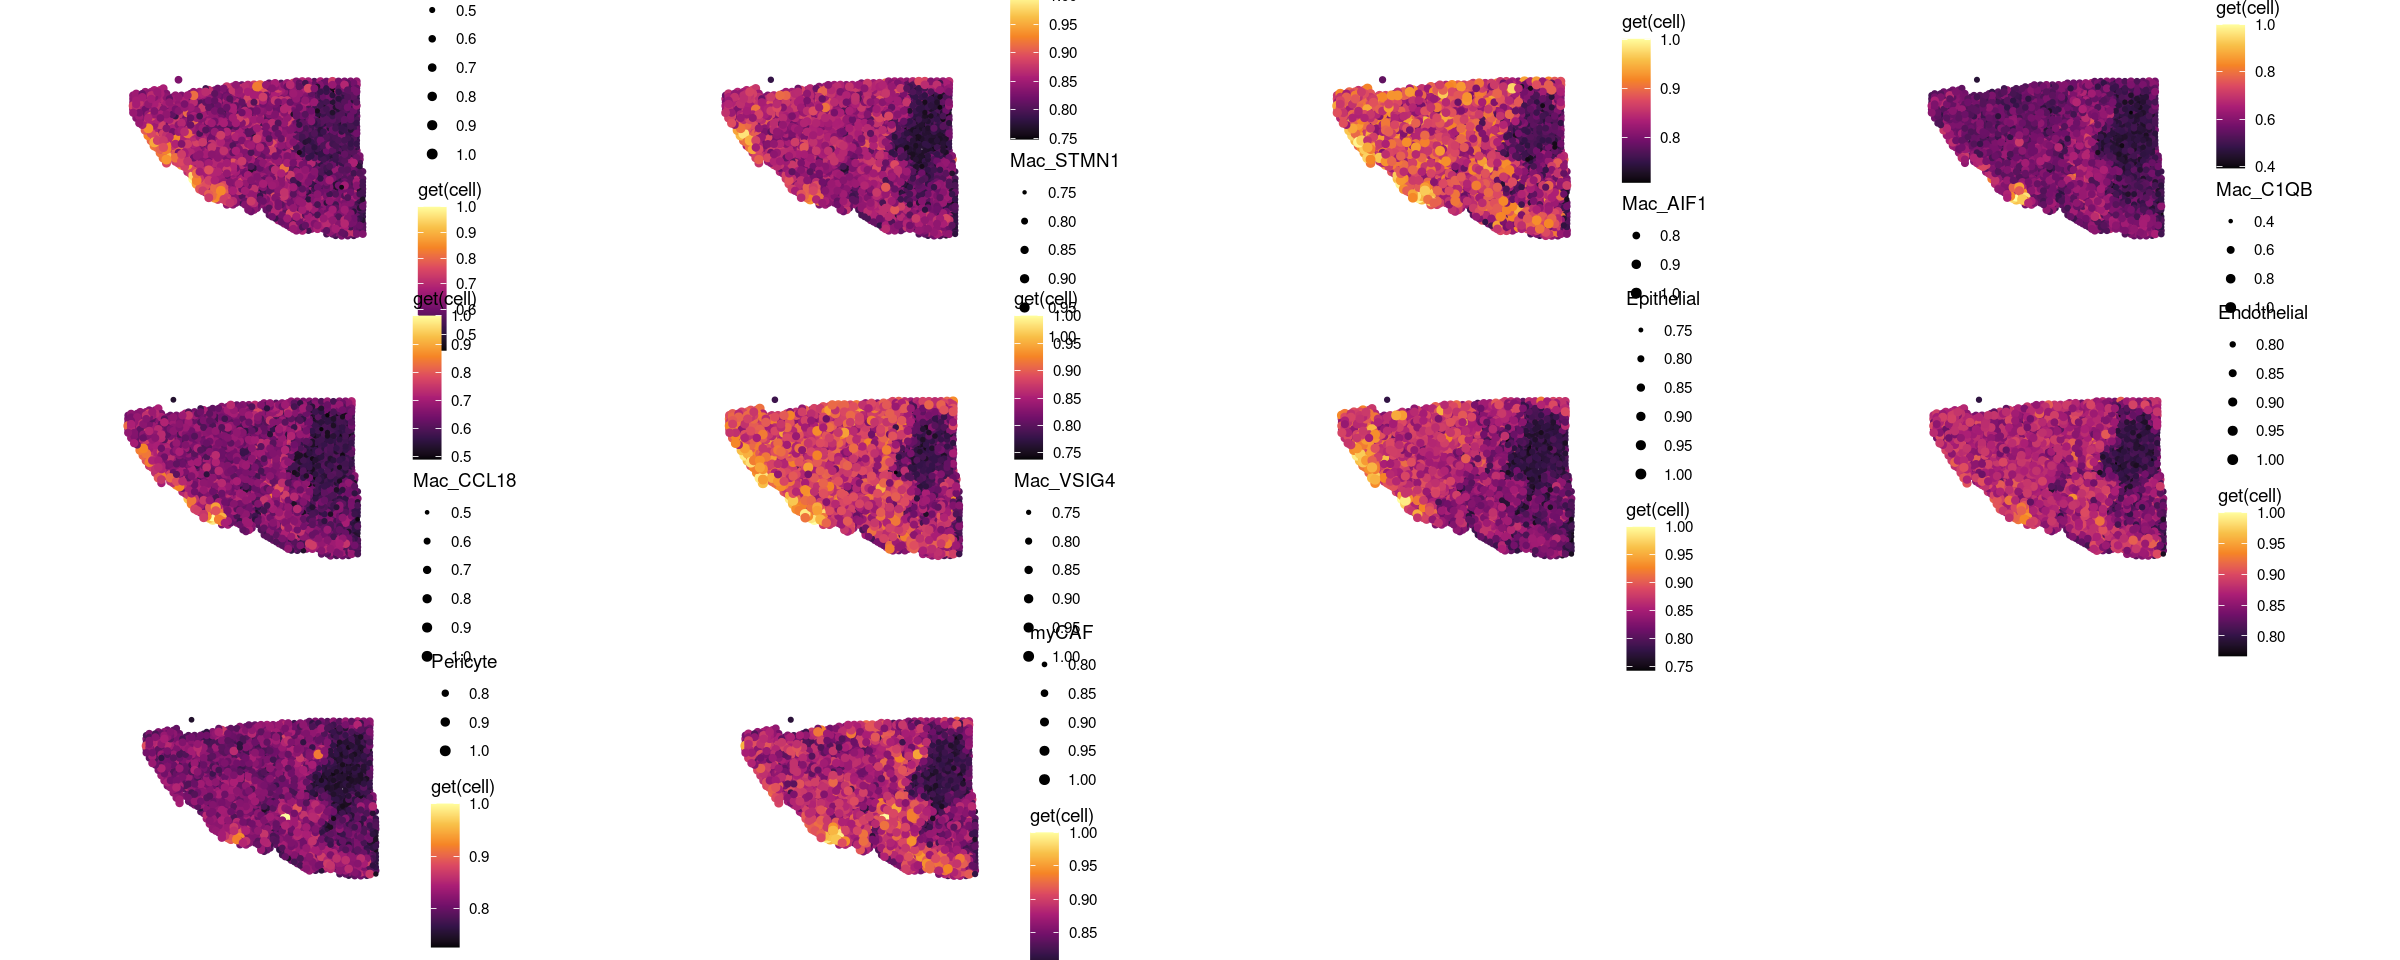

In [298]:
cowplot::plot_grid(plotlist = plot.list, align = "h", ncol = 4)

#### single celltype colored (final)

以下是CP1的：

In [453]:
# 为pancreas跑：
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("PDAC") & datalist$Cluster == "CP1",]
need.list

Category   Type Project   Sample                         SampleID    
34 胰腺导管癌 PDAC GSE272362 GSM8399453_S13_Sample4_F1_Blk  IU_PDA_HM2_2
36 胰腺导管癌 PDAC GSE272362 GSM8399455_S14_Sample6_A1      IU_PDA_HM3  
39 胰腺导管癌 PDAC GSE272362 GSM8399460_S18_Sample11_A1     IU_PDA_HM6  
40 胰腺导管癌 PDAC GSE272362 GSM8399464_S20_Sample15_A1     IU_PDA_HM8  
42 胰腺导管癌 PDAC GSE272362 GSM8399469_S21_Sample20_A1     IU_PDA_HM10 
45 胰腺导管癌 PDAC GSE272362 GSM8399479_S22_Sample30_C2_Blu IU_PDA_HM13 
   SampleID2         Cluster
34 S13-16408_F1(Blk) CP1    
36 S14-8805_A1       CP1    
39 S18-27094_A1      CP1    
40 S20-11446_A1      CP1    
42 S21-15512 _A1     CP1    
45 S22-1570_C2 Blu   CP1

In [454]:
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    celltype.need <- c("Mac_SPP1","Mac_STMN1","Mac_AIF1","Mac_CCL18",
#                        "Mac_VSIG4","Mac_C1QB",
               "Epithelial","Endothelial","Pericyte","myCAF")
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        ## 获得打分数据
        obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell_top500_0.5FC.csv"),row.names=1) %>%
                                dplyr::select(c(celltype.need))
        metadata_ds <- data.frame(obj.ST@meta.data)
        colnames(metadata_ds) <- colnames(obj.ST@meta.data)
        ## 提取metadata以便打分分数与空间坐标合并
        metadata_ds <- metadata_ds %>% tibble::rownames_to_column("barcodeID") %>%
                    dplyr::mutate(rsum = base::rowSums(.[, celltype.need,drop = FALSE])) %>% 
                    dplyr::filter(rsum != 0) %>%
                    dplyr::select("barcodeID") %>% dplyr::left_join(metadata_ds %>%
                    tibble::rownames_to_column("barcodeID"), by = "barcodeID") %>%
                    tibble::column_to_rownames("barcodeID")
        slice <- names(obj.ST@images)[1]
        cell_types_all <- intersect(colnames(metadata_ds),celltype.need)
        # 提取空间坐标
        spatial_coord <- data.frame(obj.ST@images[[slice]]@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% 
        dplyr::mutate(imagerow_scaled = imagerow * obj.ST@images[[slice]]@scale.factors$lowres, 
                      imagecol_scaled = imagecol * obj.ST@images[[slice]]@scale.factors$lowres) %>% 
        dplyr::inner_join(metadata_ds %>% tibble::rownames_to_column("barcodeID"), by = "barcodeID")
        ## 读取切片
        img <- png::readPNG(paste0(dir,"/spatial/tissue_lowres_image.png"))
        ## 调整切片的饱和度
        if (length(dim(img)) == 3) { 
          gray_values <- 0.299 * img[,,1] + 0.587 * img[,,2] + 0.114 * img[,,3]
          saturation_factor <- 0.5  # 设置饱和度降低的比例（0 表示完全灰度化，1 表示原图）,比如设置为 50% 的饱和度
          desaturated_img <- img
          desaturated_img[,,1] <- img[,,1] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,2] <- img[,,2] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,3] <- img[,,3] * saturation_factor + gray_values * (1 - saturation_factor)
        } else {
          stop("图片不是 RGB 格式，无法调整饱和度！")
        }
        img_grob <- grid::rasterGrob(desaturated_img, interpolate = FALSE, width = grid::unit(1,"npc"), height = grid::unit(1, "npc"))
        ## 获取最高表达的细胞
        col_means <- colMeans(spatial_coord[,c(cell_types_all)])
        # 识别最大细胞
        spatial_coord$max <- apply(X = spatial_coord[,c(cell_types_all)], MARGIN = 1, FUN = function(x){
                                            max_col <- names(x)[which.max(x)]
                                            return(max_col)})    
#         # 识别最大细胞是否大于其平均值
#         obj.ST@meta.data$celltype <- apply(X = obj.ST@meta.data[4:(3+length(celltype.need))], MARGIN = 1, FUN = function(x){
#                                                 max_col <- names(x)[which.max(x)]
#                                                 if(x[which.max(x)] > col_means[max_col]){
#                                                     return(max_col)}else{return("others")}
#                                             })
        
        ## 开始画图
        plot.list <- lapply(X = celltype.need, FUN = function(x){
            cell <- x
            Max = max(spatial_coord[,cell],na.rm = TRUE)
            spatial_coord[,cell] = spatial_coord[,cell]/Max
            scatterpie_plt <- ggplot2::ggplot() + 
                        ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                                      size = get(cell), color = get(cell))) + 
                        scale_color_gradientn(colours = colorspace::sequential_hcl(n = 8, palette = "Inferno"), 
                                              values = c(0,0.3,0.5,0.6,0.7,0.8,1))+
                        ggplot2::scale_y_reverse() + 
                        ggplot2::ylim(nrow(img),0) +
                        ggplot2::xlim(0, ncol(img)) + 
                        cowplot::theme_half_open(11, rel_small = 1) + 
                        ggplot2::theme_void() + 
                        ggplot2::coord_fixed(ratio = 1, xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") +
                        ggplot2::scale_size_continuous(range=c(0,0.5))+
                        labs(size = cell)+
                        theme(legend.position = "none",
                              plot.title = element_text(hjust = 0.5, vjust = 0, size = 15),
                              plot.margin = margin(t = 0, r = 0, b = 0, l = 0))+
                        ggtitle(label = cell)
                        })
        pdf(paste0(dir2,"Figure/spatial/CP1/",project,"_",sample,"_all_celltype_in_Pancreas_dot_final.pdf"),width = 8,height = 5)
        print(cowplot::plot_grid(plotlist = plot.list, align = "h", ncol = 4))
        dev.off()
        
    }
}

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 1091 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1091 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1091 rows containing

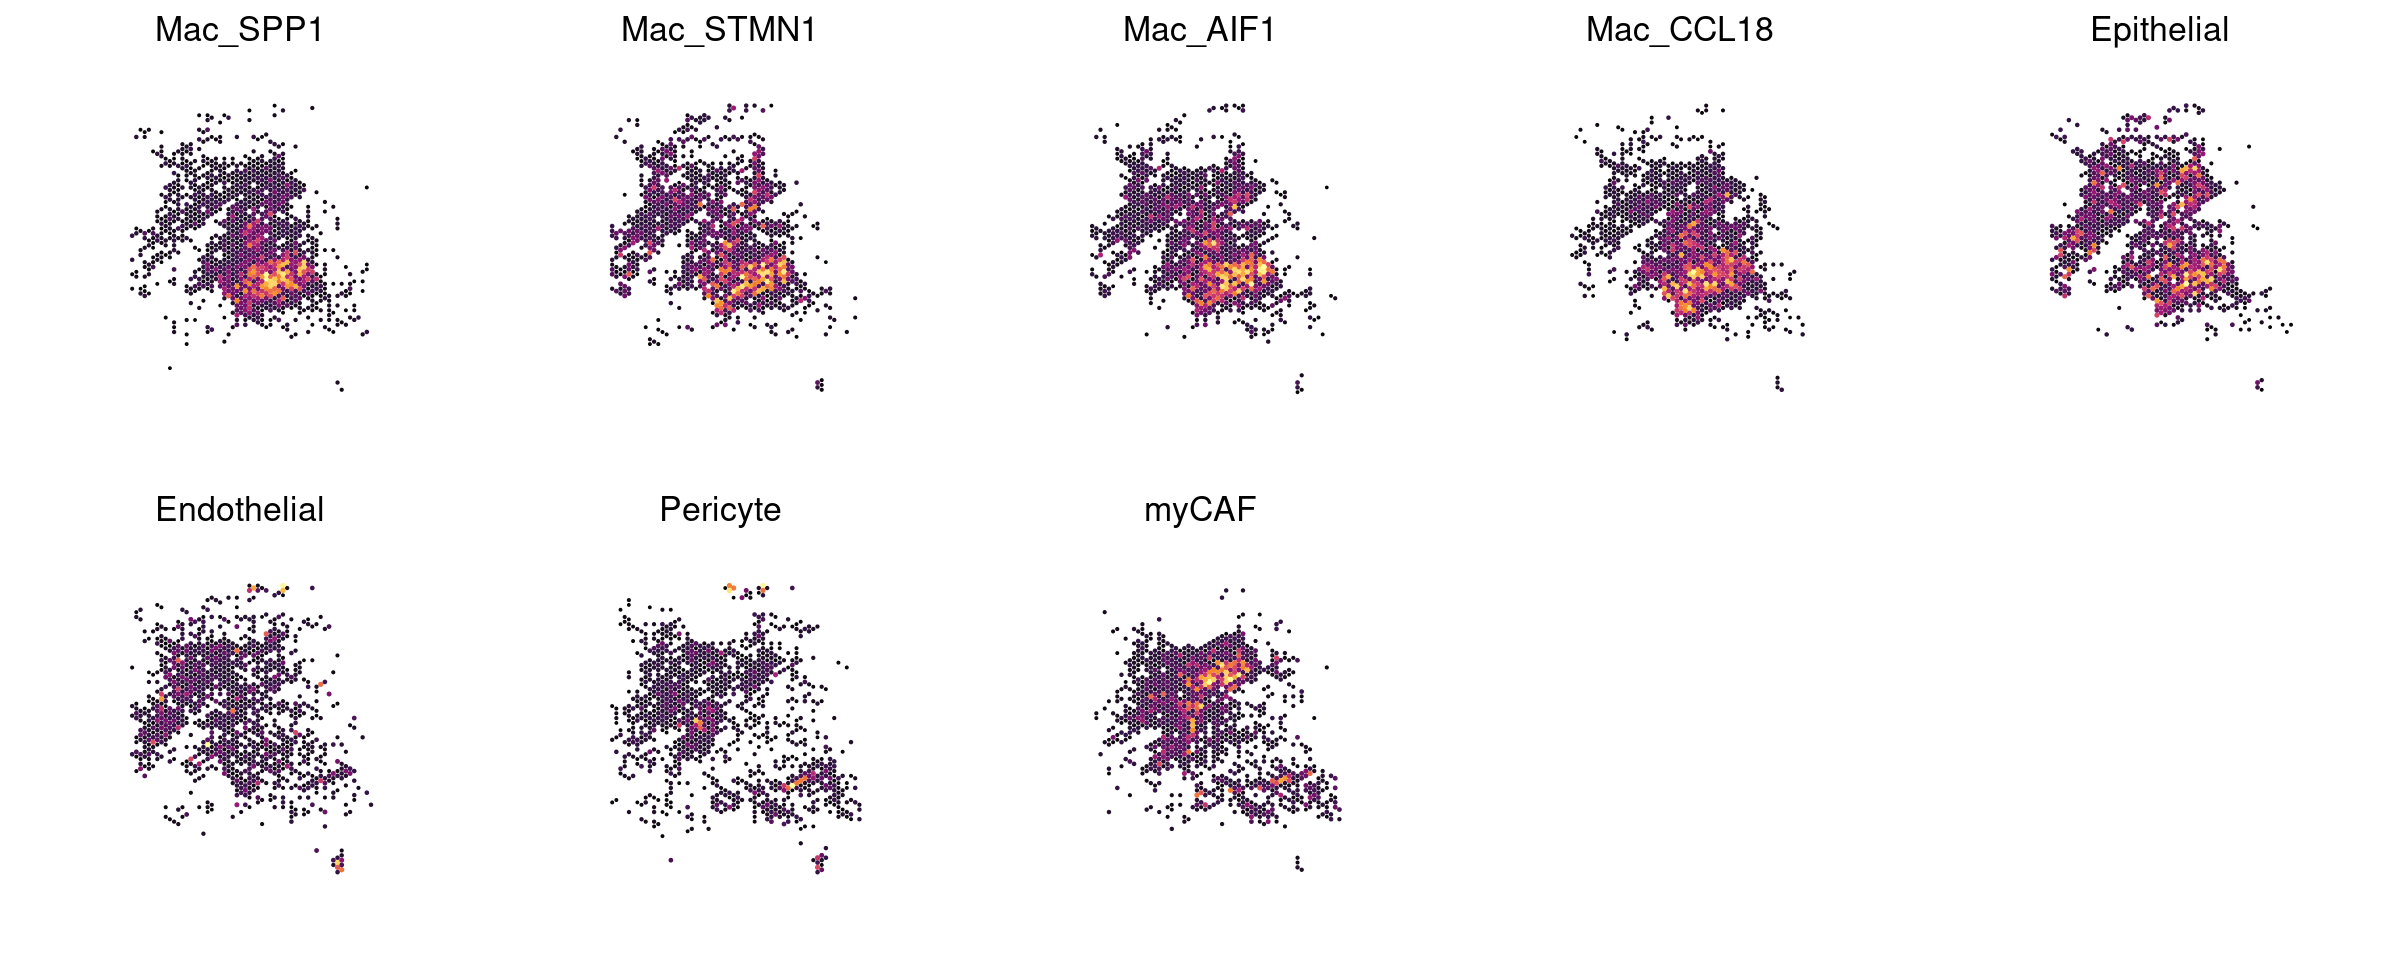

In [452]:
        plot.list <- lapply(X = celltype.need, FUN = function(x){
            cell <- x
            Max = max(spatial_coord[,cell],na.rm = TRUE)
            spatial_coord[,cell] = spatial_coord[,cell]/Max
            scatterpie_plt <- ggplot2::ggplot() + 
                        ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                                      size = get(cell), color = get(cell))) + 
                        scale_color_gradientn(colours = colorspace::sequential_hcl(n = 8, palette = "Inferno"), 
                                              values = c(0,0.3,0.5,0.6,0.7,0.8,1))+
                        ggplot2::scale_y_reverse() + 
                        ggplot2::ylim(nrow(img),0) +
                        ggplot2::xlim(0, ncol(img)) + 
                        cowplot::theme_half_open(11, rel_small = 1) + 
                        ggplot2::theme_void() + 
                        ggplot2::coord_fixed(ratio = 1, xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") +
                        ggplot2::scale_size_continuous(range=c(0,0.5))+
                        labs(size = cell)+
                        theme(legend.position = "none",
                              plot.title = element_text(hjust = 0.5, vjust = 0, size = 20),
                              plot.margin = margin(t = 0, r = 0, b = 0, l = 0))+
                        ggtitle(label = cell)
                        })
print(cowplot::plot_grid(plotlist = plot.list, align = "h", ncol = 5))

以下是CP2的：

In [458]:
# 为pancreas跑：
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("PDAC") & datalist$Cluster == "CP2",]
dim(need.list)

[1] 6 7

In [459]:
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    celltype.need <- c("Mac_CCL3","Mac_GPR183","Mac_MT1G","Mono_IL1B",
                       "Epithelial","Endothelial","Pericyte","myCAF")
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        ## 获得打分数据
        obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell_top500_0.5FC.csv"),row.names=1) %>%
                                dplyr::select(c(celltype.need))
        metadata_ds <- data.frame(obj.ST@meta.data)
        colnames(metadata_ds) <- colnames(obj.ST@meta.data)
        ## 提取metadata以便打分分数与空间坐标合并
        metadata_ds <- metadata_ds %>% tibble::rownames_to_column("barcodeID") %>%
                    dplyr::mutate(rsum = base::rowSums(.[, celltype.need,drop = FALSE])) %>% 
                    dplyr::filter(rsum != 0) %>%
                    dplyr::select("barcodeID") %>% dplyr::left_join(metadata_ds %>%
                    tibble::rownames_to_column("barcodeID"), by = "barcodeID") %>%
                    tibble::column_to_rownames("barcodeID")
        slice <- names(obj.ST@images)[1]
        cell_types_all <- intersect(colnames(metadata_ds),celltype.need)
        # 提取空间坐标
        spatial_coord <- data.frame(obj.ST@images[[slice]]@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% 
        dplyr::mutate(imagerow_scaled = imagerow * obj.ST@images[[slice]]@scale.factors$lowres, 
                      imagecol_scaled = imagecol * obj.ST@images[[slice]]@scale.factors$lowres) %>% 
        dplyr::inner_join(metadata_ds %>% tibble::rownames_to_column("barcodeID"), by = "barcodeID")
        ## 读取切片
        img <- png::readPNG(paste0(dir,"/spatial/tissue_lowres_image.png"))
        ## 调整切片的饱和度
        if (length(dim(img)) == 3) { 
          gray_values <- 0.299 * img[,,1] + 0.587 * img[,,2] + 0.114 * img[,,3]
          saturation_factor <- 0.5  # 设置饱和度降低的比例（0 表示完全灰度化，1 表示原图）,比如设置为 50% 的饱和度
          desaturated_img <- img
          desaturated_img[,,1] <- img[,,1] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,2] <- img[,,2] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,3] <- img[,,3] * saturation_factor + gray_values * (1 - saturation_factor)
        } else {
          stop("图片不是 RGB 格式，无法调整饱和度！")
        }
        img_grob <- grid::rasterGrob(desaturated_img, interpolate = FALSE, width = grid::unit(1,"npc"), height = grid::unit(1, "npc"))
        ## 获取最高表达的细胞
        col_means <- colMeans(spatial_coord[,c(cell_types_all)])
        # 识别最大细胞
        spatial_coord$max <- apply(X = spatial_coord[,c(cell_types_all)], MARGIN = 1, FUN = function(x){
                                            max_col <- names(x)[which.max(x)]
                                            return(max_col)})    
#         # 识别最大细胞是否大于其平均值
#         obj.ST@meta.data$celltype <- apply(X = obj.ST@meta.data[4:(3+length(celltype.need))], MARGIN = 1, FUN = function(x){
#                                                 max_col <- names(x)[which.max(x)]
#                                                 if(x[which.max(x)] > col_means[max_col]){
#                                                     return(max_col)}else{return("others")}
#                                             })
        
        ## 开始画图
        plot.list <- lapply(X = celltype.need, FUN = function(x){
            cell <- x
            Max = max(spatial_coord[,cell],na.rm = TRUE)
            spatial_coord[,cell] = spatial_coord[,cell]/Max
            scatterpie_plt <- ggplot2::ggplot() + 
                        ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                                      size = get(cell), color = get(cell))) + 
                        scale_color_gradientn(colours = colorspace::sequential_hcl(n = 8, palette = "Inferno"), 
                                              values = c(0,0.3,0.5,0.6,0.7,0.8,1))+
                        ggplot2::scale_y_reverse() + 
                        ggplot2::ylim(nrow(img),0) +
                        ggplot2::xlim(0, ncol(img)) + 
                        cowplot::theme_half_open(11, rel_small = 1) + 
                        ggplot2::theme_void() + 
                        ggplot2::coord_fixed(ratio = 1, xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") +
                        ggplot2::scale_size_continuous(range=c(0,0.5))+
                        labs(size = cell)+
                        theme(legend.position = "none",
                              plot.title = element_text(hjust = 0.5, vjust = 0, size = 15),
                              plot.margin = margin(t = 0, r = 0, b = 0, l = 0))+
                        ggtitle(label = cell)
                        })
        pdf(paste0(dir2,"Figure/spatial/CP2/",project,"_",sample,"_all_celltype_in_Pancreas_dot_final.pdf"),width = 8,height = 5)
        print(cowplot::plot_grid(plotlist = plot.list, align = "h", ncol = 4))
        dev.off()
        
    }
}

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

#### multi celltypes - colored

以下是CP1：

In [703]:
# 为pancreas跑：
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("PDAC") & datalist$Cluster == "CP1",]
need.list

Category   Type Project   Sample                         SampleID    
34 胰腺导管癌 PDAC GSE272362 GSM8399453_S13_Sample4_F1_Blk  IU_PDA_HM2_2
36 胰腺导管癌 PDAC GSE272362 GSM8399455_S14_Sample6_A1      IU_PDA_HM3  
39 胰腺导管癌 PDAC GSE272362 GSM8399460_S18_Sample11_A1     IU_PDA_HM6  
40 胰腺导管癌 PDAC GSE272362 GSM8399464_S20_Sample15_A1     IU_PDA_HM8  
42 胰腺导管癌 PDAC GSE272362 GSM8399469_S21_Sample20_A1     IU_PDA_HM10 
45 胰腺导管癌 PDAC GSE272362 GSM8399479_S22_Sample30_C2_Blu IU_PDA_HM13 
   SampleID2         Cluster Most.representitive.for.CP
34 S13-16408_F1(Blk) CP1                               
36 S14-8805_A1       CP1     CP1                       
39 S18-27094_A1      CP1                               
40 S20-11446_A1      CP1                               
42 S21-15512 _A1     CP1                               
45 S22-1570_C2 Blu   CP1

In [817]:
need.list <- datalist[datalist$Type %in% c("PDAC") & datalist$Cluster == "CP1",]
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    cluster <- need.list[need.list$Project == project & need.list$Sample == sample,]$Cluster
    celltype.need <- c("Mac_SPP1","Mac_STMN1","Mac_AIF1","Mac_CCL18",
#                        "Mac_C1QB","Mac_VSIG4",
               "Epithelial","Endothelial","Pericyte","myCAF")
    print(dir.exists(dir))
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        ## 获得打分数据
        obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell.csv"),row.names=1) %>%
                                dplyr::select(c(celltype.need))
        metadata_ds <- data.frame(obj.ST@meta.data)
        colnames(metadata_ds) <- colnames(obj.ST@meta.data)
        ## 提取metadata以便打分分数与空间坐标合并
        metadata_ds <- metadata_ds %>% tibble::rownames_to_column("barcodeID") %>%
                    dplyr::mutate(rsum = base::rowSums(.[, celltype.need,drop = FALSE])) %>% 
                    dplyr::filter(rsum != 0) %>%
                    dplyr::select("barcodeID") %>% dplyr::left_join(metadata_ds %>%
                    tibble::rownames_to_column("barcodeID"), by = "barcodeID") %>%
                    tibble::column_to_rownames("barcodeID")
        slice <- names(obj.ST@images)[1]
        cell_types_all <- intersect(colnames(metadata_ds),celltype.need)
        # 提取空间坐标
        spatial_coord <- data.frame(obj.ST@images[[slice]]@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% 
        dplyr::mutate(imagerow_scaled = imagerow * obj.ST@images[[slice]]@scale.factors$lowres, 
                      imagecol_scaled = imagecol * obj.ST@images[[slice]]@scale.factors$lowres) %>% 
        dplyr::inner_join(metadata_ds %>% tibble::rownames_to_column("barcodeID"), by = "barcodeID")
        ## 读取切片
        img <- png::readPNG(paste0(dir,"/spatial/tissue_lowres_image.png"))
        ## 调整切片的饱和度
        if (length(dim(img)) == 3) { 
          gray_values <- 0.299 * img[,,1] + 0.587 * img[,,2] + 0.114 * img[,,3]
          saturation_factor <- 0.3  # 设置饱和度降低的比例（0 表示完全灰度化，1 表示原图）,比如设置为 50% 的饱和度
          desaturated_img <- img
          desaturated_img[,,1] <- img[,,1] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,2] <- img[,,2] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,3] <- img[,,3] * saturation_factor + gray_values * (1 - saturation_factor)
        } else {
          stop("图片不是 RGB 格式，无法调整饱和度！")
        }
        img_grob <- grid::rasterGrob(desaturated_img, interpolate = FALSE, width = grid::unit(1,"npc"), height = grid::unit(1, "npc"))
        ## 获取最高表达的细胞
        col_means <- colMeans(spatial_coord[,c(cell_types_all)])
        # 识别最大细胞
        spatial_coord$max <- apply(X = spatial_coord[,c(cell_types_all)], MARGIN = 1, FUN = function(x){
                                            max_col <- names(x)[which.max(x)]
                                            return(max_col)})    
        # 删掉低于平均表达的值点
        for(cell in cell_types_all){
#             mean_value <- mean(spatial_coord[,cell])
            mean_value <- quantile(spatial_coord[,cell], probs = 0.5, na.rm = TRUE)
            spatial_coord[,cell][spatial_coord[,cell] < mean_value] <- NA
            print(table(is.na(spatial_coord[,cell])))
            
#             spatial_coord[, cell] <- lapply(cell, function(col_name) {
#               ## 对于那些有重复值的点位，只保留最高的那个值的颜色。
#               ifelse(spatial_coord$max != col_name, NA, spatial_coord[[col_name]])
#             })
        }
        cell_1 = 'Mac_SPP1'
        cell_2 = 'Mac_STMN1'
        cell_3 = 'Mac_AIF1'
#         cell_4 = 'Mac_C1QB'
        cell_5 = 'Mac_CCL18'
#         cell_6 = 'Mac_VSIG4'
        cell_7 = 'Epithelial'
        cell_8 = 'Endothelial'
        cell_9 = 'Pericyte'
        cell_10 = 'myCAF'
        Max_1 = max(spatial_coord[,cell_1],na.rm = TRUE)
        spatial_coord[,cell_1] = spatial_coord[,cell_1]/Max_1
        Max_2 = max(spatial_coord[,cell_2],na.rm = TRUE)
        spatial_coord[,cell_2] = spatial_coord[,cell_2]/Max_2
        Max_3 = max(spatial_coord[,cell_3],na.rm = TRUE)
        spatial_coord[,cell_3] = spatial_coord[,cell_3]/Max_3
#         Max_4 = max(spatial_coord[,cell_4],na.rm = TRUE)
#         spatial_coord[,cell_4] = spatial_coord[,cell_4]/Max_4
        Max_5 = max(spatial_coord[,cell_5],na.rm = TRUE)
        spatial_coord[,cell_5] = spatial_coord[,cell_5]/Max_5
#         Max_6 = max(spatial_coord[,cell_6],na.rm = TRUE)
#         spatial_coord[,cell_6] = spatial_coord[,cell_6]/Max_6
        Max_7 = max(spatial_coord[,cell_7],na.rm = TRUE)
        spatial_coord[,cell_7] = spatial_coord[,cell_7]/Max_7
        Max_8 = max(spatial_coord[,cell_8],na.rm = TRUE)
        spatial_coord[,cell_8] = spatial_coord[,cell_8]/Max_8
        Max_9 = max(spatial_coord[,cell_9],na.rm = TRUE)
        spatial_coord[,cell_9] = spatial_coord[,cell_9]/Max_9
        Max_10 = max(spatial_coord[,cell_10],na.rm = TRUE)
        spatial_coord[,cell_10] = spatial_coord[,cell_10]/Max_10

        scatterpie_plt <- ggplot2::ggplot() + 
                ggplot2::annotation_custom(grob = img_grob,xmin = 0, xmax = ncol(img), ymin = 0, ymax = -nrow(img))+
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_1),alpha = get(cell_1)), color = '#00FFFF') + # 颜色再换个炸裂的
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_2),alpha = get(cell_2)), color = '#00BFFF') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_3),alpha = get(cell_3)), color = '#7B68EE') +
#                 ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
#                                                               size = get(cell_4),alpha = get(cell_4)), color = '#F88A89') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_5),alpha = get(cell_5)), color = '#00FF00') +
#                 ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
#                                                               size = get(cell_6),alpha = get(cell_6)), color = '#70449D') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_7),alpha = get(cell_7)), color = '#f1ce63') +  
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_8),alpha = get(cell_8)), color = '#DC143C') +  
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_9),alpha = get(cell_9)), color = '#8B0000') +    
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_10),alpha = get(cell_10)), color = '#D2B48C') +   
                ggplot2::scale_y_reverse() + ggplot2::ylim(nrow(img),0) + 
                ggplot2::xlim(0, ncol(img)) + 
                cowplot::theme_half_open(11,rel_small = 1) + 
                ggplot2::theme_void() + 
                ggplot2::coord_fixed(ratio = 1,xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") +
                ggplot2::scale_size_continuous(range=c(0,2))+
                theme(legend.position = "none")+
                    labs(size = cell) + 
                guides(alpha = "none") 
                ggplot2::scale_alpha_continuous(range=c(0.5,1))
           
      
#         pdf(paste0(dir2,"Figure/spatial/CP1/",project,"_",sample,'_dot.pdf'),width = 8,height = 7)
#         print(scatterpie_plt)
#         dev.off()      
    }
}

[1] TRUE

FALSE  TRUE 
  480   479 

FALSE  TRUE 
  480   479 

FALSE  TRUE 
  480   479 

FALSE  TRUE 
  480   479 

FALSE  TRUE 
  480   479 

FALSE  TRUE 
  480   479 

FALSE  TRUE 
  480   479 

FALSE  TRUE 
  480   479 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
  588   588 

FALSE  TRUE 
  588   588 

FALSE  TRUE 
  588   588 

FALSE  TRUE 
  588   588 

FALSE  TRUE 
  588   588 

FALSE  TRUE 
  588   588 

FALSE  TRUE 
  588   588 

FALSE  TRUE 
  588   588 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
  833   833 

FALSE  TRUE 
  833   833 

FALSE  TRUE 
  833   833 

FALSE  TRUE 
  833   833 

FALSE  TRUE 
  833   833 

FALSE  TRUE 
  833   833 

FALSE  TRUE 
  833   833 

FALSE  TRUE 
  833   833 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
 2016  2016 

FALSE  TRUE 
 2016  2016 

FALSE  TRUE 
 2016  2016 

FALSE  TRUE 
 2016  2016 

FALSE  TRUE 
 2016  2016 

FALSE  TRUE 
 2016  2016 

FALSE  TRUE 
 2016  2016 

FALSE  TRUE 
 2016  2016 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
 1174  1174 

FALSE  TRUE 
 1174  1174 

FALSE  TRUE 
 1174  1174 

FALSE  TRUE 
 1174  1174 

FALSE  TRUE 
 1174  1174 

FALSE  TRUE 
 1174  1174 

FALSE  TRUE 
 1174  1174 

FALSE  TRUE 
 1174  1174 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
 1091  1091 

FALSE  TRUE 
 1091  1091 

FALSE  TRUE 
 1091  1091 

FALSE  TRUE 
 1091  1091 

FALSE  TRUE 
 1091  1091 

FALSE  TRUE 
 1091  1091 

FALSE  TRUE 
 1091  1091 

FALSE  TRUE 
 1091  1091 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


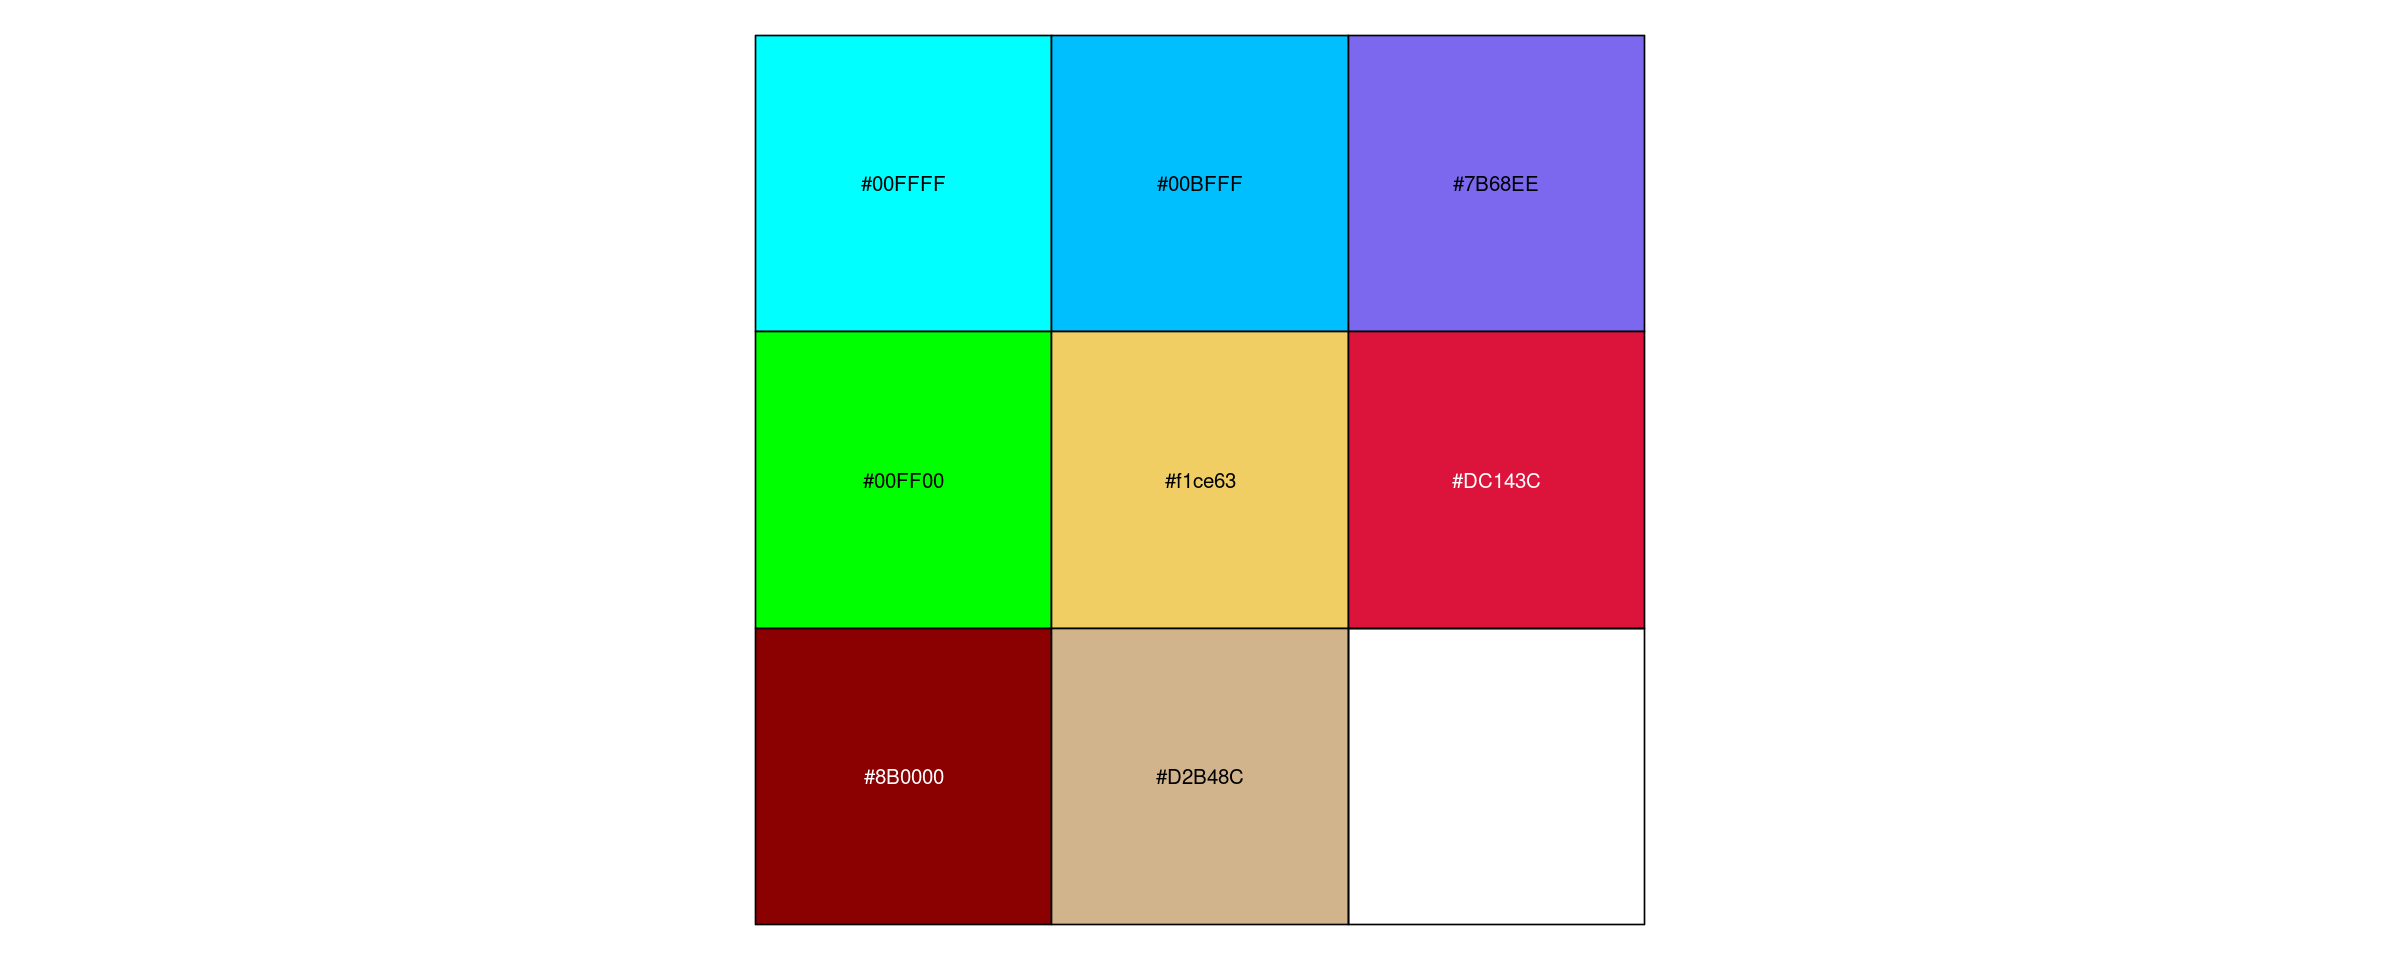

In [457]:
show_col(c("#00FFFF","#00BFFF","#7B68EE","#00FF00","#f1ce63","#DC143C","#8B0000","#D2B48C"))

In [746]:
head(spatial_coord,n=1)
celltype.need <- c("Mac_SPP1","Mac_STMN1","Mac_AIF1","Mac_CCL18","Epithelial","Endothelial","Pericyte","myCAF")

barcodeID                  tissue row col imagerow imagecol imagerow_scaled
1 PDACH_7_AAACACCAATAACTGC-1 1      59  19  5056     6369     134.8147       
  imagecol_scaled Mac_SPP1  Mac_STMN1 Mac_AIF1 Mac_CCL18 Epithelial Endothelial
1 169.8249        0.6005002 0.8637804 NA       NA        0.9139915  0.4980661  
  Pericyte myCAF     max       
1 NA       0.4702594 Epithelial

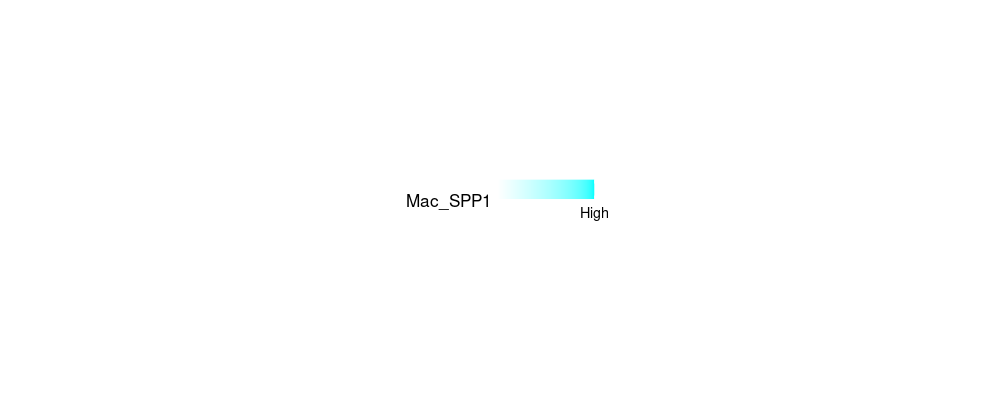

In [818]:
celltype.name <- "Mac_SPP1"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p1 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#00FFFF", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd1 <- cowplot::get_legend(p1)
grid.newpage()
grid.draw(lgd1)

In [819]:
celltype.name <- "Mac_STMN1"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p2 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#00BFFF", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd2 <- cowplot::get_legend(p2)

celltype.name <- "Mac_AIF1"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p3 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#7B68EE", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd3 <- cowplot::get_legend(p3)

celltype.name <- "Mac_CCL18"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p4 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#00FF00", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd4 <- cowplot::get_legend(p4)

celltype.name <- "Epithelial"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p5 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#f1ce63", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd5 <- cowplot::get_legend(p5)

celltype.name <- "Endothelial"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p6 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#DC143C", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd6 <- cowplot::get_legend(p6)

celltype.name <- "Epithelial"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p7 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#8B0000", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd7 <- cowplot::get_legend(p7)

celltype.name <- "myCAF"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p8 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#D2B48C", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd8 <- cowplot::get_legend(p8)

In [799]:
library(gridExtra)

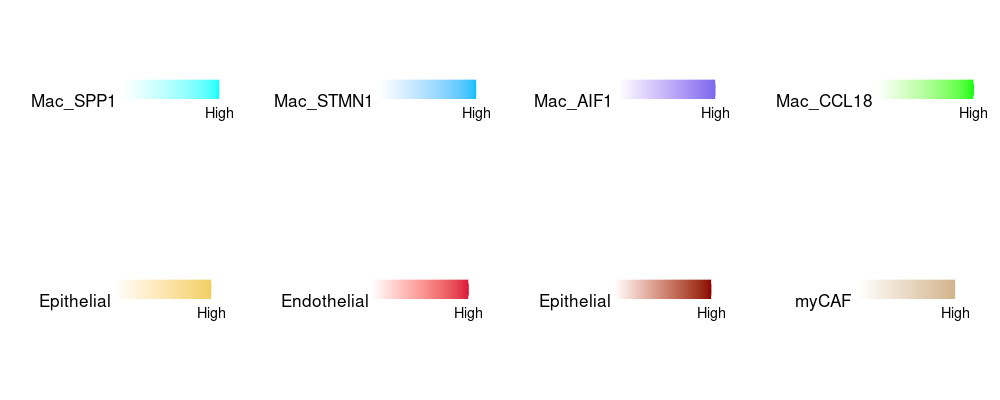

In [820]:
grid.arrange(lgd1,lgd2,lgd3,lgd4,lgd5,lgd6,lgd7,lgd8, nrow=2)

In [821]:
pdf(file = paste0(dir2,"Figure/spatial_CP1_lgd.pdf"), width = 10, height = 3)
grid.arrange(lgd1,lgd2,lgd3,lgd4,lgd5,lgd6,lgd7,lgd8, nrow=2)
dev.off()

png 
  2

以下是CP2：

In [464]:
# 为pancreas跑：
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("PDAC") & datalist$Cluster == "CP2",]
need.list

Category   Type Project   Sample                        SampleID   
35 胰腺导管癌 PDAC GSE272362 GSM8399454_S13_Sample5_F1_Blu IU_PDA_HM2 
37 胰腺导管癌 PDAC GSE272362 GSM8399457_S17_Sample8_A1     IU_PDA_HM4 
38 胰腺导管癌 PDAC GSE272362 GSM8399459_S18_Sample10_A1    IU_PDA_HM5 
41 胰腺导管癌 PDAC GSE272362 GSM8399468_S20_Sample19_D2    IU_PDA_HM9 
43 胰腺导管癌 PDAC GSE272362 GSM8399473_S21_Sample24_E3    IU_PDA_HM11
44 胰腺导管癌 PDAC GSE272362 GSM8399476_S21_Sample27_A1    IU_PDA_HM12
   SampleID2         Cluster
35 S13-16408_F1(Blu) CP2    
37 S17-19380_A1      CP2    
38 S18-24418_A1      CP2    
41 S20-19254_D2      CP2    
43 S21-23955_E3      CP2    
44 S21-26075_A1      CP2

In [813]:
need.list <- datalist[datalist$Type %in% c("PDAC") & datalist$Cluster == "CP2",]
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    cluster <- need.list[need.list$Project == project & need.list$Sample == sample,]$Cluster
    celltype.need <- c("Mac_CCL3","Mac_GPR183","Mac_MT1G","Mono_IL1B",
                       "Epithelial","Endothelial","Pericyte","myCAF")
    print(dir.exists(dir))
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        ## 获得打分数据
        obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell.csv"),row.names=1) %>%
                                dplyr::select(c(celltype.need))
        metadata_ds <- data.frame(obj.ST@meta.data)
        colnames(metadata_ds) <- colnames(obj.ST@meta.data)
        ## 提取metadata以便打分分数与空间坐标合并
        metadata_ds <- metadata_ds %>% tibble::rownames_to_column("barcodeID") %>%
                    dplyr::mutate(rsum = base::rowSums(.[, celltype.need,drop = FALSE])) %>% 
                    dplyr::filter(rsum != 0) %>%
                    dplyr::select("barcodeID") %>% dplyr::left_join(metadata_ds %>%
                    tibble::rownames_to_column("barcodeID"), by = "barcodeID") %>%
                    tibble::column_to_rownames("barcodeID")
        slice <- names(obj.ST@images)[1]
        cell_types_all <- intersect(colnames(metadata_ds),celltype.need)
        # 提取空间坐标
        spatial_coord <- data.frame(obj.ST@images[[slice]]@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% 
        dplyr::mutate(imagerow_scaled = imagerow * obj.ST@images[[slice]]@scale.factors$lowres, 
                      imagecol_scaled = imagecol * obj.ST@images[[slice]]@scale.factors$lowres) %>% 
        dplyr::inner_join(metadata_ds %>% tibble::rownames_to_column("barcodeID"), by = "barcodeID")
        ## 读取切片
        img <- png::readPNG(paste0(dir,"/spatial/tissue_lowres_image.png"))
        ## 调整切片的饱和度
        if (length(dim(img)) == 3) { 
          gray_values <- 0.299 * img[,,1] + 0.587 * img[,,2] + 0.114 * img[,,3]
          saturation_factor <- 0.3  # 设置饱和度降低的比例（0 表示完全灰度化，1 表示原图）,比如设置为 50% 的饱和度
          desaturated_img <- img
          desaturated_img[,,1] <- img[,,1] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,2] <- img[,,2] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,3] <- img[,,3] * saturation_factor + gray_values * (1 - saturation_factor)
        } else {
          stop("图片不是 RGB 格式，无法调整饱和度！")
        }
        img_grob <- grid::rasterGrob(desaturated_img, interpolate = FALSE, width = grid::unit(1,"npc"), height = grid::unit(1, "npc"))
        ## 获取最高表达的细胞
        col_means <- colMeans(spatial_coord[,c(cell_types_all)])
        # 识别最大细胞
        spatial_coord$max <- apply(X = spatial_coord[,c(cell_types_all)], MARGIN = 1, FUN = function(x){
                                            max_col <- names(x)[which.max(x)]
                                            return(max_col)})    
        # 删掉低于平均表达的值点
        for(cell in cell_types_all){
#             mean_value <- mean(spatial_coord[,cell])
            mean_value <- quantile(spatial_coord[,cell], probs = 0.5, na.rm = TRUE)
            spatial_coord[,cell][spatial_coord[,cell] < mean_value] <- NA
            print(table(is.na(spatial_coord[,cell])))
            
#             spatial_coord[, cell] <- lapply(cell, function(col_name) {
#               ## 对于那些有重复值的点位，只保留最高的那个值的颜色。
#               ifelse(spatial_coord$max != col_name, NA, spatial_coord[[col_name]])
#             })
        }
        cell_1 = 'Mac_CCL3'
        cell_2 = 'Mac_GPR183'
        cell_3 = 'Mac_MT1G'
        cell_4 = 'Mono_IL1B'
        cell_5 = 'Epithelial'
        cell_6 = 'Endothelial'
        cell_7 = 'Pericyte'
        cell_8 = 'myCAF'
        Max_1 = max(spatial_coord[,cell_1],na.rm = TRUE)
        spatial_coord[,cell_1] = spatial_coord[,cell_1]/Max_1
        Max_2 = max(spatial_coord[,cell_2],na.rm = TRUE)
        spatial_coord[,cell_2] = spatial_coord[,cell_2]/Max_2
        Max_3 = max(spatial_coord[,cell_3],na.rm = TRUE)
        spatial_coord[,cell_3] = spatial_coord[,cell_3]/Max_3
        Max_4 = max(spatial_coord[,cell_4],na.rm = TRUE)
        spatial_coord[,cell_4] = spatial_coord[,cell_4]/Max_4
        Max_5 = max(spatial_coord[,cell_5],na.rm = TRUE)
        spatial_coord[,cell_5] = spatial_coord[,cell_5]/Max_5
        Max_6 = max(spatial_coord[,cell_6],na.rm = TRUE)
        spatial_coord[,cell_6] = spatial_coord[,cell_6]/Max_6
        Max_7 = max(spatial_coord[,cell_7],na.rm = TRUE)
        spatial_coord[,cell_7] = spatial_coord[,cell_7]/Max_7
        Max_8 = max(spatial_coord[,cell_8],na.rm = TRUE)
        spatial_coord[,cell_8] = spatial_coord[,cell_8]/Max_8

        scatterpie_plt <- ggplot2::ggplot() + 
                ggplot2::annotation_custom(grob = img_grob,xmin = 0, xmax = ncol(img), ymin = 0, ymax = -nrow(img))+
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_1),alpha = get(cell_1)), color = '#00FFFF') + # 颜色再换个炸裂的
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_2),alpha = get(cell_2)), color = '#00BFFF') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_3),alpha = get(cell_3)), color = '#7B68EE') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_4),alpha = get(cell_4)), color = '#00FF00') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_5),alpha = get(cell_5)), color = '#f1ce63') +  
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_6),alpha = get(cell_6)), color = '#DC143C') +  
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_7),alpha = get(cell_7)), color = '#8B0000') +    
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_8),alpha = get(cell_8)), color = '#D2B48C') +   
                ggplot2::scale_y_reverse() + ggplot2::ylim(nrow(img),0) + 
                ggplot2::xlim(0, ncol(img)) + 
                cowplot::theme_half_open(11,rel_small = 1) + 
                ggplot2::theme_void() + 
                ggplot2::coord_fixed(ratio = 1,xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") +
                ggplot2::scale_size_continuous(range=c(0,2))+
                ggplot2::scale_alpha_continuous(range=c(0.5,1))+
                theme(legend.position = "none")
#                     labs(size = cell) + 
#                 guides(alpha = "none")            
      
#         pdf(paste0(dir2,"Figure/spatial/CP2/",project,"_",sample,'_dot.pdf'),width = 8,height = 7)
#         print(scatterpie_plt)
#         dev.off()      
    }
}

[1] TRUE

FALSE  TRUE 
 1239  1239 

FALSE  TRUE 
 1239  1239 

FALSE  TRUE 
 1239  1239 

FALSE  TRUE 
 1239  1239 

FALSE  TRUE 
 1239  1239 

FALSE  TRUE 
 1239  1239 

FALSE  TRUE 
 1239  1239 

FALSE  TRUE 
 1239  1239 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
  921   920 

FALSE  TRUE 
  921   920 

FALSE  TRUE 
  921   920 

FALSE  TRUE 
  921   920 

FALSE  TRUE 
  921   920 

FALSE  TRUE 
  921   920 

FALSE  TRUE 
  921   920 

FALSE  TRUE 
  921   920 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
 1519  1519 

FALSE  TRUE 
 1519  1519 

FALSE  TRUE 
 1519  1519 

FALSE  TRUE 
 1519  1519 

FALSE  TRUE 
 1519  1519 

FALSE  TRUE 
 1519  1519 

FALSE  TRUE 
 1519  1519 

FALSE  TRUE 
 1519  1519 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
  954   954 

FALSE  TRUE 
  954   954 

FALSE  TRUE 
  954   954 

FALSE  TRUE 
  954   954 

FALSE  TRUE 
  954   954 

FALSE  TRUE 
  954   954 

FALSE  TRUE 
  954   954 

FALSE  TRUE 
  954   954 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
 1966  1965 

FALSE  TRUE 
 1966  1965 

FALSE  TRUE 
 1966  1965 

FALSE  TRUE 
 1966  1965 

FALSE  TRUE 
 1966  1965 

FALSE  TRUE 
 1966  1965 

FALSE  TRUE 
 1966  1965 

FALSE  TRUE 
 1966  1965 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
 1481  1480 

FALSE  TRUE 
 1481  1480 

FALSE  TRUE 
 1481  1480 

FALSE  TRUE 
 1481  1480 

FALSE  TRUE 
 1481  1480 

FALSE  TRUE 
 1481  1480 

FALSE  TRUE 
 1481  1480 

FALSE  TRUE 
 1481  1480 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


In [ ]:
head(spatial_coord,n=1)
    celltype.need <- c("Mac_CCL3","Mac_GPR183","Mac_MT1G","Mono_IL1B","Epithelial","Endothelial","Pericyte","myCAF")

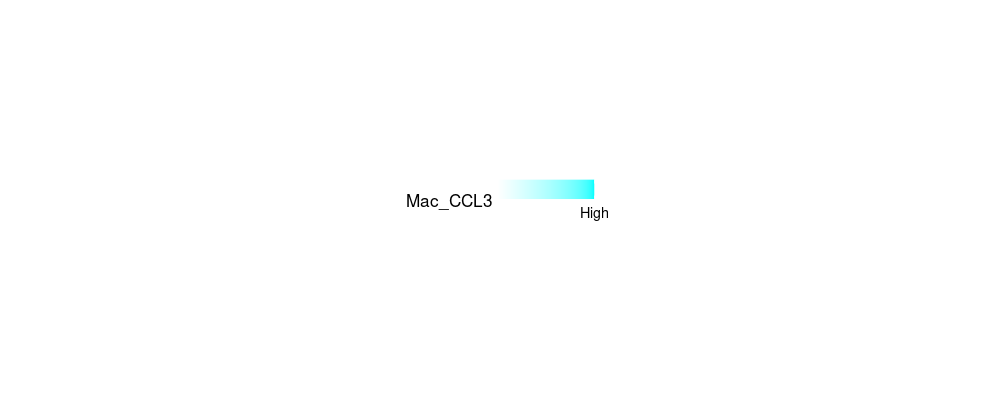

In [814]:
celltype.name <- "Mac_CCL3"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p1 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#00FFFF", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd1 <- cowplot::get_legend(p1)
grid.newpage()
grid.draw(lgd1)

In [815]:
celltype.name <- "Mac_GPR183"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p2 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#00BFFF", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd2 <- cowplot::get_legend(p2)

celltype.name <- "Mac_MT1G"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p3 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#7B68EE", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd3 <- cowplot::get_legend(p3)

celltype.name <- "Mono_IL1B"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p4 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#00FF00", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd4 <- cowplot::get_legend(p4)

celltype.name <- "Epithelial"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p5 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#f1ce63", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd5 <- cowplot::get_legend(p5)

celltype.name <- "Endothelial"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p6 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#DC143C", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd6 <- cowplot::get_legend(p6)

celltype.name <- "Epithelial"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p7 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#8B0000", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd7 <- cowplot::get_legend(p7)

celltype.name <- "myCAF"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p8 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#D2B48C", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd8 <- cowplot::get_legend(p8)

In [816]:
pdf(file = paste0(dir2,"Figure/spatial_CP2_lgd.pdf"), width = 10, height = 3)
grid.arrange(lgd1,lgd2,lgd3,lgd4,lgd5,lgd6,lgd7,lgd8, nrow=2)
dev.off()

png 
  2

### Intestine

In [534]:
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("CRC"),]
need.list

Category Type Project        Sample                    SampleID         
1  结直肠癌 CRC  GSE225857      GSM7058760                GSM7058760       
2  结直肠癌 CRC  GSE225857      GSM7058761                GSM7058761       
3  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U1Z1B1      HT225C1-Th1U1    
4  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U2Z1B1      HT225C1-Th1U2    
5  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U3Z1B1      HT225C1-Th1U3    
6  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U4Z1B1      HT225C1-Th1U4    
7  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U5Z1B1      HT225C1-Th1U5    
8  结直肠癌 CRC  HTAN_WUSTL_CRC HT413C1-Th1K2A4U14Bp1     HT413C1-Th1K2U14 
9  结直肠癌 CRC  HTAN_WUSTL_CRC HT413C1-Th1K2A4U1Bp1      HT413C1-Th1K2U1  
10 结直肠癌 CRC  HTAN_WUSTL_CRC HT413C1-Th1K2A4U2Bp1      HT413C1-Th1K2U2  
11 结直肠癌 CRC  HTAN_WUSTL_CRC HT413C1-Th1K1A4Us1_3Bp1_1 HT413C1-Th1K1A4U1
12 结直肠癌 CRC  HTAN_WUSTL_CRC HT413C1-Th1K2A1Us1_2Bp1_1 HT413C1-Th1K2A1U1
13 结直肠癌 CRC  HTAN_WUSTL_CRC HT413C1-Th1K3A1Us1_1Bp1_1 HT413C1-Th1K3A1U1
14 结直肠癌 CRC  HTAN_WUSTL_CRC HT112C1-U1_ST_Bn1         HT112C1-Th1U1    
15 结直肠癌 CRC  HTAN_WUSTL_CRC HT112C1-U2_ST_Bn1         HT112C1-Th1U2    
16 结直肠癌 CRC  HTAN_WUSTL_CRC HT448C1-Th1K1Fp1U13Bp1    HT448C1-Th1K1U13 
17 结直肠癌 CRC  HTAN_WUSTL_CRC HT448C1-Th1K1Fp1U1Bp1     HT448C1-Th1K1U1  
18 结直肠癌 CRC  HTAN_WUSTL_CRC HT253C1-Th1K1Fc2U1Z1Bs1   HT253C1-Th1K1U1  
19 结直肠癌 CRC  HTAN_WUSTL_CRC HT260C1-Th1K1Fc2U1Z1Bs1   HT260C1-Th1K1U1  
20 结直肠癌 CRC  HTAN_WUSTL_CRC HT472C1-Th1K1Fp1U1Bp1     HT472C1-Th1K1U1  
21 结直肠癌 CRC  HTAN_WUSTL_CRC S16-38794-E3U1Bp1         S16-38794-E3U1   
22 结直肠癌 CRC  HTAN_WUSTL_CRC S15-32775-A1U1Bp1         S15-32775-A1U1   
23 结直肠癌 CRC  HTAN_WUSTL_CRC S15-1909-C2U1Bp1          S15-1909-C2U1    
24 结直肠癌 CRC  HTAN_WUSTL_CRC HT165C1-Th1K3Fc2U1Z1Bs1   HT165C1-Th1K3U1  
25 结直肠癌 CRC  HTAN_WUSTL_CRC HT213C1-Th1K4Fc2U1Z1Bs1   HT213C1-Th1K4U1  
26 结直肠癌 CRC  HTAN_WUSTL_CRC HT230C1-Th1Fc1U1Z1B1      HT230C1-Th1U1    
27 结直肠癌 CRC  HTAN_WUSTL_CRC HT250C1-Th1K1Fc2U1Z1Bs1   HT250C1-Th1K1U1  
28 结直肠癌 CRC  HTAN_WUSTL_CRC HT525C1-Th1K1Fp1U1Bp1     HT525C1-Th1K1U1  
   SampleID2 Cluster Most.representitive.for.CP
1            CP6                               
2            CP6                               
3                                              
4                                              
5                                              
6                                              
7                                              
8                                              
9                                              
10                                             
11                                             
12                                             
13                                             
14                                             
15                                             
16                                             
17                                             
18                                             
19                                             
20                                             
21                                             
22                                             
23                                             
24                                             
25                                             
26                                             
27                                             
28

In [537]:
## Intestine在CP6中，所以感兴趣的细胞类型是
celltype.need <- c("Treg_TNFRSF4","Treg_BATF","Th1_GADD45B","CD4T_CXCR4",
                   "Epithelial","CD8Tex_CCL5")

In [538]:
marker.list <- list()
log2FC = 0.5
num = 500
for (i in celltype.need){
    if(i %in% c("Treg_TNFRSF4","Treg_BATF","Th1_GADD45B","CD4T_CXCR4","CD8Tex_CCL5")){
        all_dmarker <- readRDS(paste0(dir2,"DEG/nkt_all_DEG.rds"))
        df <- filter(all_dmarker, cluster == i & avg_log2FC > log2FC & p_val_adj < 0.0001) %>% slice_max(avg_log2FC,n=num)
        marker.list[i] <- list(df$name)
    }else if(i %in% c("Epithelial")){
        all_dmarker <- readRDS(paste0(dir2,"DEG/Epithelial_HM_DEG.rds"))
        df <- filter(all_dmarker, cluster == "Intestine" & avg_log2FC > log2FC & p_val_adj < 0.0001) %>% slice_max(avg_log2FC,n=num)
        marker.list[i] <- list(union(df$name,c("EPCAM","KRT18","CD24","KRT19","PAX8","SCGB2A2","KRT5","KRT15")))
    }
}
str(marker.list)

List of 6
 $ Treg_TNFRSF4: chr [1:272] "TNFRSF4" "IL2RA" "TNFRSF18" "BATF" ...
 $ Treg_BATF   : chr [1:89] "TNFRSF4" "BATF" "CXCL13" "FOXP3" ...
 $ Th1_GADD45B : chr [1:76] "HSPA1B" "FOS" "EGR1" "JUN" ...
 $ CD4T_CXCR4  : chr [1:280] "PLCG2" "MTRNR2L12" "INTS6" "ENSG00000285437" ...
 $ Epithelial  : chr [1:344] "CHGA" "TPH1" "TAC1" "IGHG3" ...
 $ CD8Tex_CCL5 : chr [1:152] "MTRNR2L8" "TRBV15" "CD8A" "DUSP4" ...


In [61]:
for(i in 1:nrow(need.list)){
# for(i in 14:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        if(length(colnames(obj.ST@meta.data))>5){
            obj.ST@meta.data <- obj.ST@meta.data %>% dplyr::select(c(orig.ident,nCount_Spatial,nFeature_Spatial,nCount_SCT,nFeature_SCT))
        }else{
            obj.ST@meta.data <- obj.ST@meta.data
        }
        obj.ST <- AddModuleScore_UCell(obj.ST, features = marker.list, assay = "SCT",name = NULL, ncores = 4)
#         write.csv(obj.ST@meta.data, file = paste0(dir,"/celltype_score_Ucell.csv"))
        write.csv(obj.ST@meta.data, file = paste0(dir,"/celltype_score_Ucell_top500_0.5FC.csv"))
    }
}

Warning message:
“The following genes were not found and will be
                        imputed to exp=0:
* CCR8,FAM129A,SEPT6,FAM96A,FAM173A,ASNA1,C19orf24,MINOS1,TRBV15,TRAV19,TRAV26-1,MLANA,RARRES3,PLA2G16,SEPT1,SEPT9,ZC3H11A,SEPT7,FAM96B,ENSG00000285437,AL451085.1,AL031777.3,AL627171.1,AC243960.1,DDX3Y,SDR42E2,KIAA1551,C6orf48,UTY,FAM208B,SEPT2”
Warning message:
“The following genes were not found and will be
                        imputed to exp=0:
* CCR8,FAM129A,SEPT6,FAM96A,FAM173A,ASNA1,C19orf24,MINOS1,TRBV15,TRAV19,TRAV26-1,MLANA,RARRES3,PLA2G16,SEPT1,SEPT9,ZC3H11A,SEPT7,FAM96B,AP001160.1,ENSG00000285437,AL451085.1,AL031777.3,AL627171.1,DDX3Y,SDR42E2,KIAA1551,C6orf48,UTY,FAM208B,SEPT2”
Warning message:
“The following genes were not found and will be
                        imputed to exp=0:
* LINC01943,LAIR2,ICOS,PKM,MIR4435-2HG,AC017002.3,CCR8,RPS27L,SIRPG,GAPDH,LINC02195,LINC02099,HLA-DQA1,CASP1,CD59,CD2,PRDX2,CCR6,MYL6,HAPLN3,AC133644.2,TNIP2,ALDOA,CXCR6,PRDX1,C9orf16,SUM

Warning message:
“The following genes were not found and will be
                        imputed to exp=0:
* LINC01943,PKM,MIR4435-2HG,AC017002.3,RPS27L,GAPDH,LINC02195,LINC02099,CASP1,CD59,PRDX2,CCR6,MYL6,HAPLN3,AC133644.2,TNIP2,ALDOA,PRDX1,C9orf16,SUMO2,SEC14L1,DYNLRB1,NT5C3A,RHOC,MRPS6,CYTOR,ATP5MC1,FAM129A,HLA-DRB1,TPI1,UQCR10,LINC01588,TMSB10,RANBP1,NDUFB8,CD83,ELOB,SRP14,RGS10,HLA-DRB5,GOLGA8B,MRPS21,ATP6V0C,CACYBP,PVT1,PARP1,NDUFB4,ADAT2,POLR2E,MRPL33,LGALS9,SEPT6,MRPS34,PPA1,DMAC1,LAMTOR5,SUB1,PPP2R1A,NDUFB3,ARL5A,NDUFB1,CDKN2A,RNF181,JAKMIP1,SELENOT,ZNHIT1,WASHC3,MRPL52,FAM96A,ARF6,PSMC2,PSMA6,MRPL20,ATP5F1C,LYPLA1,MRPL51,HIGD2A,SDHC,FAM173A,SLC25A38,HLA-B,GNB2,ASNA1,PPP2CA,TPM4,B3GAT3,RPS26,SKP1,POLR2J3,SEC61B,MRPL28,TBCA,IGLC2,C19orf24,MRPL57,PRKAR1A,CSNK1A1,SRPK2,UBE2D3,MRPS18C,STMP1,VMA21,ACTG1,POLR2J,SNRPN,MRPL18,MZT2A,LDHB,MINOS1,MTRNR2L12,MT-ND4L,MIR155HG,AC243829.4,MT-ATP8,CDK2AP2,RARRES3,UBE2F,DTHD1,MT-ND6,CCL3,DUSP5,AP3S1,AKR1B1,CFL1,PTPN11,EWSR1,PPIA,PLA2G16,SEPT1,S

In [485]:
for(i in 1:nrow(need.list)){
# for(i in 14:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    print(dir.exists(dir))
}

[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] FALSE
[1] FALSE
[1] FALSE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] TRUE
[1] FALSE
[1] TRUE
[1] FALSE
[1] TRUE
[1] TRUE


In [490]:
need.list$Sample[11]
need.list$Sample[12]
need.list$Sample[13]
need.list$Sample[24]
need.list$Sample[26]

[1] "HT413C1-Th1K1A4Us1_3Bp1_1"

[1] "HT413C1-Th1K2A1Us1_2Bp1_1"

[1] "HT413C1-Th1K3A1Us1_1Bp1_1"

[1] "HT165C1-Th1K3Fc2U1Z1Bs1"

[1] "HT230C1-Th1Fc1U1Z1B1"

In [ ]:
## 在终端上跑

#### single celltype - colored

In [478]:
library(imager)

In [541]:
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("CRC"),]
need.list

Category Type Project        Sample                    SampleID         
1  结直肠癌 CRC  GSE225857      GSM7058760                GSM7058760       
2  结直肠癌 CRC  GSE225857      GSM7058761                GSM7058761       
3  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U1Z1B1      HT225C1-Th1U1    
4  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U2Z1B1      HT225C1-Th1U2    
5  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U3Z1B1      HT225C1-Th1U3    
6  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U4Z1B1      HT225C1-Th1U4    
7  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U5Z1B1      HT225C1-Th1U5    
8  结直肠癌 CRC  HTAN_WUSTL_CRC HT413C1-Th1K2A4U14Bp1     HT413C1-Th1K2U14 
9  结直肠癌 CRC  HTAN_WUSTL_CRC HT413C1-Th1K2A4U1Bp1      HT413C1-Th1K2U1  
10 结直肠癌 CRC  HTAN_WUSTL_CRC HT413C1-Th1K2A4U2Bp1      HT413C1-Th1K2U2  
11 结直肠癌 CRC  HTAN_WUSTL_CRC HT413C1-Th1K1A4Us1_3Bp1_1 HT413C1-Th1K1A4U1
12 结直肠癌 CRC  HTAN_WUSTL_CRC HT413C1-Th1K2A1Us1_2Bp1_1 HT413C1-Th1K2A1U1
13 结直肠癌 CRC  HTAN_WUSTL_CRC HT413C1-Th1K3A1Us1_1Bp1_1 HT413C1-Th1K3A1U1
14 结直肠癌 CRC  HTAN_WUSTL_CRC HT112C1-U1_ST_Bn1         HT112C1-Th1U1    
15 结直肠癌 CRC  HTAN_WUSTL_CRC HT112C1-U2_ST_Bn1         HT112C1-Th1U2    
16 结直肠癌 CRC  HTAN_WUSTL_CRC HT448C1-Th1K1Fp1U13Bp1    HT448C1-Th1K1U13 
17 结直肠癌 CRC  HTAN_WUSTL_CRC HT448C1-Th1K1Fp1U1Bp1     HT448C1-Th1K1U1  
18 结直肠癌 CRC  HTAN_WUSTL_CRC HT253C1-Th1K1Fc2U1Z1Bs1   HT253C1-Th1K1U1  
19 结直肠癌 CRC  HTAN_WUSTL_CRC HT260C1-Th1K1Fc2U1Z1Bs1   HT260C1-Th1K1U1  
20 结直肠癌 CRC  HTAN_WUSTL_CRC HT472C1-Th1K1Fp1U1Bp1     HT472C1-Th1K1U1  
21 结直肠癌 CRC  HTAN_WUSTL_CRC S16-38794-E3U1Bp1         S16-38794-E3U1   
22 结直肠癌 CRC  HTAN_WUSTL_CRC S15-32775-A1U1Bp1         S15-32775-A1U1   
23 结直肠癌 CRC  HTAN_WUSTL_CRC S15-1909-C2U1Bp1          S15-1909-C2U1    
24 结直肠癌 CRC  HTAN_WUSTL_CRC HT165C1-Th1K3Fc2U1Z1Bs1   HT165C1-Th1K3U1  
25 结直肠癌 CRC  HTAN_WUSTL_CRC HT213C1-Th1K4Fc2U1Z1Bs1   HT213C1-Th1K4U1  
26 结直肠癌 CRC  HTAN_WUSTL_CRC HT230C1-Th1Fc1U1Z1B1      HT230C1-Th1U1    
27 结直肠癌 CRC  HTAN_WUSTL_CRC HT250C1-Th1K1Fc2U1Z1Bs1   HT250C1-Th1K1U1  
28 结直肠癌 CRC  HTAN_WUSTL_CRC HT525C1-Th1K1Fp1U1Bp1     HT525C1-Th1K1U1  
   SampleID2 Cluster Most.representitive.for.CP
1            CP6                               
2            CP6                               
3                                              
4                                              
5                                              
6                                              
7                                              
8                                              
9                                              
10                                             
11                                             
12                                             
13                                             
14                                             
15                                             
16                                             
17                                             
18                                             
19                                             
20                                             
21                                             
22                                             
23                                             
24                                             
25                                             
26                                             
27                                             
28

In [542]:
## Intestine在CP6中，所以感兴趣的细胞类型是
celltype.need <- c("Treg_TNFRSF4","Treg_BATF","Th1_GADD45B","CD4T_CXCR4",
                   "Epithelial","CD8Tex_CCL5")

In [543]:
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        ## 获得打分数据
#         obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell.csv"),row.names=1) %>%
        obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell_top500_0.5FC.csv"),row.names=1) %>%
                                dplyr::select(c(celltype.need))
        metadata_ds <- data.frame(obj.ST@meta.data)
        colnames(metadata_ds) <- colnames(obj.ST@meta.data)
        ## 提取metadata以便打分分数与空间坐标合并
        metadata_ds <- metadata_ds %>% tibble::rownames_to_column("barcodeID") %>%
                    dplyr::mutate(rsum = base::rowSums(.[, celltype.need,drop = FALSE])) %>% 
                    dplyr::filter(rsum != 0) %>%
                    dplyr::select("barcodeID") %>% dplyr::left_join(metadata_ds %>%
                    tibble::rownames_to_column("barcodeID"), by = "barcodeID") %>%
                    tibble::column_to_rownames("barcodeID")
        slice <- names(obj.ST@images)[1]
        cell_types_all <- intersect(colnames(metadata_ds),celltype.need)
        # 提取空间坐标
        spatial_coord <- data.frame(obj.ST@images[[slice]]@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% 
        dplyr::mutate(imagerow_scaled = imagerow * obj.ST@images[[slice]]@scale.factors$lowres, 
                      imagecol_scaled = imagecol * obj.ST@images[[slice]]@scale.factors$lowres) %>% 
        dplyr::inner_join(metadata_ds %>% tibble::rownames_to_column("barcodeID"), by = "barcodeID")
        ## 读取切片
        img <- png::readPNG(paste0(dir,"/spatial/tissue_lowres_image.png"))
        ## 调整切片的饱和度
        if (length(dim(img)) == 3) { 
          gray_values <- 0.299 * img[,,1] + 0.587 * img[,,2] + 0.114 * img[,,3]
          saturation_factor <- 0.2  # 设置饱和度降低的比例（0 表示完全灰度化，1 表示原图）,比如设置为 50% 的饱和度
          desaturated_img <- img
          desaturated_img[,,1] <- img[,,1] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,2] <- img[,,2] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,3] <- img[,,3] * saturation_factor + gray_values * (1 - saturation_factor)
        } else {
          stop("图片不是 RGB 格式，无法调整饱和度！")
        }
        img_grob <- grid::rasterGrob(desaturated_img, interpolate = FALSE, width = grid::unit(1,"npc"), height = grid::unit(1, "npc"))
        ## 获取最高表达的细胞
        col_means <- colMeans(spatial_coord[,c(cell_types_all)])
        # 识别最大细胞
        spatial_coord$max <- apply(X = spatial_coord[,c(cell_types_all)], MARGIN = 1, FUN = function(x){
                                            max_col <- names(x)[which.max(x)]
                                            return(max_col)})    
#         # 识别最大细胞是否大于其平均值
#         obj.ST@meta.data$celltype <- apply(X = obj.ST@meta.data[4:(3+length(celltype.need))], MARGIN = 1, FUN = function(x){
#                                                 max_col <- names(x)[which.max(x)]
#                                                 if(x[which.max(x)] > col_means[max_col]){
#                                                     return(max_col)}else{return("others")}
#                                             })
        
        ## 开始画图
        plot.list <- lapply(X = celltype.need, FUN = function(x){
            cell <- x
            Max = max(spatial_coord[,cell],na.rm = TRUE)
            spatial_coord[,cell] = spatial_coord[,cell]/Max
            scatterpie_plt <- ggplot2::ggplot() + 
                        ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                                      size = get(cell), color = get(cell))) + 
                        scale_color_gradientn(colours = colorspace::sequential_hcl(n = 8, palette = "Inferno"))+
                        ggplot2::scale_y_reverse() + 
                        ggplot2::ylim(nrow(img),0) +
                        ggplot2::xlim(0, ncol(img)) + 
                        cowplot::theme_half_open(11, rel_small = 1) + 
                        ggplot2::theme_void() + 
                        ggplot2::coord_fixed(ratio = 1, xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") +
                        ggplot2::scale_size_continuous(range=c(0,1))+
                        labs(size = cell)      
                        })
        pdf(paste0(dir2,"Figure/spatial/",project,"_",sample,"_all_celltype_in_Intestine_dot.pdf"),width = 15,height = 8)
        print(cowplot::plot_grid(plotlist = plot.list, align = "h", ncol = 3))
        dev.off()
        
    }
}

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


#### single celltype colored(final)

In [544]:
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("CRC") & datalist$Cluster == "CP6",]
need.list

Category Type Project        Sample                SampleID        SampleID2
1  结直肠癌 CRC  GSE225857      GSM7058760            GSM7058760               
2  结直肠癌 CRC  GSE225857      GSM7058761            GSM7058761               
3  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U1Z1B1  HT225C1-Th1U1            
4  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U2Z1B1  HT225C1-Th1U2            
5  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U3Z1B1  HT225C1-Th1U3            
6  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U4Z1B1  HT225C1-Th1U4            
7  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U5Z1B1  HT225C1-Th1U5            
15 结直肠癌 CRC  HTAN_WUSTL_CRC HT112C1-U2_ST_Bn1     HT112C1-Th1U2            
17 结直肠癌 CRC  HTAN_WUSTL_CRC HT448C1-Th1K1Fp1U1Bp1 HT448C1-Th1K1U1          
20 结直肠癌 CRC  HTAN_WUSTL_CRC HT472C1-Th1K1Fp1U1Bp1 HT472C1-Th1K1U1          
   Cluster Most.representitive.for.CP
1  CP6                               
2  CP6                               
3  CP6                               
4  CP6                               
5  CP6     CP6                       
6  CP6     CP6                       
7  CP6                               
15 CP6                               
17 CP6                               
20 CP6     CP6

In [549]:
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    celltype.need <- c("Treg_TNFRSF4","Treg_BATF","Th1_GADD45B","CD4T_CXCR4",
                       "Epithelial","CD8Tex_CCL5")
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        ## 获得打分数据
        obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell_top500_0.5FC.csv"),row.names=1) %>%
                                dplyr::select(c(celltype.need))
        metadata_ds <- data.frame(obj.ST@meta.data)
        colnames(metadata_ds) <- colnames(obj.ST@meta.data)
        ## 提取metadata以便打分分数与空间坐标合并
        metadata_ds <- metadata_ds %>% tibble::rownames_to_column("barcodeID") %>%
                    dplyr::mutate(rsum = base::rowSums(.[, celltype.need,drop = FALSE])) %>% 
                    dplyr::filter(rsum != 0) %>%
                    dplyr::select("barcodeID") %>% dplyr::left_join(metadata_ds %>%
                    tibble::rownames_to_column("barcodeID"), by = "barcodeID") %>%
                    tibble::column_to_rownames("barcodeID")
        slice <- names(obj.ST@images)[1]
        cell_types_all <- intersect(colnames(metadata_ds),celltype.need)
        # 提取空间坐标
        spatial_coord <- data.frame(obj.ST@images[[slice]]@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% 
        dplyr::mutate(imagerow_scaled = imagerow * obj.ST@images[[slice]]@scale.factors$lowres, 
                      imagecol_scaled = imagecol * obj.ST@images[[slice]]@scale.factors$lowres) %>% 
        dplyr::inner_join(metadata_ds %>% tibble::rownames_to_column("barcodeID"), by = "barcodeID")
        ## 读取切片
        img <- png::readPNG(paste0(dir,"/spatial/tissue_lowres_image.png"))
        ## 调整切片的饱和度
        if (length(dim(img)) == 3) { 
          gray_values <- 0.299 * img[,,1] + 0.587 * img[,,2] + 0.114 * img[,,3]
          saturation_factor <- 0.5  # 设置饱和度降低的比例（0 表示完全灰度化，1 表示原图）,比如设置为 50% 的饱和度
          desaturated_img <- img
          desaturated_img[,,1] <- img[,,1] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,2] <- img[,,2] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,3] <- img[,,3] * saturation_factor + gray_values * (1 - saturation_factor)
        } else {
          stop("图片不是 RGB 格式，无法调整饱和度！")
        }
        img_grob <- grid::rasterGrob(desaturated_img, interpolate = FALSE, width = grid::unit(1,"npc"), height = grid::unit(1, "npc"))
        ## 获取最高表达的细胞
        col_means <- colMeans(spatial_coord[,c(cell_types_all)])
        # 识别最大细胞
        spatial_coord$max <- apply(X = spatial_coord[,c(cell_types_all)], MARGIN = 1, FUN = function(x){
                                            max_col <- names(x)[which.max(x)]
                                            return(max_col)})    
#         # 识别最大细胞是否大于其平均值
#         obj.ST@meta.data$celltype <- apply(X = obj.ST@meta.data[4:(3+length(celltype.need))], MARGIN = 1, FUN = function(x){
#                                                 max_col <- names(x)[which.max(x)]
#                                                 if(x[which.max(x)] > col_means[max_col]){
#                                                     return(max_col)}else{return("others")}
#                                             })
        
        ## 开始画图
        plot.list <- lapply(X = celltype.need, FUN = function(x){
            cell <- x
            Max = max(spatial_coord[,cell],na.rm = TRUE)
            spatial_coord[,cell] = spatial_coord[,cell]/Max
            scatterpie_plt <- ggplot2::ggplot() + 
                        ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                                      size = get(cell), color = get(cell))) + 
                        scale_color_gradientn(colours = colorspace::sequential_hcl(n = 8, palette = "Inferno"), 
                                              values = c(0,0.3,0.5,0.6,0.7,0.8,1))+
                        ggplot2::scale_y_reverse() + 
                        ggplot2::ylim(nrow(img),0) +
                        ggplot2::xlim(0, ncol(img)) + 
                        cowplot::theme_half_open(11, rel_small = 1) + 
                        ggplot2::theme_void() + 
                        ggplot2::coord_fixed(ratio = 1, xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") +
                        ggplot2::scale_size_continuous(range=c(0,0.4))+
                        labs(size = cell)+
                        theme(legend.position = "none",
                              plot.title = element_text(hjust = 0.5, vjust = 0, size = 15),
                              plot.margin = margin(t = 0, r = 0, b = 0, l = 0))+
                        ggtitle(label = cell)
                        })
        pdf(paste0(dir2,"Figure/spatial/CP6/",project,"_",sample,"_all_celltype_in_Intestine_dot_final.pdf"),width = 5.5,height = 4)
        print(cowplot::plot_grid(plotlist = plot.list, align = "h", ncol = 3))
        dev.off()
        
    }
}


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

#### multi celltypes - colored

In [550]:
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("CRC") & datalist$Cluster == "CP6",]
need.list

Category Type Project        Sample                SampleID        SampleID2
1  结直肠癌 CRC  GSE225857      GSM7058760            GSM7058760               
2  结直肠癌 CRC  GSE225857      GSM7058761            GSM7058761               
3  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U1Z1B1  HT225C1-Th1U1            
4  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U2Z1B1  HT225C1-Th1U2            
5  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U3Z1B1  HT225C1-Th1U3            
6  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U4Z1B1  HT225C1-Th1U4            
7  结直肠癌 CRC  HTAN_WUSTL_CRC HT225C1-Th1Fc1U5Z1B1  HT225C1-Th1U5            
15 结直肠癌 CRC  HTAN_WUSTL_CRC HT112C1-U2_ST_Bn1     HT112C1-Th1U2            
17 结直肠癌 CRC  HTAN_WUSTL_CRC HT448C1-Th1K1Fp1U1Bp1 HT448C1-Th1K1U1          
20 结直肠癌 CRC  HTAN_WUSTL_CRC HT472C1-Th1K1Fp1U1Bp1 HT472C1-Th1K1U1          
   Cluster Most.representitive.for.CP
1  CP6                               
2  CP6                               
3  CP6                               
4  CP6                               
5  CP6     CP6                       
6  CP6     CP6                       
7  CP6                               
15 CP6                               
17 CP6                               
20 CP6     CP6

In [822]:
need.list <- datalist[datalist$Type %in% c("CRC") & datalist$Cluster == "CP6",]
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    cluster <- need.list[need.list$Project == project & need.list$Sample == sample,]$Cluster
    celltype.need <- c("Treg_TNFRSF4","Treg_BATF","Th1_GADD45B","CD4T_CXCR4",
                       "Epithelial","CD8Tex_CCL5")
    print(dir.exists(dir))
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        ## 获得打分数据
        obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell_top500_0.5FC.csv"),row.names=1) %>%
                                dplyr::select(c(celltype.need))
        metadata_ds <- data.frame(obj.ST@meta.data)
        colnames(metadata_ds) <- colnames(obj.ST@meta.data)
        ## 提取metadata以便打分分数与空间坐标合并
        metadata_ds <- metadata_ds %>% tibble::rownames_to_column("barcodeID") %>%
                    dplyr::mutate(rsum = base::rowSums(.[, celltype.need,drop = FALSE])) %>% 
                    dplyr::filter(rsum != 0) %>%
                    dplyr::select("barcodeID") %>% dplyr::left_join(metadata_ds %>%
                    tibble::rownames_to_column("barcodeID"), by = "barcodeID") %>%
                    tibble::column_to_rownames("barcodeID")
        slice <- names(obj.ST@images)[1]
        cell_types_all <- intersect(colnames(metadata_ds),celltype.need)
        # 提取空间坐标
        spatial_coord <- data.frame(obj.ST@images[[slice]]@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% 
        dplyr::mutate(imagerow_scaled = imagerow * obj.ST@images[[slice]]@scale.factors$lowres, 
                      imagecol_scaled = imagecol * obj.ST@images[[slice]]@scale.factors$lowres) %>% 
        dplyr::inner_join(metadata_ds %>% tibble::rownames_to_column("barcodeID"), by = "barcodeID")
        ## 读取切片
        img <- png::readPNG(paste0(dir,"/spatial/tissue_lowres_image.png"))
        ## 调整切片的饱和度
        if (length(dim(img)) == 3) { 
          gray_values <- 0.299 * img[,,1] + 0.587 * img[,,2] + 0.114 * img[,,3]
          saturation_factor <- 0.3  # 设置饱和度降低的比例（0 表示完全灰度化，1 表示原图）,比如设置为 50% 的饱和度
          desaturated_img <- img
          desaturated_img[,,1] <- img[,,1] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,2] <- img[,,2] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,3] <- img[,,3] * saturation_factor + gray_values * (1 - saturation_factor)
        } else {
          stop("图片不是 RGB 格式，无法调整饱和度！")
        }
        img_grob <- grid::rasterGrob(desaturated_img, interpolate = FALSE, width = grid::unit(1,"npc"), height = grid::unit(1, "npc"))
        ## 获取最高表达的细胞
        col_means <- colMeans(spatial_coord[,c(cell_types_all)])
        # 识别最大细胞
        spatial_coord$max <- apply(X = spatial_coord[,c(cell_types_all)], MARGIN = 1, FUN = function(x){
                                            max_col <- names(x)[which.max(x)]
                                            return(max_col)})    
        # 删掉低于平均表达的值点
        for(cell in cell_types_all){
#             mean_value <- mean(spatial_coord[,cell])
            mean_value <- quantile(spatial_coord[,cell], probs = 0.5, na.rm = TRUE)
            spatial_coord[,cell][spatial_coord[,cell] < mean_value] <- NA
            print(table(is.na(spatial_coord[,cell])))
            
#             spatial_coord[, cell] <- lapply(cell, function(col_name) {
#               ## 对于那些有重复值的点位，只保留最高的那个值的颜色。
#               ifelse(spatial_coord$max != col_name, NA, spatial_coord[[col_name]])
#             })
        }
        cell_1 = 'Treg_TNFRSF4'
        cell_2 = 'Treg_BATF'
        cell_3 = 'Th1_GADD45B'
        cell_4 = 'CD4T_CXCR4'
        cell_5 = 'Epithelial'
        cell_6 = 'CD8Tex_CCL5'

        Max_1 = max(spatial_coord[,cell_1],na.rm = TRUE)
        spatial_coord[,cell_1] = spatial_coord[,cell_1]/Max_1
        Max_2 = max(spatial_coord[,cell_2],na.rm = TRUE)
        spatial_coord[,cell_2] = spatial_coord[,cell_2]/Max_2
        Max_3 = max(spatial_coord[,cell_3],na.rm = TRUE)
        spatial_coord[,cell_3] = spatial_coord[,cell_3]/Max_3
        Max_4 = max(spatial_coord[,cell_4],na.rm = TRUE)
        spatial_coord[,cell_4] = spatial_coord[,cell_4]/Max_4
        Max_5 = max(spatial_coord[,cell_5],na.rm = TRUE)
        spatial_coord[,cell_5] = spatial_coord[,cell_5]/Max_5
        Max_6 = max(spatial_coord[,cell_6],na.rm = TRUE)
        spatial_coord[,cell_6] = spatial_coord[,cell_6]/Max_6

        scatterpie_plt <- ggplot2::ggplot() + 
                ggplot2::annotation_custom(grob = img_grob,xmin = 0, xmax = ncol(img), ymin = 0, ymax = -nrow(img))+
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_1),alpha = get(cell_1)), color = '#00FFFF') + # 颜色再换个炸裂的
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_2),alpha = get(cell_2)), color = '#00BFFF') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_3),alpha = get(cell_3)), color = '#7B68EE') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_4),alpha = get(cell_4)), color = '#00FF00') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_5),alpha = get(cell_5)), color = '#f1ce63') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_6),alpha = get(cell_6)), color = '#FF1493') +
                ggplot2::scale_y_reverse() + ggplot2::ylim(nrow(img),0) + 
                ggplot2::xlim(0, ncol(img)) + 
                cowplot::theme_half_open(11,rel_small = 1) + 
                ggplot2::theme_void() + 
                ggplot2::coord_fixed(ratio = 1,xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") +
                ggplot2::scale_size_continuous(range=c(0,2))+
                ggplot2::scale_alpha_continuous(range=c(0.5,1))+
                theme(legend.position = "none")
#                     labs(size = cell) + 
#                 guides(alpha = "none")            
      
#         pdf(paste0(dir2,"Figure/spatial/CP6/",project,"_",sample,'_dot.pdf'),width = 8,height = 7)
#         print(scatterpie_plt)
#         dev.off()      
    }
}

[1] TRUE

FALSE  TRUE 
 2336  2336 

FALSE  TRUE 
 2336  2336 

FALSE  TRUE 
 2336  2336 

FALSE  TRUE 
 2336  2336 

FALSE  TRUE 
 2336  2336 

FALSE  TRUE 
 2337  2335 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
 2398  2398 

FALSE  TRUE 
 2398  2398 

FALSE  TRUE 
 2398  2398 

FALSE  TRUE 
 2398  2398 

FALSE  TRUE 
 2398  2398 

FALSE  TRUE 
 2398  2398 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
 1861  1860 

FALSE  TRUE 
 1861  1860 

FALSE  TRUE 
 1861  1860 

FALSE  TRUE 
 1861  1860 

FALSE  TRUE 
 1861  1860 

FALSE  TRUE 
 1861  1860 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
 1841  1840 

FALSE  TRUE 
 1841  1840 

FALSE  TRUE 
 1842  1839 

FALSE  TRUE 
 1841  1840 

FALSE  TRUE 
 1841  1840 

FALSE  TRUE 
 1842  1839 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
 1855  1855 

FALSE  TRUE 
 1855  1855 

FALSE  TRUE 
 1855  1855 

FALSE  TRUE 
 1855  1855 

FALSE  TRUE 
 1855  1855 

FALSE  TRUE 
 1856  1854 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


[1] TRUE

FALSE  TRUE 
 1844  1844 

FALSE  TRUE 
 1845  1843 

FALSE  TRUE 
 1844  1844 

FALSE  TRUE 
 1844  1844 

FALSE  TRUE 
 1844  1844 

FALSE  TRUE 
 1844  1844 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


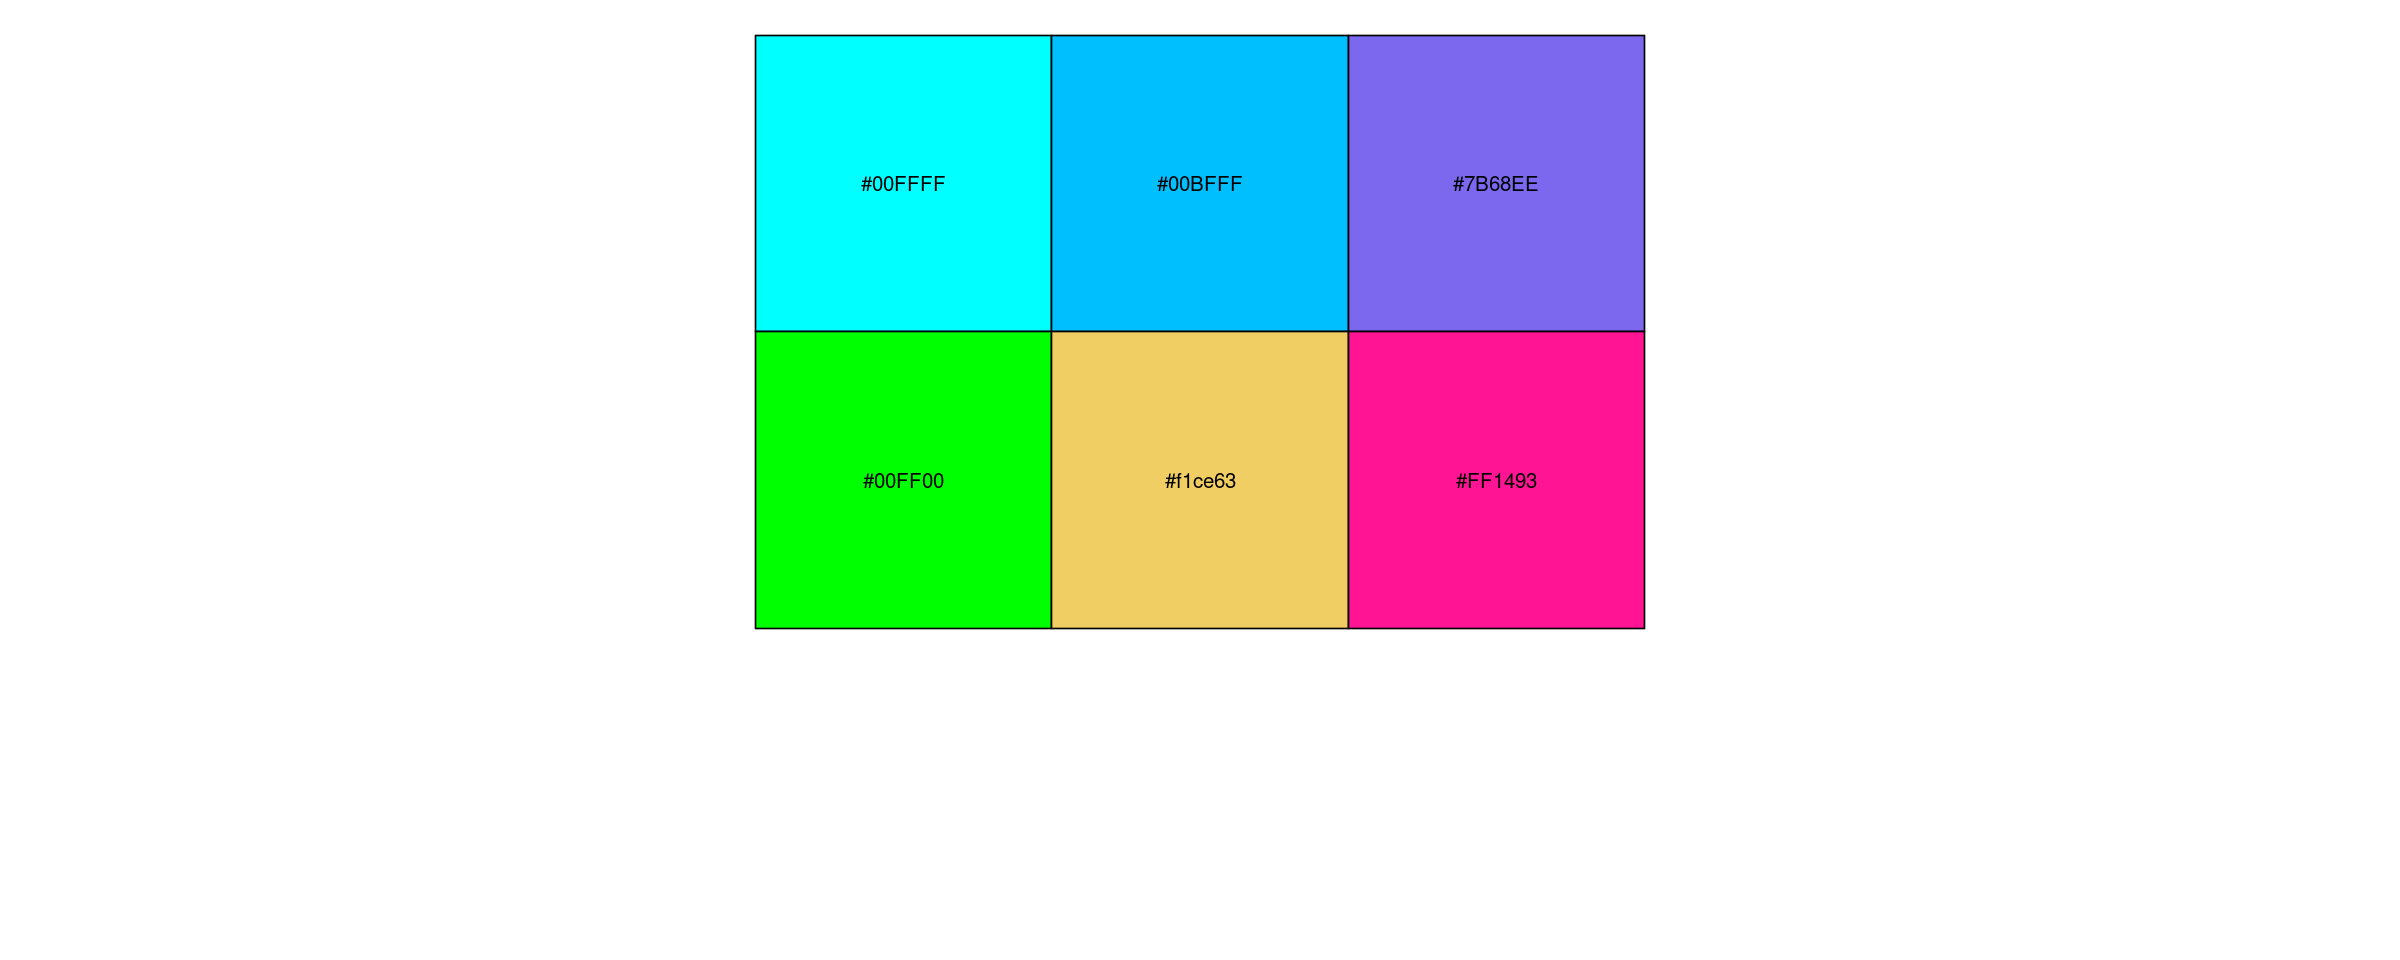

In [555]:
show_col(c("#00FFFF","#00BFFF","#7B68EE","#00FF00","#f1ce63","#FF1493"))

In [823]:
celltype.need <- c("Treg_TNFRSF4","Treg_BATF","Th1_GADD45B","CD4T_CXCR4",
                       "Epithelial","CD8Tex_CCL5")

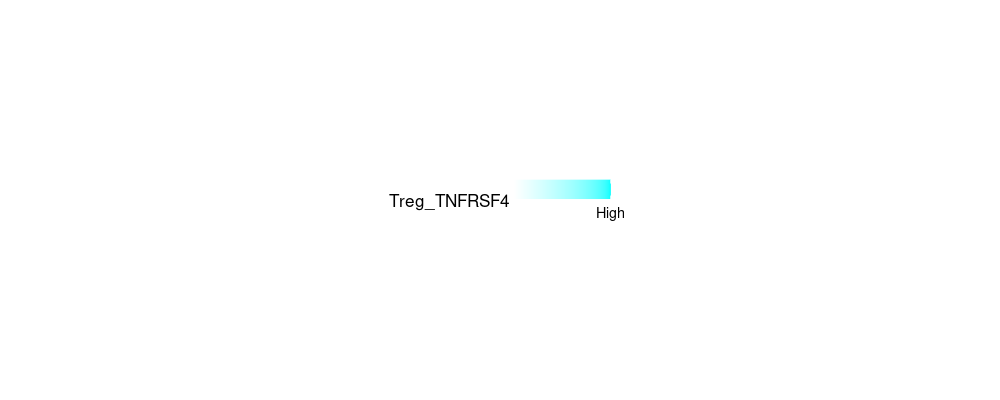

In [827]:
celltype.name <- "Treg_TNFRSF4"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p1 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#00FFFF", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd1 <- cowplot::get_legend(p1)
grid.newpage()
grid.draw(lgd1)

In [828]:
celltype.name <- "Treg_BATF"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p2 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#00BFFF", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd2 <- cowplot::get_legend(p2)

celltype.name <- "Th1_GADD45B"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p3 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#7B68EE", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd3 <- cowplot::get_legend(p3)

celltype.name <- "CD4T_CXCR4"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p4 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#00FF00", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd4 <- cowplot::get_legend(p4)

celltype.name <- "Epithelial"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p5 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#f1ce63", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd5 <- cowplot::get_legend(p5)

celltype.name <- "CD8Tex_CCL5"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p6 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#FF1493", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd6 <- cowplot::get_legend(p6)

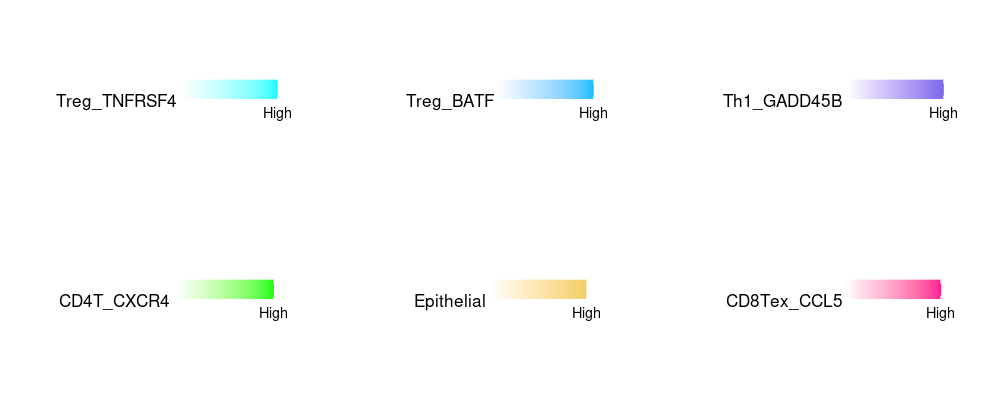

In [829]:
grid.arrange(lgd1,lgd2,lgd3,lgd4,lgd5,lgd6, nrow=2)

In [833]:
pdf(file = paste0(dir2,"Figure/spatial_CP3_lgd.pdf"), width = 8, height = 3)
grid.arrange(lgd1,lgd2,lgd3,lgd4,lgd5,lgd6, nrow=2)
dev.off()

png 
  2

### Mammary

In [498]:
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("TNBC/BRCA"),]
need.list

Category   Type      Project           Sample                  
29 三阴乳腺癌 TNBC/BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U2Z1Bs1 
30 三阴乳腺癌 TNBC/BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U12Z1Bs1
31 三阴乳腺癌 TNBC/BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U22Z1Bs1
32 三阴乳腺癌 TNBC/BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U32Z1Bs1
33 三阴乳腺癌 TNBC/BRCA HTAN_WUSTL_Breast HT268B1-Th1K3Fc2U1Z1Bs1 
   SampleID         SampleID2 Cluster Most.representitive.for.CP
29 HT268B1-Th1K3U2                                              
30 HT268B1-Th1K3U12                                             
31 HT268B1-Th1K3U22                                             
32 HT268B1-Th1K3U32                                             
33 HT268B1-Th1K3U1

In [499]:
## Mammary在CP5中，所以感兴趣的细胞类型是
celltype.need <- c("NK_GNLY","NK_NKG7","NK_KLRF1","NK_CD7","Endothelial",
                  "Treg_TNFRSF4","Treg_BATF","Th1_GADD45B","CD4T_CXCR4",
                   "Epithelial","CD8Tex_CCL5"
                  )

In [504]:
marker.list <- list()
log2FC = 0.5
num = 500
for (i in celltype.need){
    if(i %in% c("NK_GNLY","NK_NKG7","NK_KLRF1","NK_CD7","Treg_TNFRSF4","Treg_BATF","Th1_GADD45B","CD4T_CXCR4","CD8Tex_CCL5")){
        all_dmarker <- readRDS(paste0(dir2,"DEG/nkt_all_DEG.rds"))
        df <- filter(all_dmarker, cluster == i & avg_log2FC > log2FC & p_val_adj < 0.0001) %>% slice_max(avg_log2FC,n=num)
        marker.list[i] <- list(union(df$name,c("NKG7","NCR1","KLRD1")))
    }else if(i == "Epithelial"){
        all_dmarker <- readRDS(paste0(dir2,"DEG/Epithelial_HM_DEG.rds"))
        df <- filter(all_dmarker, cluster == "Mammary" & avg_log2FC > log2FC & p_val_adj < 0.0001) %>% slice_max(avg_log2FC,n=num)
        marker.list[i] <- list(union(df$name,c("EPCAM","KRT18","CD24","KRT19","PAX8","SCGB2A2","KRT5","KRT15")))        
    }else if(i %in% c("Endothelial")){
        all_dmarker <- readRDS(paste0(dir2,"DEG/Non_immune_cell_except_Epithelial_DEG.rds")) %>% slice_max(avg_log2FC,n=num)
        df <- filter(all_dmarker, cluster == i & avg_log2FC > log2FC & p_val_adj < 0.0001)
        marker.list[i] <- list(union(df$name, c("CLDN5","PECAM1","VWF","FLT1","RAMP2")))
    }
}
str(marker.list)

List of 11
 $ NK_GNLY     : chr [1:125] "FGFBP2" "GNLY" "FCGR3A" "NKG7" ...
 $ NK_NKG7     : chr [1:185] "HSPA6" "HSPA1A" "TYROBP" "HSPH1" ...
 $ NK_KLRF1    : chr [1:265] "FCER1G" "CMC1" "TYROBP" "KLRF1" ...
 $ NK_CD7      : chr [1:119] "GNLY" "AREG" "FCER1G" "TYROBP" ...
 $ Endothelial : chr [1:54] "PLVAP" "CLDN5" "PECAM1" "VWF" ...
 $ Treg_TNFRSF4: chr [1:275] "TNFRSF4" "IL2RA" "TNFRSF18" "BATF" ...
 $ Treg_BATF   : chr [1:92] "TNFRSF4" "BATF" "CXCL13" "FOXP3" ...
 $ Th1_GADD45B : chr [1:79] "HSPA1B" "FOS" "EGR1" "JUN" ...
 $ CD4T_CXCR4  : chr [1:283] "PLCG2" "MTRNR2L12" "INTS6" "ENSG00000285437" ...
 $ Epithelial  : chr [1:294] "CCL4" "CCL4L2" "CCL3" "IL1B" ...
 $ CD8Tex_CCL5 : chr [1:154] "MTRNR2L8" "TRBV15" "CD8A" "DUSP4" ...


In [66]:
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        if(length(colnames(obj.ST@meta.data))>5){
            obj.ST@meta.data <- obj.ST@meta.data %>% dplyr::select(c(orig.ident,nCount_Spatial,nFeature_Spatial,nCount_SCT,nFeature_SCT))
        }else{
            obj.ST@meta.data <- obj.ST@meta.data
        }
        obj.ST <- AddModuleScore_UCell(obj.ST, features = marker.list, assay = "SCT",name = NULL, ncores = 4)
        write.csv(obj.ST@meta.data, file = paste0(dir,"/celltype_score_Ucell_top500_0.5FC.csv"))
    }
}

Warning message:
“The following genes were not found and will be
                        imputed to exp=0:
* AES,KIR3DL2,PTPRCAP,RARRES3,SEPT7,MUM1,PTP4A1,DDX3Y,ENSG00000285437,AC114760.2,TRGV9,LINC00513,PLA2G16,AC016831.5,SFTPC,CA4,HLA-DRB5,FAM198B”


In [ ]:
## 在终端上提交

#### single celltype - colored

In [496]:
library(imager)

In [505]:
## Mammary在CP5}CP6中，所以感兴趣的细胞类型是
celltype.need <- c("NK_GNLY","NK_NKG7","NK_KLRF1","NK_CD7","Endothelial",
                  "Treg_TNFRSF4","Treg_BATF","Th1_GADD45B","CD4T_CXCR4",
                   "Epithelial","CD8Tex_CCL5"
                  )

In [506]:
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        ## 获得打分数据
#         obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell.csv"),row.names=1) %>%
        obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell_top500_0.5FC.csv"),row.names=1) %>%
                                dplyr::select(c(celltype.need))
        metadata_ds <- data.frame(obj.ST@meta.data)
        colnames(metadata_ds) <- colnames(obj.ST@meta.data)
        ## 提取metadata以便打分分数与空间坐标合并
        metadata_ds <- metadata_ds %>% tibble::rownames_to_column("barcodeID") %>%
                    dplyr::mutate(rsum = base::rowSums(.[, celltype.need,drop = FALSE])) %>% 
                    dplyr::filter(rsum != 0) %>%
                    dplyr::select("barcodeID") %>% dplyr::left_join(metadata_ds %>%
                    tibble::rownames_to_column("barcodeID"), by = "barcodeID") %>%
                    tibble::column_to_rownames("barcodeID")
        slice <- names(obj.ST@images)[1]
        cell_types_all <- intersect(colnames(metadata_ds),celltype.need)
        # 提取空间坐标
        spatial_coord <- data.frame(obj.ST@images[[slice]]@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% 
        dplyr::mutate(imagerow_scaled = imagerow * obj.ST@images[[slice]]@scale.factors$lowres, 
                      imagecol_scaled = imagecol * obj.ST@images[[slice]]@scale.factors$lowres) %>% 
        dplyr::inner_join(metadata_ds %>% tibble::rownames_to_column("barcodeID"), by = "barcodeID")
        ## 读取切片
        img <- png::readPNG(paste0(dir,"/spatial/tissue_lowres_image.png"))
        ## 调整切片的饱和度
        if (length(dim(img)) == 3) { 
          gray_values <- 0.299 * img[,,1] + 0.587 * img[,,2] + 0.114 * img[,,3]
          saturation_factor <- 0.2  # 设置饱和度降低的比例（0 表示完全灰度化，1 表示原图）,比如设置为 50% 的饱和度
          desaturated_img <- img
          desaturated_img[,,1] <- img[,,1] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,2] <- img[,,2] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,3] <- img[,,3] * saturation_factor + gray_values * (1 - saturation_factor)
        } else {
          stop("图片不是 RGB 格式，无法调整饱和度！")
        }
        img_grob <- grid::rasterGrob(desaturated_img, interpolate = FALSE, width = grid::unit(1,"npc"), height = grid::unit(1, "npc"))
        ## 获取最高表达的细胞
        col_means <- colMeans(spatial_coord[,c(cell_types_all)])
        # 识别最大细胞
        spatial_coord$max <- apply(X = spatial_coord[,c(cell_types_all)], MARGIN = 1, FUN = function(x){
                                            max_col <- names(x)[which.max(x)]
                                            return(max_col)})    
#         # 识别最大细胞是否大于其平均值
#         obj.ST@meta.data$celltype <- apply(X = obj.ST@meta.data[4:(3+length(celltype.need))], MARGIN = 1, FUN = function(x){
#                                                 max_col <- names(x)[which.max(x)]
#                                                 if(x[which.max(x)] > col_means[max_col]){
#                                                     return(max_col)}else{return("others")}
#                                             })
        
        ## 开始画图
        plot.list <- lapply(X = celltype.need, FUN = function(x){
            cell <- x
            Max = max(spatial_coord[,cell],na.rm = TRUE)
            spatial_coord[,cell] = spatial_coord[,cell]/Max
            scatterpie_plt <- ggplot2::ggplot() + 
                        ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                                      size = get(cell), color = get(cell))) + 
                        scale_color_gradientn(colours = colorspace::sequential_hcl(n = 8, palette = "Inferno"))+
                        ggplot2::scale_y_reverse() + 
                        ggplot2::ylim(nrow(img),0) +
                        ggplot2::xlim(0, ncol(img)) + 
                        cowplot::theme_half_open(11, rel_small = 1) + 
                        ggplot2::theme_void() + 
                        ggplot2::coord_fixed(ratio = 1, xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") +
                        ggplot2::scale_size_continuous(range=c(0,1))+
                        labs(size = cell)      
                        })
        pdf(paste0(dir2,"Figure/spatial/",project,"_",sample,"_all_celltype_in_Mammary_dot.pdf"),width = 30,height = 20)
        print(cowplot::plot_grid(plotlist = plot.list, align = "h", ncol = 4))
        dev.off()
    }
}

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

#### single celltype - colored(final)

In [ ]:
## Mammary在CP5}CP6中，所以感兴趣的细胞类型是
celltype.need <- c("NK_GNLY","NK_NKG7","NK_KLRF1","NK_CD7","Endothelial",
                  "Treg_TNFRSF4","Treg_BATF","Th1_GADD45B","CD4T_CXCR4",
                   "Epithelial","CD8Tex_CCL5"
                  )

以下是CP5的：

In [ ]:
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("TNBC/BRCA") & datalist$Cluster == "CP5",]
need.list

In [517]:
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    celltype.need <- c("NK_GNLY","NK_KLRF1","NK_CD7","Endothelial")
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        ## 获得打分数据
        obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell_top500_0.5FC.csv"),row.names=1) %>%
                                dplyr::select(c(celltype.need))
        metadata_ds <- data.frame(obj.ST@meta.data)
        colnames(metadata_ds) <- colnames(obj.ST@meta.data)
        ## 提取metadata以便打分分数与空间坐标合并
        metadata_ds <- metadata_ds %>% tibble::rownames_to_column("barcodeID") %>%
                    dplyr::mutate(rsum = base::rowSums(.[, celltype.need,drop = FALSE])) %>% 
                    dplyr::filter(rsum != 0) %>%
                    dplyr::select("barcodeID") %>% dplyr::left_join(metadata_ds %>%
                    tibble::rownames_to_column("barcodeID"), by = "barcodeID") %>%
                    tibble::column_to_rownames("barcodeID")
        slice <- names(obj.ST@images)[1]
        cell_types_all <- intersect(colnames(metadata_ds),celltype.need)
        # 提取空间坐标
        spatial_coord <- data.frame(obj.ST@images[[slice]]@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% 
        dplyr::mutate(imagerow_scaled = imagerow * obj.ST@images[[slice]]@scale.factors$lowres, 
                      imagecol_scaled = imagecol * obj.ST@images[[slice]]@scale.factors$lowres) %>% 
        dplyr::inner_join(metadata_ds %>% tibble::rownames_to_column("barcodeID"), by = "barcodeID")
        ## 读取切片
        img <- png::readPNG(paste0(dir,"/spatial/tissue_lowres_image.png"))
        ## 调整切片的饱和度
        if (length(dim(img)) == 3) { 
          gray_values <- 0.299 * img[,,1] + 0.587 * img[,,2] + 0.114 * img[,,3]
          saturation_factor <- 0.5  # 设置饱和度降低的比例（0 表示完全灰度化，1 表示原图）,比如设置为 50% 的饱和度
          desaturated_img <- img
          desaturated_img[,,1] <- img[,,1] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,2] <- img[,,2] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,3] <- img[,,3] * saturation_factor + gray_values * (1 - saturation_factor)
        } else {
          stop("图片不是 RGB 格式，无法调整饱和度！")
        }
        img_grob <- grid::rasterGrob(desaturated_img, interpolate = FALSE, width = grid::unit(1,"npc"), height = grid::unit(1, "npc"))
        ## 获取最高表达的细胞
        col_means <- colMeans(spatial_coord[,c(cell_types_all)])
        # 识别最大细胞
        spatial_coord$max <- apply(X = spatial_coord[,c(cell_types_all)], MARGIN = 1, FUN = function(x){
                                            max_col <- names(x)[which.max(x)]
                                            return(max_col)})    
#         # 识别最大细胞是否大于其平均值
#         obj.ST@meta.data$celltype <- apply(X = obj.ST@meta.data[4:(3+length(celltype.need))], MARGIN = 1, FUN = function(x){
#                                                 max_col <- names(x)[which.max(x)]
#                                                 if(x[which.max(x)] > col_means[max_col]){
#                                                     return(max_col)}else{return("others")}
#                                             })
        
        ## 开始画图
        plot.list <- lapply(X = celltype.need, FUN = function(x){
            cell <- x
            Max = max(spatial_coord[,cell],na.rm = TRUE)
            spatial_coord[,cell] = spatial_coord[,cell]/Max
            scatterpie_plt <- ggplot2::ggplot() + 
                        ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                                      size = get(cell), color = get(cell))) + 
                        scale_color_gradientn(colours = colorspace::sequential_hcl(n = 8, palette = "Inferno"), 
                                              values = c(0,0.2,0.4,0.5,0.6,0.8,1))+
                        ggplot2::scale_y_reverse() + 
                        ggplot2::ylim(nrow(img),0) +
                        ggplot2::xlim(0, ncol(img)) + 
                        cowplot::theme_half_open(11, rel_small = 1) + 
                        ggplot2::theme_void() + 
                        ggplot2::coord_fixed(ratio = 1, xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") +
                        ggplot2::scale_size_continuous(range=c(0,0.5))+
                        labs(size = cell)+
                        theme(legend.position = "none",
                              plot.title = element_text(hjust = 0.5, vjust = 0, size = 15),
                              plot.margin = margin(t = 0, r = 0, b = 0, l = 0))+
                        ggtitle(label = cell)
                        })
        pdf(paste0(dir2,"Figure/spatial/CP5/",project,"_",sample,"_all_celltype_in_Mammary_dot_final.pdf"),width = 4,height = 4)
        print(cowplot::plot_grid(plotlist = plot.list, align = "h", ncol = 2))
        dev.off()
        
    }
}

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


以下是CP6的：

In [518]:
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("TNBC/BRCA") & datalist$Cluster == "CP6",]
need.list

Category   Type      Project           Sample                  
30 三阴乳腺癌 TNBC/BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U12Z1Bs1
31 三阴乳腺癌 TNBC/BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U22Z1Bs1
32 三阴乳腺癌 TNBC/BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U32Z1Bs1
33 三阴乳腺癌 TNBC/BRCA HTAN_WUSTL_Breast HT268B1-Th1K3Fc2U1Z1Bs1 
   SampleID         SampleID2 Cluster Most.representitive.for.CP
30 HT268B1-Th1K3U12           CP6     CP6                       
31 HT268B1-Th1K3U22           CP6                               
32 HT268B1-Th1K3U32           CP6                               
33 HT268B1-Th1K3U1            CP6

In [524]:
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
celltype.need <- c("NK_NKG7",
                   "Treg_TNFRSF4","Treg_BATF","Th1_GADD45B","CD4T_CXCR4",
                   "Epithelial","CD8Tex_CCL5")
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        ## 获得打分数据
        obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell_top500_0.5FC.csv"),row.names=1) %>%
                                dplyr::select(c(celltype.need))
        metadata_ds <- data.frame(obj.ST@meta.data)
        colnames(metadata_ds) <- colnames(obj.ST@meta.data)
        ## 提取metadata以便打分分数与空间坐标合并
        metadata_ds <- metadata_ds %>% tibble::rownames_to_column("barcodeID") %>%
                    dplyr::mutate(rsum = base::rowSums(.[, celltype.need,drop = FALSE])) %>% 
                    dplyr::filter(rsum != 0) %>%
                    dplyr::select("barcodeID") %>% dplyr::left_join(metadata_ds %>%
                    tibble::rownames_to_column("barcodeID"), by = "barcodeID") %>%
                    tibble::column_to_rownames("barcodeID")
        slice <- names(obj.ST@images)[1]
        cell_types_all <- intersect(colnames(metadata_ds),celltype.need)
        # 提取空间坐标
        spatial_coord <- data.frame(obj.ST@images[[slice]]@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% 
        dplyr::mutate(imagerow_scaled = imagerow * obj.ST@images[[slice]]@scale.factors$lowres, 
                      imagecol_scaled = imagecol * obj.ST@images[[slice]]@scale.factors$lowres) %>% 
        dplyr::inner_join(metadata_ds %>% tibble::rownames_to_column("barcodeID"), by = "barcodeID")
        ## 读取切片
        img <- png::readPNG(paste0(dir,"/spatial/tissue_lowres_image.png"))
        ## 调整切片的饱和度
        if (length(dim(img)) == 3) { 
          gray_values <- 0.299 * img[,,1] + 0.587 * img[,,2] + 0.114 * img[,,3]
          saturation_factor <- 0.5  # 设置饱和度降低的比例（0 表示完全灰度化，1 表示原图）,比如设置为 50% 的饱和度
          desaturated_img <- img
          desaturated_img[,,1] <- img[,,1] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,2] <- img[,,2] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,3] <- img[,,3] * saturation_factor + gray_values * (1 - saturation_factor)
        } else {
          stop("图片不是 RGB 格式，无法调整饱和度！")
        }
        img_grob <- grid::rasterGrob(desaturated_img, interpolate = FALSE, width = grid::unit(1,"npc"), height = grid::unit(1, "npc"))
        ## 获取最高表达的细胞
        col_means <- colMeans(spatial_coord[,c(cell_types_all)])
        # 识别最大细胞
        spatial_coord$max <- apply(X = spatial_coord[,c(cell_types_all)], MARGIN = 1, FUN = function(x){
                                            max_col <- names(x)[which.max(x)]
                                            return(max_col)})    
#         # 识别最大细胞是否大于其平均值
#         obj.ST@meta.data$celltype <- apply(X = obj.ST@meta.data[4:(3+length(celltype.need))], MARGIN = 1, FUN = function(x){
#                                                 max_col <- names(x)[which.max(x)]
#                                                 if(x[which.max(x)] > col_means[max_col]){
#                                                     return(max_col)}else{return("others")}
#                                             })
        
        ## 开始画图
        plot.list <- lapply(X = celltype.need, FUN = function(x){
            cell <- x
            Max = max(spatial_coord[,cell],na.rm = TRUE)
            spatial_coord[,cell] = spatial_coord[,cell]/Max
            scatterpie_plt <- ggplot2::ggplot() + 
                        ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                                      size = get(cell), color = get(cell))) + 
                        scale_color_gradientn(colours = colorspace::sequential_hcl(n = 8, palette = "Inferno"), 
                                              values = c(0,0.2,0.4,0.5,0.6,0.8,1))+
                        ggplot2::scale_y_reverse() + 
                        ggplot2::ylim(nrow(img),0) +
                        ggplot2::xlim(0, ncol(img)) + 
                        cowplot::theme_half_open(11, rel_small = 1) + 
                        ggplot2::theme_void() + 
                        ggplot2::coord_fixed(ratio = 1, xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") +
                        ggplot2::scale_size_continuous(range=c(0,0.5))+
                        labs(size = cell)+
                        theme(legend.position = "none",
                              plot.title = element_text(hjust = 0.5, vjust = 0, size = 15),
                              plot.margin = margin(t = 0, r = 0, b = 0, l = 0))+
                        ggtitle(label = cell)
                        })
        pdf(paste0(dir2,"Figure/spatial/CP6/",project,"_",sample,"_all_celltype_in_Mammary_dot_final.pdf"),width = 8,height = 4)
        print(cowplot::plot_grid(plotlist = plot.list, align = "h", ncol = 4))
        dev.off()
        
    }
}

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for 

#### multi celltypes - colored

以下为CP5的：

In [525]:
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("TNBC/BRCA") & datalist$Cluster == "CP5",]
need.list

Category   Type      Project           Sample                 
29 三阴乳腺癌 TNBC/BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U2Z1Bs1
   SampleID        SampleID2 Cluster Most.representitive.for.CP
29 HT268B1-Th1K3U2           CP5     CP5

In [834]:
need.list <- datalist[datalist$Type %in% c("TNBC/BRCA") & datalist$Cluster == "CP5",]
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    cluster <- need.list[need.list$Project == project & need.list$Sample == sample,]$Cluster
    celltype.need <- c("NK_GNLY","NK_KLRF1","NK_CD7","Endothelial")
    print(dir.exists(dir))
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        ## 获得打分数据
        obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell.csv"),row.names=1) %>%
                                dplyr::select(c(celltype.need))
        metadata_ds <- data.frame(obj.ST@meta.data)
        colnames(metadata_ds) <- colnames(obj.ST@meta.data)
        ## 提取metadata以便打分分数与空间坐标合并
        metadata_ds <- metadata_ds %>% tibble::rownames_to_column("barcodeID") %>%
                    dplyr::mutate(rsum = base::rowSums(.[, celltype.need,drop = FALSE])) %>% 
                    dplyr::filter(rsum != 0) %>%
                    dplyr::select("barcodeID") %>% dplyr::left_join(metadata_ds %>%
                    tibble::rownames_to_column("barcodeID"), by = "barcodeID") %>%
                    tibble::column_to_rownames("barcodeID")
        slice <- names(obj.ST@images)[1]
        cell_types_all <- intersect(colnames(metadata_ds),celltype.need)
        # 提取空间坐标
        spatial_coord <- data.frame(obj.ST@images[[slice]]@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% 
        dplyr::mutate(imagerow_scaled = imagerow * obj.ST@images[[slice]]@scale.factors$lowres, 
                      imagecol_scaled = imagecol * obj.ST@images[[slice]]@scale.factors$lowres) %>% 
        dplyr::inner_join(metadata_ds %>% tibble::rownames_to_column("barcodeID"), by = "barcodeID")
        ## 读取切片
        img <- png::readPNG(paste0(dir,"/spatial/tissue_lowres_image.png"))
        ## 调整切片的饱和度
        if (length(dim(img)) == 3) { 
          gray_values <- 0.299 * img[,,1] + 0.587 * img[,,2] + 0.114 * img[,,3]
          saturation_factor <- 0.6  # 设置饱和度降低的比例（0 表示完全灰度化，1 表示原图）,比如设置为 50% 的饱和度
          desaturated_img <- img
          desaturated_img[,,1] <- img[,,1] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,2] <- img[,,2] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,3] <- img[,,3] * saturation_factor + gray_values * (1 - saturation_factor)
        } else {
          stop("图片不是 RGB 格式，无法调整饱和度！")
        }
        img_grob <- grid::rasterGrob(desaturated_img, interpolate = FALSE, width = grid::unit(1,"npc"), height = grid::unit(1, "npc"))
        ## 获取最高表达的细胞
        col_means <- colMeans(spatial_coord[,c(cell_types_all)])
        # 识别最大细胞
        spatial_coord$max <- apply(X = spatial_coord[,c(cell_types_all)], MARGIN = 1, FUN = function(x){
                                            max_col <- names(x)[which.max(x)]
                                            return(max_col)})    
        # 删掉低于平均表达的值点
        for(cell in cell_types_all){
#             mean_value <- mean(spatial_coord[,cell])
            mean_value <- quantile(spatial_coord[,cell], probs = 0.5, na.rm = TRUE)
            spatial_coord[,cell][spatial_coord[,cell] < mean_value] <- NA
            print(table(is.na(spatial_coord[,cell])))
            
#             spatial_coord[, cell] <- lapply(cell, function(col_name) {
#               ## 对于那些有重复值的点位，只保留最高的那个值的颜色。
#               ifelse(spatial_coord$max != col_name, NA, spatial_coord[[col_name]])
#             })
        }
        cell_1 = 'NK_GNLY'
        cell_2 = 'NK_KLRF1'
        cell_3 = 'NK_CD7'
        cell_4 = 'Endothelial'
        Max_1 = max(spatial_coord[,cell_1],na.rm = TRUE)
        spatial_coord[,cell_1] = spatial_coord[,cell_1]/Max_1
        Max_2 = max(spatial_coord[,cell_2],na.rm = TRUE)
        spatial_coord[,cell_2] = spatial_coord[,cell_2]/Max_2
        Max_3 = max(spatial_coord[,cell_3],na.rm = TRUE)
        spatial_coord[,cell_3] = spatial_coord[,cell_3]/Max_3
        Max_4 = max(spatial_coord[,cell_4],na.rm = TRUE)
        spatial_coord[,cell_4] = spatial_coord[,cell_4]/Max_4

        scatterpie_plt <- ggplot2::ggplot() + 
                ggplot2::annotation_custom(grob = img_grob,xmin = 0, xmax = ncol(img), ymin = 0, ymax = -nrow(img))+
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_1),alpha = get(cell_1)), color = '#00FFFF') + # 颜色再换个炸裂的
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_2),alpha = get(cell_2)), color = '#00BFFF') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_3),alpha = get(cell_3)), color = '#7B68EE') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_4),alpha = get(cell_4)), color = '#DC143C') +
                ggplot2::scale_y_reverse() + ggplot2::ylim(nrow(img),0) + 
                ggplot2::xlim(0, ncol(img)) + 
                cowplot::theme_half_open(11,rel_small = 1) + 
                ggplot2::theme_void() + 
                ggplot2::coord_fixed(ratio = 1,xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") +
                ggplot2::scale_size_continuous(range=c(0,2))+
                ggplot2::scale_alpha_continuous(range=c(0.5,1))+
                theme(legend.position = "none")
#                     labs(size = cell) + 
#                 guides(alpha = "none")            
      
#         pdf(paste0(dir2,"Figure/spatial/CP5/",project,"_",sample,'_dot.pdf'),width = 8,height = 7)
#         print(scatterpie_plt)
#         dev.off()      
    }
}

[1] TRUE

FALSE  TRUE 
 2176  2176 

FALSE  TRUE 
 2176  2176 

FALSE  TRUE 
 2176  2176 

FALSE  TRUE 
 2176  2176 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


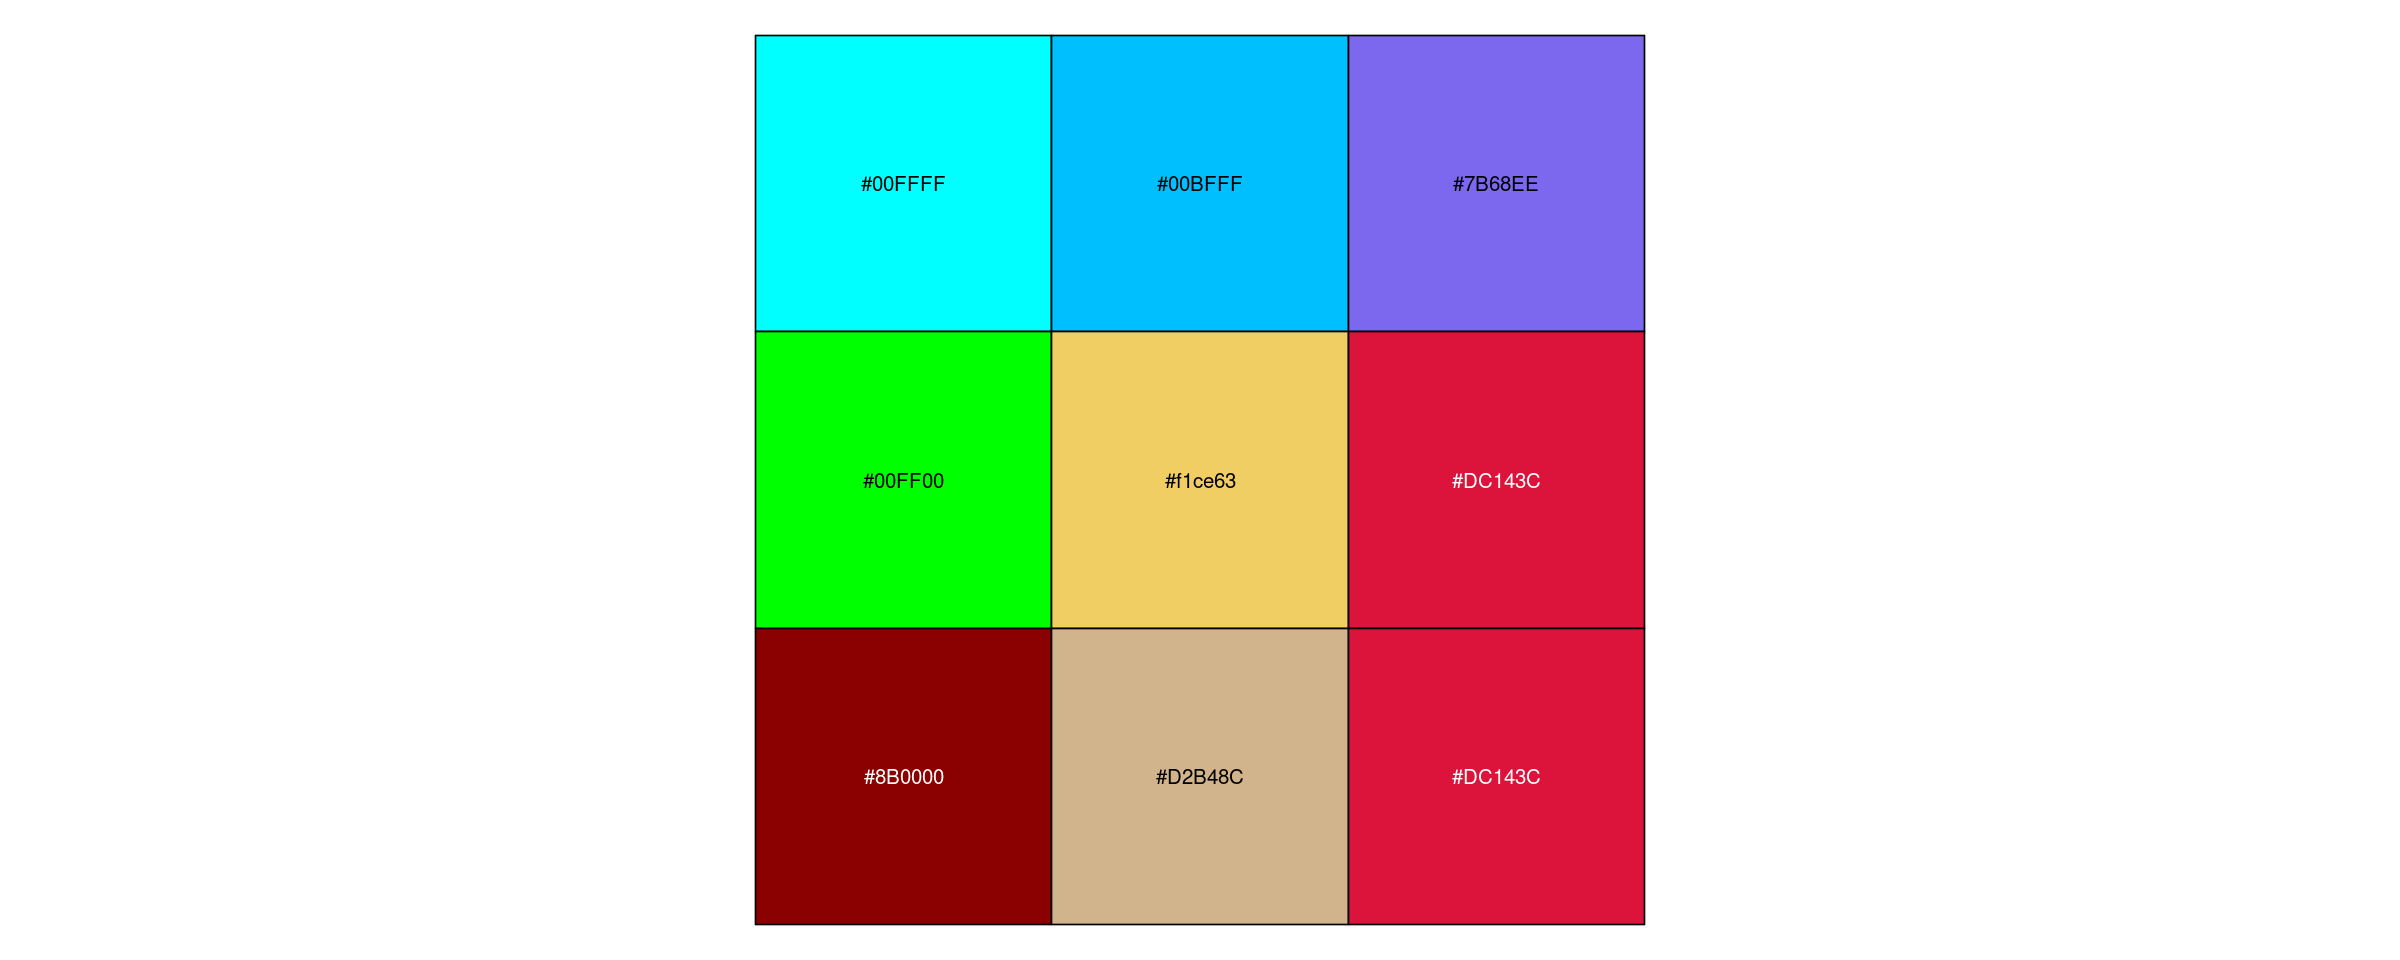

In [553]:
show_col(c("#00FFFF","#00BFFF","#7B68EE","#00FF00","#f1ce63","#DC143C","#8B0000","#D2B48C","#DC143C"))

In [835]:
celltype.need <- c("NK_GNLY","NK_KLRF1","NK_CD7","Endothelial")

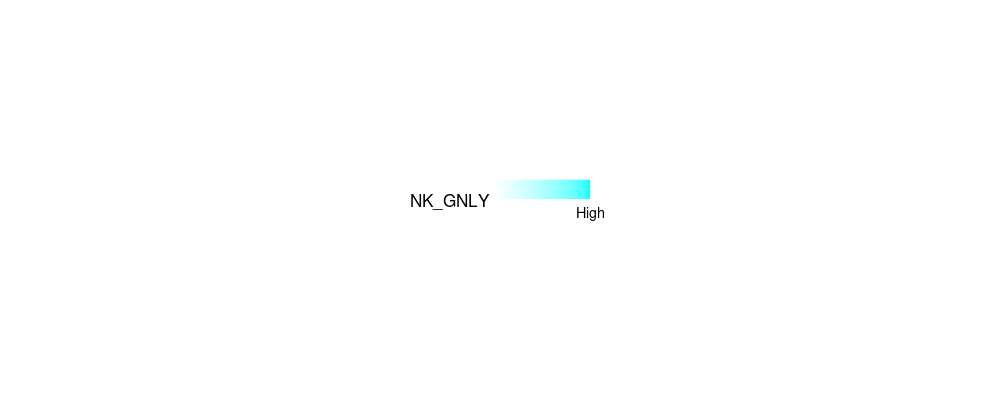

In [836]:
celltype.name <- "NK_GNLY"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p1 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#00FFFF", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd1 <- cowplot::get_legend(p1)
grid.newpage()
grid.draw(lgd1)

In [837]:
celltype.name <- "NK_KLRF1"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p2 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#00BFFF", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd2 <- cowplot::get_legend(p2)

celltype.name <- "NK_CD7"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p3 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#7B68EE", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd3 <- cowplot::get_legend(p3)

celltype.name <- "Endothelial"
df <- spatial_coord %>% dplyr::select(c(celltype.need))
df <- pivot_longer(df, cols = colnames(df),names_to = "celltype", values_to = "value") %>% na.omit() %>% filter(celltype == celltype.name)
p4 <- ggplot2::ggplot() + ggplot2::geom_point(data = df, aes(x= celltype,y=value, color = value))+
                scale_color_gradient(low = "white", high = "#DC143C", name=celltype.name, breaks=c(1),labels=c("High"))+
                ggplot2::theme_void() + 
                theme(legend.position = "top",legend.text = element_text(size=10), 
                      legend.title = element_text(size=12),legend.key.size = unit(14, "pt"))
options(repr.plot.width = 10, repr.plot.height =4, repr.plot.res = 100)
lgd4 <- cowplot::get_legend(p4)

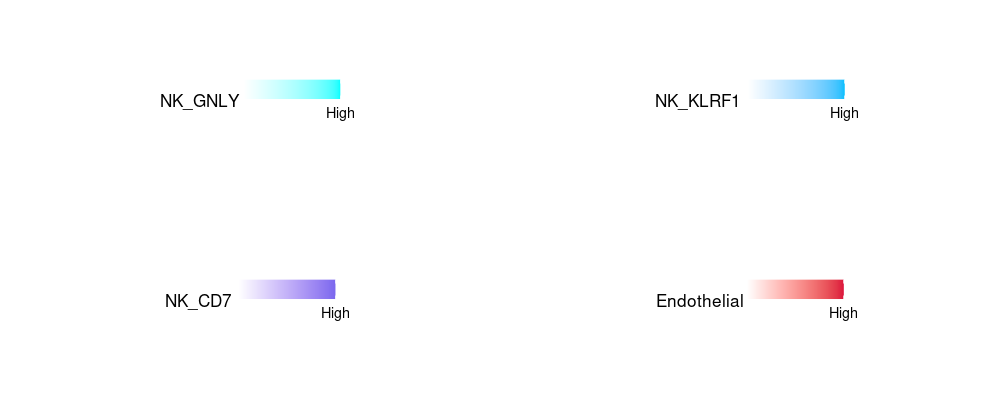

In [839]:
grid.arrange(lgd1,lgd2,lgd3,lgd4,nrow=2)

In [840]:
pdf(file = paste0(dir2,"Figure/spatial_CP6_lgd.pdf"), width = 6, height = 3)
grid.arrange(lgd1,lgd2,lgd3,lgd4, nrow=2)
dev.off()

png 
  2

以下是CP6的：

In [530]:
datalist <- read.csv(paste0(dir_spatial,"/data/spatial_data_list.csv"))
need.list <- datalist[datalist$Type %in% c("TNBC/BRCA") & datalist$Cluster == "CP6",]
need.list

Category   Type      Project           Sample                  
30 三阴乳腺癌 TNBC/BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U12Z1Bs1
31 三阴乳腺癌 TNBC/BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U22Z1Bs1
32 三阴乳腺癌 TNBC/BRCA HTAN_WUSTL_Breast HT268B1-Th1H3Fc2U32Z1Bs1
33 三阴乳腺癌 TNBC/BRCA HTAN_WUSTL_Breast HT268B1-Th1K3Fc2U1Z1Bs1 
   SampleID         SampleID2 Cluster Most.representitive.for.CP
30 HT268B1-Th1K3U12           CP6     CP6                       
31 HT268B1-Th1K3U22           CP6                               
32 HT268B1-Th1K3U32           CP6                               
33 HT268B1-Th1K3U1            CP6

In [533]:
need.list <- datalist[datalist$Type %in% c("TNBC/BRCA") & datalist$Cluster == "CP6",]
for(i in 1:nrow(need.list)){
    project <- need.list$Project[i]
    sample <- need.list$Sample[i]
    dir <- paste0(dir_spatial,"/data/",project,"/",sample)
    cluster <- need.list[need.list$Project == project & need.list$Sample == sample,]$Cluster
    celltype.need <- c("NK_NKG7",
                       "Treg_TNFRSF4","Treg_BATF","Th1_GADD45B","CD4T_CXCR4",
                       "Epithelial","CD8Tex_CCL5")
    print(dir.exists(dir))
    if(dir.exists(dir)){
        obj.ST <- readRDS(file = paste0(dir,"/ST_object.rds"))
        ## 获得打分数据
        obj.ST@meta.data <- read.csv(file = paste0(dir,"/celltype_score_Ucell_top500_0.5FC.csv"),row.names=1) %>%
                                dplyr::select(c(celltype.need))
        metadata_ds <- data.frame(obj.ST@meta.data)
        colnames(metadata_ds) <- colnames(obj.ST@meta.data)
        ## 提取metadata以便打分分数与空间坐标合并
        metadata_ds <- metadata_ds %>% tibble::rownames_to_column("barcodeID") %>%
                    dplyr::mutate(rsum = base::rowSums(.[, celltype.need,drop = FALSE])) %>% 
                    dplyr::filter(rsum != 0) %>%
                    dplyr::select("barcodeID") %>% dplyr::left_join(metadata_ds %>%
                    tibble::rownames_to_column("barcodeID"), by = "barcodeID") %>%
                    tibble::column_to_rownames("barcodeID")
        slice <- names(obj.ST@images)[1]
        cell_types_all <- intersect(colnames(metadata_ds),celltype.need)
        # 提取空间坐标
        spatial_coord <- data.frame(obj.ST@images[[slice]]@coordinates) %>%
        tibble::rownames_to_column("barcodeID") %>% 
        dplyr::mutate(imagerow_scaled = imagerow * obj.ST@images[[slice]]@scale.factors$lowres, 
                      imagecol_scaled = imagecol * obj.ST@images[[slice]]@scale.factors$lowres) %>% 
        dplyr::inner_join(metadata_ds %>% tibble::rownames_to_column("barcodeID"), by = "barcodeID")
        ## 读取切片
        img <- png::readPNG(paste0(dir,"/spatial/tissue_lowres_image.png"))
        ## 调整切片的饱和度
        if (length(dim(img)) == 3) { 
          gray_values <- 0.299 * img[,,1] + 0.587 * img[,,2] + 0.114 * img[,,3]
          saturation_factor <- 0.6  # 设置饱和度降低的比例（0 表示完全灰度化，1 表示原图）,比如设置为 50% 的饱和度
          desaturated_img <- img
          desaturated_img[,,1] <- img[,,1] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,2] <- img[,,2] * saturation_factor + gray_values * (1 - saturation_factor)
          desaturated_img[,,3] <- img[,,3] * saturation_factor + gray_values * (1 - saturation_factor)
        } else {
          stop("图片不是 RGB 格式，无法调整饱和度！")
        }
        img_grob <- grid::rasterGrob(desaturated_img, interpolate = FALSE, width = grid::unit(1,"npc"), height = grid::unit(1, "npc"))
        ## 获取最高表达的细胞
        col_means <- colMeans(spatial_coord[,c(cell_types_all)])
        # 识别最大细胞
        spatial_coord$max <- apply(X = spatial_coord[,c(cell_types_all)], MARGIN = 1, FUN = function(x){
                                            max_col <- names(x)[which.max(x)]
                                            return(max_col)})    
        # 删掉低于平均表达的值点
        for(cell in cell_types_all){
#             mean_value <- mean(spatial_coord[,cell])
            mean_value <- quantile(spatial_coord[,cell], probs = 0.5, na.rm = TRUE)
            spatial_coord[,cell][spatial_coord[,cell] < mean_value] <- NA
            print(table(is.na(spatial_coord[,cell])))
            
#             spatial_coord[, cell] <- lapply(cell, function(col_name) {
#               ## 对于那些有重复值的点位，只保留最高的那个值的颜色。
#               ifelse(spatial_coord$max != col_name, NA, spatial_coord[[col_name]])
#             })
        }
        cell_1 = 'Treg_TNFRSF4'
        cell_2 = 'Treg_BATF'
        cell_3 = 'Th1_GADD45B'
        cell_4 = 'CD4T_CXCR4'
        cell_5 = 'NK_NKG7'
        cell_6 = 'CD8Tex_CCL5'
        cell_7 = 'Epithelial'
        Max_1 = max(spatial_coord[,cell_1],na.rm = TRUE)
        spatial_coord[,cell_1] = spatial_coord[,cell_1]/Max_1
        Max_2 = max(spatial_coord[,cell_2],na.rm = TRUE)
        spatial_coord[,cell_2] = spatial_coord[,cell_2]/Max_2
        Max_3 = max(spatial_coord[,cell_3],na.rm = TRUE)
        spatial_coord[,cell_3] = spatial_coord[,cell_3]/Max_3
        Max_4 = max(spatial_coord[,cell_4],na.rm = TRUE)
        spatial_coord[,cell_4] = spatial_coord[,cell_4]/Max_4
        Max_5 = max(spatial_coord[,cell_5],na.rm = TRUE)
        spatial_coord[,cell_5] = spatial_coord[,cell_5]/Max_5        
        Max_6 = max(spatial_coord[,cell_6],na.rm = TRUE)
        spatial_coord[,cell_6] = spatial_coord[,cell_6]/Max_6        
        Max_7 = max(spatial_coord[,cell_7],na.rm = TRUE)
        spatial_coord[,cell_7] = spatial_coord[,cell_7]/Max_7        

        scatterpie_plt <- ggplot2::ggplot() + 
                ggplot2::annotation_custom(grob = img_grob,xmin = 0, xmax = ncol(img), ymin = 0, ymax = -nrow(img))+
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_1),alpha = get(cell_1)), color = '#00FFFF') + # 颜色再换个炸裂的
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_2),alpha = get(cell_2)), color = '#00BFFF') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_3),alpha = get(cell_3)), color = '#7B68EE') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_4),alpha = get(cell_4)), color = '#00FF00') +
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_5),alpha = get(cell_5)), color = '#8B008B') +        
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_6),alpha = get(cell_6)), color = '#FF1493') +        
                ggplot2::geom_point(data = spatial_coord, aes(x = imagecol_scaled,y = imagerow_scaled,
                                                              size = get(cell_7),alpha = get(cell_7)), color = '#f1ce63') +        
                ggplot2::scale_y_reverse() + ggplot2::ylim(nrow(img),0) + 
                ggplot2::xlim(0, ncol(img)) + 
                cowplot::theme_half_open(11,rel_small = 1) + 
                ggplot2::theme_void() + 
                ggplot2::coord_fixed(ratio = 1,xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") +
                ggplot2::scale_size_continuous(range=c(0,2))+
                ggplot2::scale_alpha_continuous(range=c(0.5,1))+
                theme(legend.position = "none")
#                     labs(size = cell) + 
#                 guides(alpha = "none")            
      
        pdf(paste0(dir2,"Figure/spatial/CP6/",project,"_",sample,'_dot.pdf'),width = 8,height = 7)
        print(scatterpie_plt)
        dev.off()      
    }
}

[1] TRUE

FALSE  TRUE 
 2106  2105 

FALSE  TRUE 
 2106  2105 

FALSE  TRUE 
 2106  2105 

FALSE  TRUE 
 2106  2105 

FALSE  TRUE 
 2106  2105 

FALSE  TRUE 
 2106  2105 

FALSE  TRUE 
 2106  2105 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 2105 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2105 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2105 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2105 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2105 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2105 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2105 rows containing missing values (`geom_point()`).”


[1] TRUE

FALSE  TRUE 
 2116  2116 

FALSE  TRUE 
 2116  2116 

FALSE  TRUE 
 2117  2115 

FALSE  TRUE 
 2116  2116 

FALSE  TRUE 
 2116  2116 

FALSE  TRUE 
 2116  2116 

FALSE  TRUE 
 2117  2115 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 2116 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2115 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2116 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2116 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2116 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2115 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2116 rows containing missing values (`geom_point()`).”


[1] TRUE

FALSE  TRUE 
 2062  2061 

FALSE  TRUE 
 2062  2061 

FALSE  TRUE 
 2062  2061 

FALSE  TRUE 
 2062  2061 

FALSE  TRUE 
 2062  2061 

FALSE  TRUE 
 2062  2061 

FALSE  TRUE 
 2062  2061 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 2061 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2061 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2061 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2061 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2061 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2061 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2061 rows containing missing values (`geom_point()`).”


[1] TRUE

FALSE  TRUE 
 2118  2117 

FALSE  TRUE 
 2118  2117 

FALSE  TRUE 
 2118  2117 

FALSE  TRUE 
 2118  2117 

FALSE  TRUE 
 2118  2117 

FALSE  TRUE 
 2118  2117 

FALSE  TRUE 
 2118  2117 


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 2117 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2117 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2117 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2117 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2117 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2117 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2117 rows containing missing values (`geom_point()`).”
